# Shear profile around A360 using ComCam HSM shapes - Manual

Prakruth Adari, Céline Combet, Anja von der Linden\
LSST Science Piplines version: Weekly 2025_14\
Container Size: large

This notebook is a condensed set of code to obtain a shear profile of Abell 360. The main steps are:

- Loading the relevant object catalogs (all tracts and patches needed) using the butler
- Applying cuts (color/photo-z + lensing quality)
- Load in calibration (using the `gen_hsc_calibration` script)
- Shear profile

Most steps start with loading in data from the previous step so each step usually ends with writing data locally, this means we can quickly apply cuts to the same catalog and re-calibrate without having to re-query from the Butler. 

In [1]:
!eups list -s | grep lsst_distrib

lsst_distrib          gdfb3db0272+f18f63b413 	current w_2025_27 w_latest setup


In [2]:
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.spatial import KDTree
import scipy.interpolate as interpolate
from scipy.optimize import curve_fit
import scipy.integrate as integrate
import scipy.stats as stats
import healpy as hp
import pandas as pd
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import to_rgba
from matplotlib.patches import Patch
from astropy.visualization import make_lupton_rgb
from matplotlib.legend_handler import HandlerLine2D
from matplotlib.lines import Line2D
from astropy.table import Table, join, vstack
from astropy.io import fits
from astropy.coordinates import SkyCoord
# %matplotlib widget
import h5py
import qp

In [4]:
# Familiar stack packages
from lsst.daf.butler import Butler
from lsst.geom import Box2I, Box2D, Point2I, Point2D, Extent2I, Extent2D
# from lsst.afw.image import Exposure, Image, PARENT
import lsst.sphgeom

# These may be less familiar objects dealing with multi-band data products
from lsst.afw.image import MultibandExposure, MultibandImage

In [5]:
# import lsst.afw.display as afwDisplay
import os, sys
import functools
import pickle

In [6]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [7]:
hdir = os.getenv('HOME')
ddir = '/home/a/adari/DATA'

In [8]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [9]:
arcsec = 1/60**2

In [10]:
rng = np.random.default_rng()

In [11]:
def showRGB(image, bgr="gri", ax=None, fp=None, figsize=(8,8), stretch=57, Q=10):
    """Display an RGB color composite image with matplotlib.
    
    Parameters
    ----------
    image : `MultibandImage`
        `MultibandImage` to display.
    bgr : sequence
        A 3-element sequence of filter names (i.e. keys of the exps dict) indicating what band
        to use for each channel. If `image` only has three filters then this parameter is ignored
        and the filters in the image are used.
    ax : `matplotlib.axes.Axes`
        Axis in a `matplotlib.Figure` to display the image.
        If `axis` is `None` then a new figure is created.
    fp: `lsst.afw.detection.Footprint`
        Footprint that contains the peak catalog for peaks in the image.
        If `fp` is `None` then no peak positions are plotted.
    figsize: tuple
        Size of the `matplotlib.Figure` created.
        If `ax` is not `None` then this parameter is ignored.
    stretch: int
        The linear stretch of the image.
    Q: int
        The Asinh softening parameter.
    """
    # If the image only has 3 bands, reverse the order of the bands to produce the RGB image
    if len(image) == 3:
        bgr = image.filters
    # Extract the primary image component of each Exposure with the .image property, and use .array to get a NumPy array view.
    rgb = make_lupton_rgb(image_r=image[bgr[2]].array,  # numpy array for the r channel
                          image_g=image[bgr[1]].array,  # numpy array for the g channel
                          image_b=image[bgr[0]].array,  # numpy array for the b channel
                          stretch=stretch, Q=Q)  # parameters used to stretch and scale the pixel values
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    
    # Exposure.getBBox() returns a Box2I, a box with integer pixel coordinates that correspond to the centers of pixels.
    # Matplotlib's `extent` argument expects to receive the coordinates of the edges of pixels, which is what
    # this Box2D (a box with floating-point coordinates) represents.
    integerPixelBBox = image[bgr[0]].getBBox()
    bbox = Box2D(integerPixelBBox)
    ax.imshow(rgb, interpolation='nearest', origin='lower', extent=(bbox.getMinX(), bbox.getMaxX(), bbox.getMinY(), bbox.getMaxY()))
    if fp is not None:
        for peak in fp.getPeaks():
            ax.plot(peak.getIx(), peak.getIy(), "bx", mew=2)

In [13]:
# QOL Functions to make cubehelix colormaps

import matplotlib as mpl
import matplotlib.colors as mcolors


def _reverser(func, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    return func(1 - x)

def reversed(cmap):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_r = {
        key: (functools.partial(_reverser, data))
        for key, data in cmap._segmentdata.items()}

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_r,
        cmap.N,
        cmap._gamma,
    )

    # Reverse the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def _truncator(func, light, dark, x):
    # adapted from matplotlib.colors.LinearSegmentedColormap._reverser
    if (light > 1) or (light < 0):
        raise ValueError(f"light {light} not in [0, 1]")
    if (dark > 1) or (dark < 0):
        raise ValueError(f"dark {dark} not in [0, 1]")

    return func(x * (light - dark) + dark)


def truncated(cmap, light, dark):
    # adapted from matplotlib.colors.LinearSegmentedColormap.reversed
    # Using a partial object keeps the cmap picklable.
    data_t = {
        key: (functools.partial(_truncator, data, light, dark))
        for key, data in cmap._segmentdata.items()
    }

    new_cmap = mcolors.LinearSegmentedColormap(
        cmap.name,
        data_t,
        cmap.N,
        cmap._gamma,
    )

    # Truncate the over/under values too
    new_cmap._rgba_over = cmap._rgba_under
    new_cmap._rgba_under = cmap._rgba_over
    new_cmap._rgba_bad = cmap._rgba_bad

    return new_cmap


def cubehelix_colormap(
    *,
    start=None,
    rot=None,
    gamma=None,
    hue=None,
    light=1,
    dark=0,
    name=None,
    reverse=False,
):
    """
    cubehelix color scheme by Dave Green (https://people.phy.cam.ac.uk/dag9/CUBEHELIX/)
    """
    # Note: this relies on an internal matplotlib function, so may need to be
    # updated in the future
    cdict = mpl._cm.cubehelix(gamma=gamma, s=start, r=rot, h=hue)

    cmap = mcolors.LinearSegmentedColormap(name, cdict)

    cmap = truncated(cmap, light, dark)

    if reverse:
        cmap = reversed(cmap)

    return cmap

def cubehelix_palette(
    n_colors=6,
    start=0,
    rot=0.4,
    gamma=1.0,
    hue=0.8,
    light=0.85,
    dark=0.15,
    reverse=False,
):
    cmap = cubehelix_colormap(
        start=start,
        rot=rot,
        gamma=gamma,
        hue=hue,
        light=light,
        dark=dark,
        name=None,
        reverse=reverse,
    )

    x = np.linspace(0, 1, n_colors)
    palette = cmap(x)[:, :3].tolist()

    return palette

In [14]:
omega_m = .31
omega_de= .69
omega_r = 0
H0 = 70 # km/s/Mpc
C = 3e5 # km/s

In [17]:
Hz = lambda z : C/(H0  * np.sqrt((omega_de + omega_m * (1+z)**3 + omega_r * (1+z)**4)))
chi_dl = lambda z, z0=0 : integrate.quad(Hz, z0, z)[0]
Da = lambda z : chi_dl(z)/(1+z)
beta_r = lambda zl, zs : integrate.quad(Hz, zl, zs)[0]/integrate.quad(Hz, 0, zs)[0]

In [18]:
flux_suffix = '_cModelFlux'

#### Manual Profile Calculation

In [23]:
def get_tang_cross(cluster, sky_dist, bins, sample_prefac=-1/2, ci_level=.95):
    nb = len(bins) - 1
    tang_avg = np.zeros(nb)
    cross_avg = np.zeros_like(tang_avg)

    tang_err = np.zeros((nb, 2))
    cross_err = np.zeros_like(tang_err)

    bin_rs = []
    for i in range(nb):
        ndx_filt = (sky_dist > bins[i]) * (sky_dist < bins[i+1])
        bin_rs.append(np.where(ndx_filt)[0])
        if np.sum(ndx_filt) < 1:
            continue

        sample = cluster[ndx_filt]
        sample_t = sample_prefac*sample['gamma_t']
        sample_x = sample_prefac*sample['gamma_x']

        # print(sample_t, sample_x)?

        ta = np.mean(sample_t)
        xa = np.mean(sample_x)

        te = stats.bootstrap([sample_t], np.mean, confidence_level=ci_level).confidence_interval
        xe = stats.bootstrap([sample_x], np.mean, confidence_level=ci_level).confidence_interval
        
        tang_avg[i] = ta
        cross_avg[i] = xa
        tang_err[i] = te
        cross_err[i] = xe

    return tang_avg, cross_avg, tang_err, cross_err

In [24]:
# cluster_coords = (59.48731586, -49.00034946)
# cluster_coords = (37.86501659859067, 6.982204815599694)
cluster_coords = (37.865017, 6.982205)
ra_bcg = cluster_coords[0]
dec_bcg = cluster_coords[1]


In [25]:
wl_c = SkyCoord(wl_table['coord_ra'] * u.deg, wl_table['coord_dec']*u.deg)
c1 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)

In [26]:
# source_phi = c1.position_angle(wl_c).value


In [27]:
source_phi = np.arctan2(wl_table['coord_dec'] - cluster_coords[1], (cluster_coords[0] - wl_table['coord_ra'])*np.cos(np.deg2rad(cluster_coords[1])))
ang_dist = np.sqrt(((wl_table['coord_ra'] - cluster_coords[0]) * np.cos(np.deg2rad(cluster_coords[1])))**2 + (wl_table['coord_dec'] - cluster_coords[1])**2)
sky_distance = Da(.22) * ang_dist * (np.pi/180)

In [28]:
trial_shear = g1+1j*g2
cl_shear = trial_shear * -1*np.exp(-2j*source_phi)

In [29]:
wl_table['gamma_t'] = cl_shear.real
wl_table['gamma_x'] = cl_shear.imag
wl_table['source_phi'] = source_phi
wl_table['deg_sep'] = ang_dist
wl_table['sky_distance'] = sky_distance

In [30]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
# bins_mpc = np.array([.2, .3, .4, .6, 1, 1.25, 2, 3, 4, 6.5, 7])
bin_mids = 1/2 * (bins_mpc[1:] + bins_mpc[:-1])

In [31]:
shear_cl = get_tang_cross(wl_table, sky_distance, bins_mpc,sample_prefac=1, ci_level=.68)

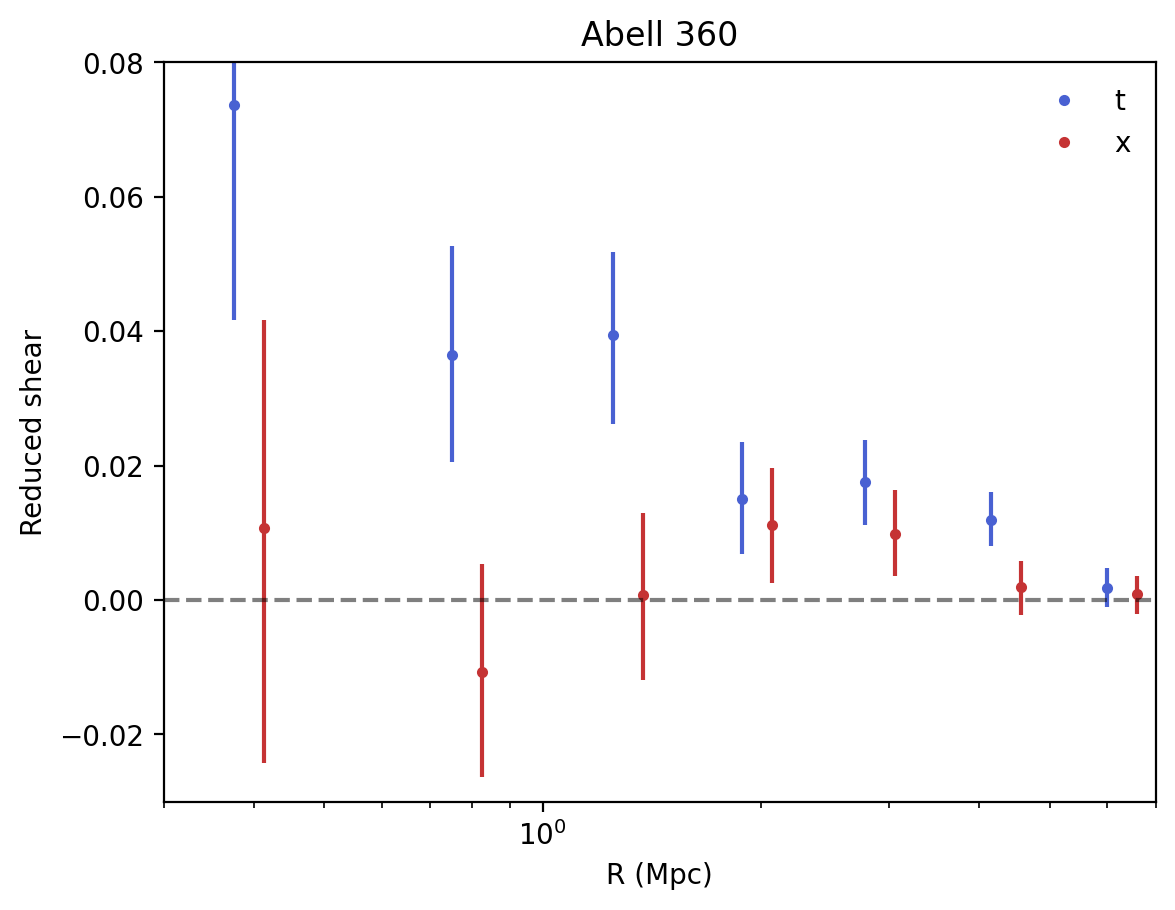

In [32]:
cmap = cm.coolwarm

# plt.plot(sky_distance, reduced_shear, '.')
plt.plot(bin_mids, shear_cl[0], '.', label='t', color=cmap(.05))
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05))

plt.plot(1.1*bin_mids, shear_cl[1], '.', label='x', color=cmap(.95))
plt.vlines(1.1*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))

# plt.plot(rbin_mids+.05*rbin_mids, crs_pshear[0], '.-', label='Céline - t', color=cmap(.15), alpha=.2)
# plt.vlines(rbin_mids+.05*rbin_mids, crs_pshear[2][:,0], crs_pshear[2][:,1], color=cmap(0.15), alpha=.2)

plt.semilogx()

plt.axhline(0, ls='--', color='k', alpha=.5)

# plt.errorbar(bin_mids*1.05, cl_plot['gt'], cl_plot['gt_err'], 
#              ls='', marker='.', label='Celine - t', color=cmap(0.15), alpha=.5)
# plt.errorbar(bin_mids*1.15, cl_plot['gx'], cl_plot['gx_err'], 
#              ls='', marker='.', label='Celine - x', color=cmap(0.95), alpha=.5)

# plt.plot(rbin_mids+.15*rbin_mids, crs_pshear[1], '.-', label='Céline - x', color=cmap(.95), alpha=.2)
# plt.vlines(rbin_mids+.15*rbin_mids, crs_pshear[3][:,0], crs_pshear[3][:,1], color=cmap(0.95), alpha=.2)
# plt.title("EDFS Cluster Profile at $z\\approx 0.7$")
plt.title("Abell 360")
# plt.xlim(0.2, 10)
plt.ylim([-0.03,0.08])
plt.xlim([0.3,7])
# plt.ylim(-0.05, 0.15)
plt.ylabel("Reduced shear")
plt.xlabel("R (Mpc)")
plt.legend(frameon=False)

In [33]:
bins_pz = np.array([.25, .5, 1, 1.5])
# bins_mpc = np.array([.2, .3, .4, .6, 1, 1.25, 2, 3, 4, 6.5, 7])
bin_mids = 1/2 * (bins_pz[1:] + bins_pz[:-1])

In [34]:
shear_cl = get_tang_cross(wl_table, wl_table['fzb_z_median'], bins_pz,sample_prefac=1, ci_level=.68)

In [38]:
bin_width = np.diff(bins_pz)

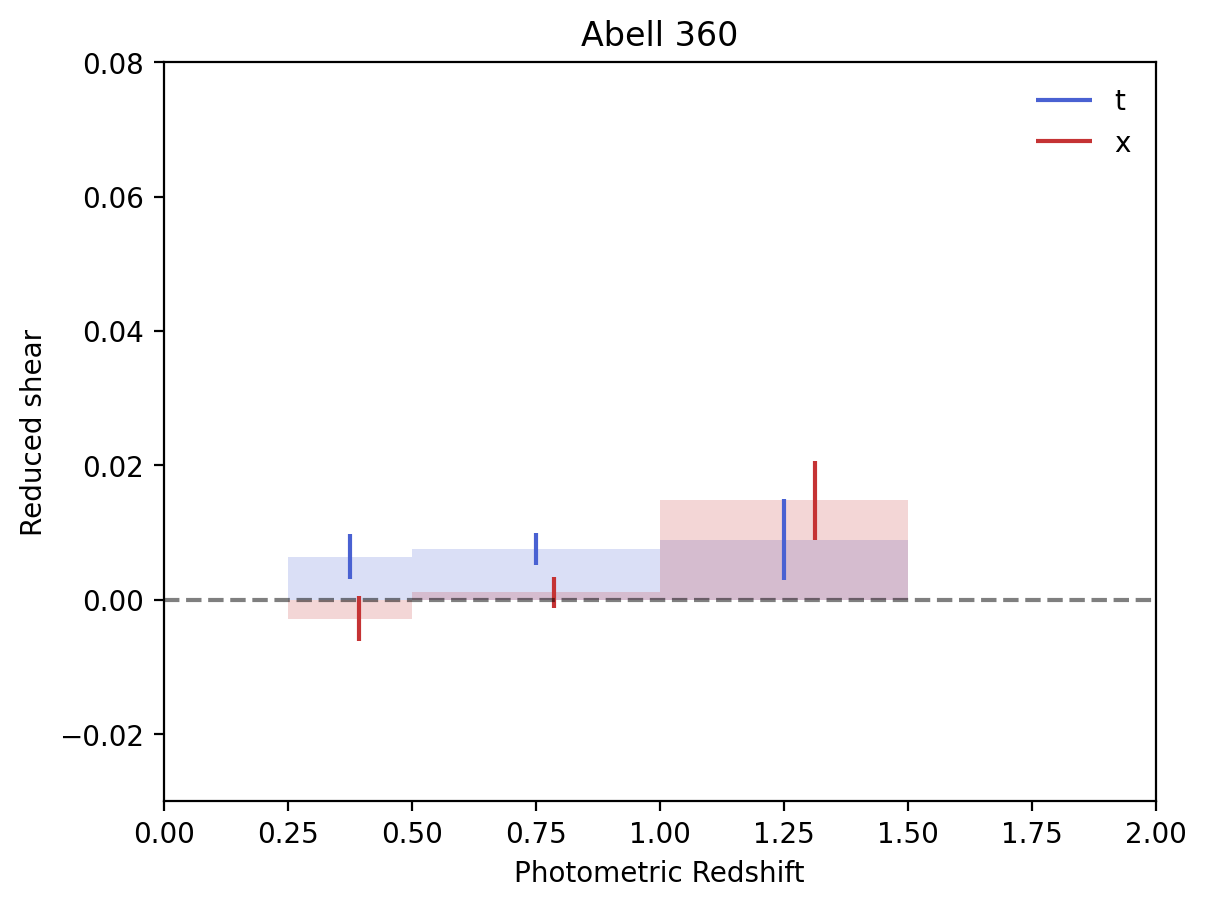

In [48]:
cmap = cm.coolwarm

plt.bar(bin_mids, height=shear_cl[0], width=bin_width, color=cmap(0.05), alpha=0.2)
plt.vlines(bin_mids, shear_cl[2][:,0], shear_cl[2][:,1], color=cmap(0.05), label='t')

# plt.plot(bin_mids, shear_cl[0], '.', label='t', color=cmap(.05))

plt.bar(bin_mids, height=shear_cl[1], width=bin_width, color=cmap(0.95), alpha=0.2)
plt.vlines(bin_mids*1.05, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95), label='x')

# plt.plot(1.1*bin_mids, shear_cl[1], '.', label='x', color=cmap(.95))
# plt.vlines(1.1*bin_mids, shear_cl[3][:,0], shear_cl[3][:,1], color=cmap(0.95))

plt.axhline(0, ls='--', color='k', alpha=.5)

plt.title("Abell 360")
# plt.xlim(0.2, 10)
plt.ylim([-0.03,0.08])
plt.xlim([0,2])
# for pzl in bins_pz:
#     plt.axvline(pzl, ls=':', color='k', alpha=0.2)
# plt.ylim(-0.05, 0.15)
plt.ylabel("Reduced shear")
plt.xlabel("Photometric Redshift")
plt.legend(frameon=False)

In [128]:
# c1 = SkyCoord(ra_bcg*u.deg, dec_bcg*u.deg)
# wl_c = SkyCoord(wl_table['coord_ra']*u.deg, wl_table['coord_dec']*u.deg)

# deg_sep = c1.separation(wl_c)
near_filt = (sky_distance < 0.5) * (sky_distance > 0.25)
near_table = wl_table[near_filt]

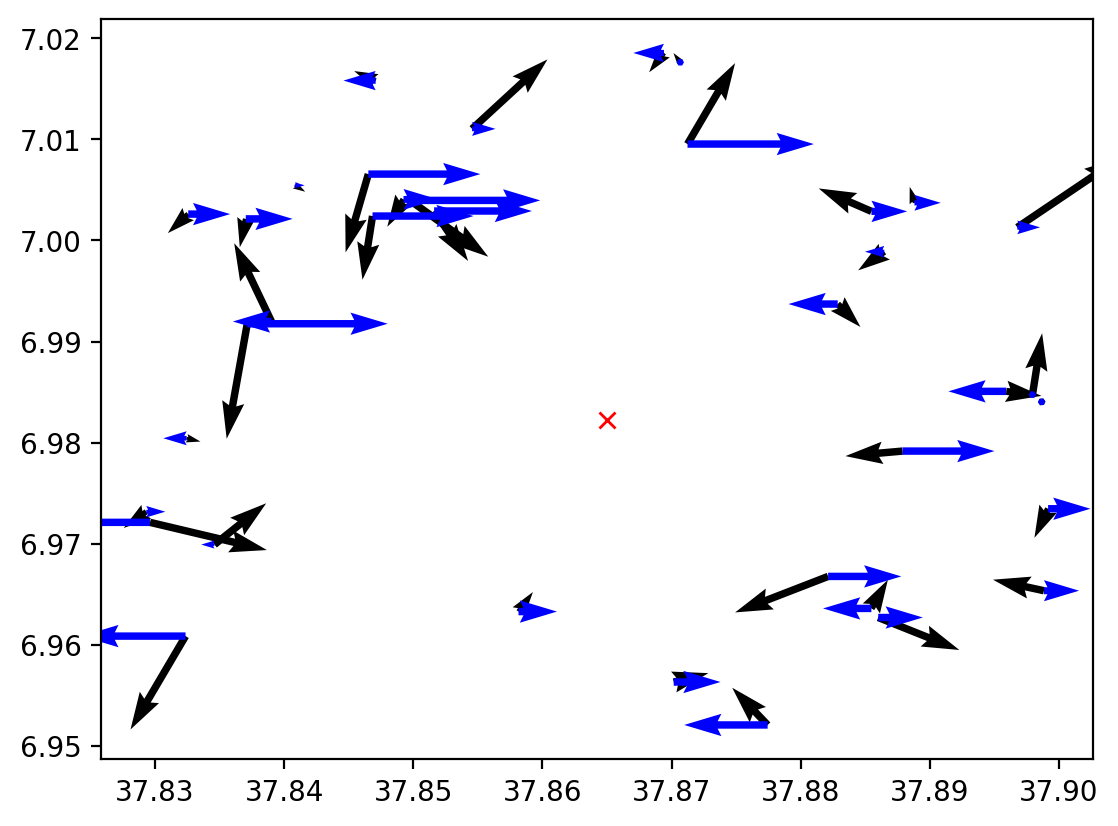

In [129]:
# plt.plot(near_table['ra'], near_table['dec'], ',')
plt.quiver(near_table['coord_ra'], near_table['coord_dec'],
           near_table['i_hsmShapeRegauss_e1'], near_table['i_hsmShapeRegauss_e2'])
plt.quiver(near_table['coord_ra'], near_table['coord_dec'],
           near_table['cl_shear'].real, 0, color='b')
plt.plot(ra_bcg, dec_bcg, 'rx')

In [277]:
test_angles = np.linspace(0, 2, 13)

kale = np.vstack((np.cos(test_angles *np.pi), np.sin(test_angles * np.pi))).T

In [331]:
test_angles = np.linspace(0, 2, 13)

# test_points = np.array(cluster_coords) + 0.0192 *np.array([[np.cos(.99*np.pi), np.sin(.99*np.pi)],
#                                                         [np.cos(.75*np.pi), np.sin(.75*np.pi)],
#                                                         [np.cos(.489*np.pi), np.sin(.489*np.pi)]])

test_points = np.array(cluster_coords) + 0.02 * np.vstack((np.cos(test_angles * np.pi), np.sin(test_angles * np.pi))).T
test_es = np.zeros((len(test_points),2))
test_points[-1,:] = [37.86724617504353, 6.9788194308843385]


test_es[:,0] = 0.3
test_es[:,1] = 0.0
test_es[-1,0] = 0.051444355
test_es[-1,1] =  -0.00516619

In [332]:
# test_phi2 = np.arctan2(test_points[:,1] - cluster_coords[1], (cluster_coords[0] - test_points[:,0])*np.cos(np.deg2rad(cluster_coords[1])))


In [333]:
test_c = SkyCoord(test_points[:,0] * u.deg, test_points[:,1] * u.deg, frame='icrs')
test_phi = c1.position_angle(test_c).value
test_shear = test_es[:,0] + 1j*test_es[:,1]
test_cl = test_shear * 1*np.exp(-2j*test_phi)

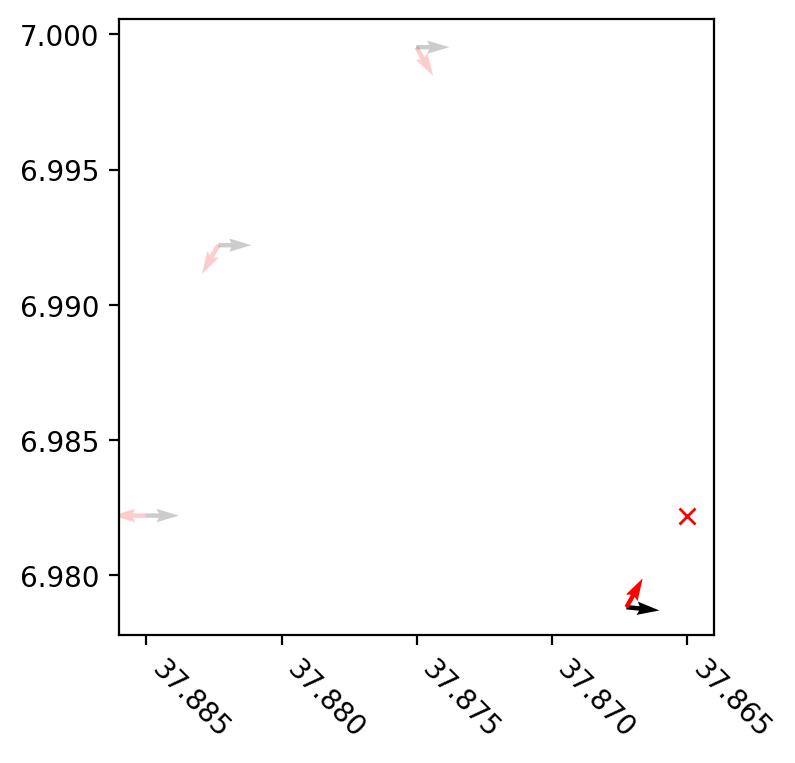

In [334]:
plt.figure(figsize=(4,4)) 
plt.plot(ra_bcg, dec_bcg, 'rx')
plt.quiver(test_points[:3,0], test_points[:3,1], test_es[:3,0], test_es[:3,1], alpha=0.2)
plt.quiver(test_points[:3,0], test_points[:3,1], test_cl[:3].real, test_cl[:3].imag, color='r', alpha=0.2)

plt.quiver(test_points[-1,0], test_points[-1,1], test_es[-1,0], test_es[-1,1])
plt.quiver(test_points[-1,0], test_points[-1,1], test_cl[-1].real, test_cl[-1].imag, color='r')
# plt.plot(test_points[0,0], test_points[0,1], '.', color='purple')
# plt.plot(test_points[1,0], test_points[1,1], '.', color='black')
# plt.plot(test_points[2,0], test_points[2,1], '.', color='blue')
plt.xticks(rotation=-45, ha='left')
plt.gca().invert_xaxis()
plt.gca().set_aspect('equal')


#### CLMM Profile

In [303]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [304]:
galcat = GCData()
galcat['ra'] = wl_table['coord_ra']
galcat['dec'] = wl_table['coord_dec']
galcat['e1'] = g1
galcat['e2'] = g2
galcat['e_err'] = wl_table['i_hsmShapeRegauss_sigma']/2
galcat['hsm_weight'] = weight
galcat['id'] = np.arange(len(wl_table))
# galcat['e_err'] = e_err[to_use]/2.  # factor 2 to account for conversion between e and g

# galcat['z'] = np.zeros(len(wl_table)) # CLMM needs a redshift column for the source, even if not used
galcat['z'] = wl_table['fzb_z_median']

In [305]:
ra_bcg = 37.865017
dec_bcg = 6.982205

cluster_id = "Abell 360"
gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')

gc_object1.compute_tangential_and_cross_components(add=True);

In [306]:
gc_object1.compute_galaxy_weights(
        shape_component1="e1",
        shape_component2="e2",
        use_shape_error=True,
        shape_component1_err="e_err",
        shape_component2_err="e_err",
        use_shape_noise=True,
        weight_name="w_ls",
        cosmo=cosmo,
        add=True,
    ) 

array([6.70689297, 6.50410795, 6.79272938, ..., 6.09031057, 6.06020784,
       6.3909564 ])

In [307]:
# decade = np.load('./data/A360_DECADE_WL_profile.npz')

In [308]:
bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7])
# bins_mpc = np.array([.2, .3, .4, .6, 1, 1.25, 2, 3, 4, 6.5, 10])

In [312]:
gc_object1.save(

GCData(cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc', columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l)

In [309]:
# gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
#                                overwrite=True, use_weights=False, gal_ids_in_bins=False);
# celine_rs_profile = gc_object1.profile

gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo,
                               overwrite=True, use_weights=False, gal_ids_in_bins=False);
prak_rs_profile = gc_object1.profile


In [310]:
# Already checked -- there is little to no difference using the CLMM weights
# gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, overwrite=True, use_weights=True, gal_ids_in_bins=False);
# weighted_profile = gc_object1.profile

Text(0.5, 1.0, 'HSM Profile with Color Cut - DP1')

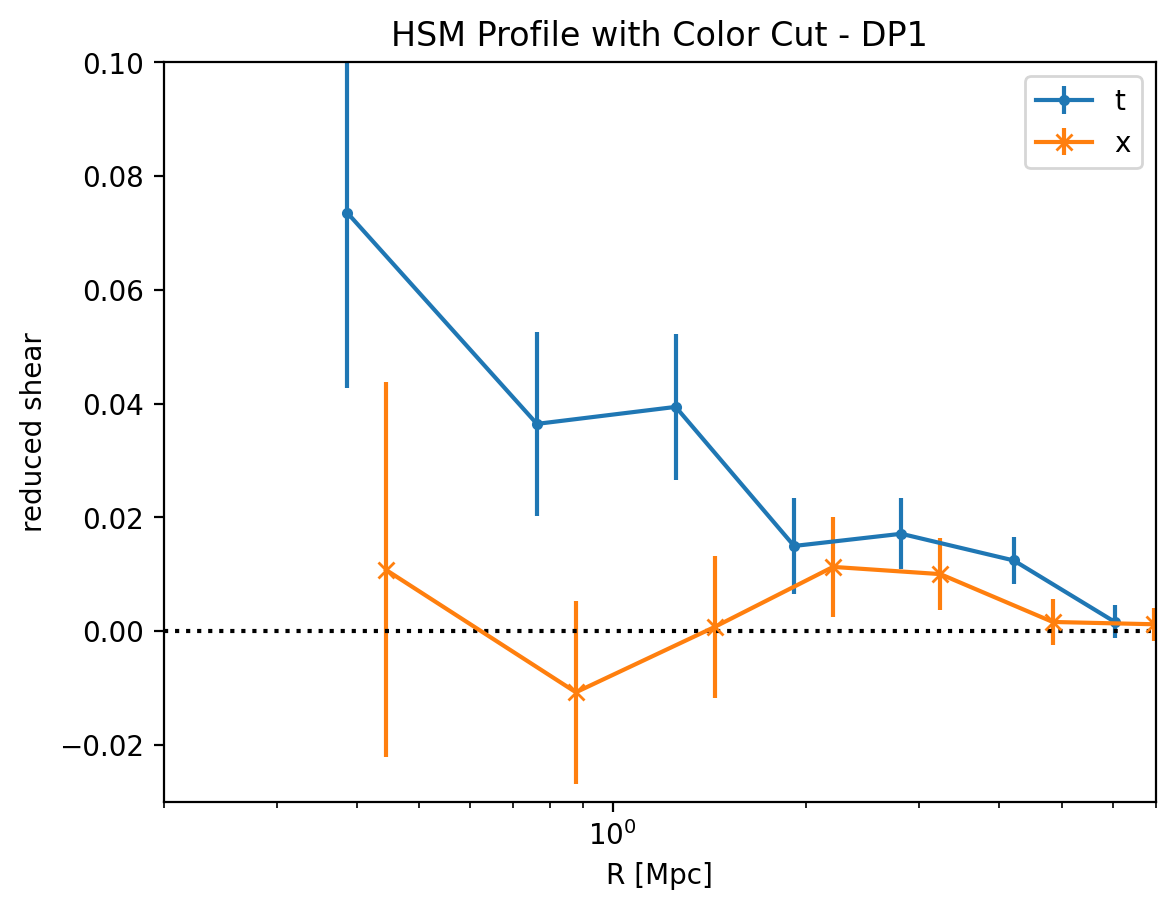

In [311]:
# plt.errorbar(decade['R']*1, decade['gt'],np.sqrt(np.diag(decade['cov_gt'])), 
#              ls='-', marker='.', label='DECADE - t')
# # plt.errorbar(decade['R']*1.1, decade['gx'],np.sqrt(np.diag(decade['cov_gx'])), 
# #              ls='', marker='x', label='DECADE - x')

plt.errorbar(prak_rs_profile['radius']*1, prak_rs_profile['gt'], prak_rs_profile['gt_err'], 
             ls='-', marker='.', label='t')
plt.errorbar(prak_rs_profile['radius']*1.15, prak_rs_profile['gx'], prak_rs_profile['gx_err'], 
             ls='-', marker='x', label='x')

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('reduced shear')
plt.legend(loc=1)
plt.title("HSM Profile with Color Cut - DP1")

### Butler Data

In [23]:
# Setup the Butler

repo = "dp1"
collection = "LSSTComCam/DP1"
obs_butler = Butler(repo, collections=collection)
obs_registry = obs_butler.registry
t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [28]:
# Position of the BCG for A360
cluster_coords = (37.86501659859067, 6.982204815599694)
ra_bcg, dec_bcg = cluster_coords

# Looking for all patches in delta deg region around it
delta = 0.5
center = lsst.geom.SpherePoint(ra_bcg, dec_bcg, lsst.geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

nsteps = 20
ra_range = np.linspace(ra_min, ra_max, num=nsteps)
dec_range = np.linspace(dec_min, dec_max, num=nsteps)
radec = []
for rar in ra_range:
    for decr in dec_range:
        radec.append(lsst.geom.SpherePoint(rar, decr, lsst.geom.degrees))
        
tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{10463: [30, 40, 50, 60, 70, 80, 90, 31, 41, 51, 61, 71, 81, 91, 32, 42, 52, 62, 72, 82, 92, 33, 43, 53, 63, 73, 83, 93, 34, 44, 54, 64, 74, 84, 94], 10704: [0, 1, 2, 3, 4, 5], 10464: [37, 47, 57, 67, 77, 87, 97, 38, 48, 58, 68, 78, 88, 98, 39, 49, 59, 69, 79, 89, 99], 10705: [8, 9]}


In [29]:
tract = t_skymap.findTract(center)
patch = tract.findPatch(center)
tract_id = tract.tract_id
patch_id = patch.getSequentialIndex()
skymap_str = 'lsst_cells_v1'

In [30]:
bands = list('griz')
cmodel_bands = [b+suffix for b in bands for suffix in ['_cModelFlux', '_cModelFluxErr', '_cModel_flag']]
gaap_bands = [b+suffix for b in bands for suffix in ['_gaap1p0Flux', '_gaap1p0FluxErr',  '_gaapFlux_flag']]

object_req_cols = ['coord_ra', 'coord_dec', 'refExtendedness', 'objectId',
            'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy', 'refBand', 'x', 'y',
            'patch', 'tract', 'i_ixxPSF', 'i_iyyPSF', 'i_ixyPSF', 'i_iPSF_flag',
            'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_sigma', 'i_blendedness' ] + cmodel_bands + gaap_bands

In [31]:
cluster_tables = []

tids = tp_dict.keys()
for tid in tids:
    cluster_tables.append(obs_butler.get('object', skymap='lsst_cells_v1', tract=tid, 
                               parameters={"columns":object_req_cols}))

In [32]:
primary_cluster = vstack(cluster_tables, metadata_conflicts='silent')

In [33]:
for b in bands:
    primary_cluster[f'{b}_cModel_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_cModelFlux'])
    primary_cluster[f'{b}_gaap_mag'] = u.nJy.to(u.ABmag, primary_cluster[f'{b}_gaap1p0Flux'])
    # primary_cluster[f'{b}_snr'] = primary_cluster[f'{b}{flux_suffix}']/primary_cluster[f'{b}{flux_suffix}Err']

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [34]:
R2 = 1 - (primary_cluster['i_ixxPSF']+primary_cluster['i_iyyPSF'])/(primary_cluster['shape_xx']+primary_cluster['shape_yy'])
primary_cluster['res'] = R2

In [35]:
primary_cluster.add_index('objectId')

In [36]:
preclean_table = primary_cluster 

In [37]:
c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
preclean_table['sep'] = sep.deg

In [38]:
preclean_table = Table.filled(preclean_table, fill_value=np.nan)

In [40]:
# u_tract = np.unique(preclean_table['tract'])

# for tid in u_tract:
#     tid_filt = preclean_table['tract']==tid
#     plt.plot(preclean_table[tid_filt]['coord_ra'], preclean_table[tid_filt]['coord_dec'], '.', label=tid)
# plt.legend()

#### Quality Cuts

In [41]:
c1 = SkyCoord(preclean_table['coord_ra']*u.deg, preclean_table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)

In [42]:
preclean_table = preclean_table[sep.deg < 0.5]

In [43]:
quality_flags = ['i_iPSF_flag', 'i_hsmShapeRegauss_flag', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'z_cModel_flag',
                 'g_gaapFlux_flag', 'r_gaapFlux_flag', 'i_gaapFlux_flag', 'z_gaapFlux_flag']
print(f"For flag 'refExtendedness', there are {np.sum(np.isnan(preclean_table['refExtendedness']))} bad objects")

for qf in quality_flags:
    print(f"For flag '{qf}', there are {np.sum(preclean_table[qf] == True)} bad objects")


For flag 'refExtendedness', there are 24892 bad objects
For flag 'i_iPSF_flag', there are 62462 bad objects
For flag 'i_hsmShapeRegauss_flag', there are 91836 bad objects
For flag 'g_cModel_flag', there are 4016 bad objects
For flag 'r_cModel_flag', there are 4228 bad objects
For flag 'i_cModel_flag', there are 4137 bad objects
For flag 'z_cModel_flag', there are 3713 bad objects
For flag 'g_gaapFlux_flag', there are 0 bad objects
For flag 'r_gaapFlux_flag', there are 0 bad objects
For flag 'i_gaapFlux_flag', there are 6 bad objects
For flag 'z_gaapFlux_flag', there are 0 bad objects


In [110]:
clean_filt = np.logical_and.reduce((~preclean_table['i_iPSF_flag'], ~preclean_table['i_hsmShapeRegauss_flag'], ~np.isnan(preclean_table['refExtendedness']),
                                    ~preclean_table['g_cModel_flag'], ~preclean_table['r_cModel_flag'], ~preclean_table['i_cModel_flag'], ~preclean_table['z_cModel_flag'],
                                    ~preclean_table['g_gaapFlux_flag'], ~preclean_table['r_gaapFlux_flag'], ~preclean_table['i_gaapFlux_flag'], ~preclean_table['z_gaapFlux_flag']))
print(len(preclean_table) - np.sum(clean_filt))
table = preclean_table[clean_filt]

116707


In [111]:
gi = table['g_gaap_mag'] - table['i_gaap_mag']
ri = table['r_gaap_mag'] - table['i_gaap_mag']
gr = table['g_gaap_mag'] - table['r_gaap_mag']

table['gi'] = gi
table['ri'] = ri
table['gr'] = gr

In [112]:
c1 = SkyCoord(table['coord_ra']*u.deg, table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)

In [113]:
for b in list('griz'):
    snr = table[f'{b}_cModelFlux']/table[f'{b}_cModelFluxErr']
    filt = np.logical_and(snr > 5, snr < 6)
    depth = np.nanmean(table[f'{b}_cModel_mag'][filt])
    print(f"band {b} with depth: {depth:0.2f} w/ N={np.sum(filt)}")

band g with depth: 25.12 w/ N=3763
band r with depth: 24.85 w/ N=3673
band i with depth: 24.58 w/ N=5115
band z with depth: 23.10 w/ N=3663


In [114]:
near_table = table[table['sep'] < 0.5]
Nobj = len(near_table)
Ngal = np.sum(near_table['refExtendedness']==1)
Nstar = np.sum(near_table['refExtendedness']==0)
print(Nobj, Ngal, Nstar, Nobj - Ngal - Nstar)
print("{:0.2}".format(Ngal/Nobj), "{:0.2}".format(Nstar/Nobj))

58676 52309 6367 0
0.89 0.11


In [115]:
table.meta = {}
table.write('cluster_data/abell360_PRECUTS_DP1_new.fits', format="fits", overwrite=True)

### Magnitude Distributions

Text(0.5, 1.0, 'Distribution of Galaxy Magnitudes')

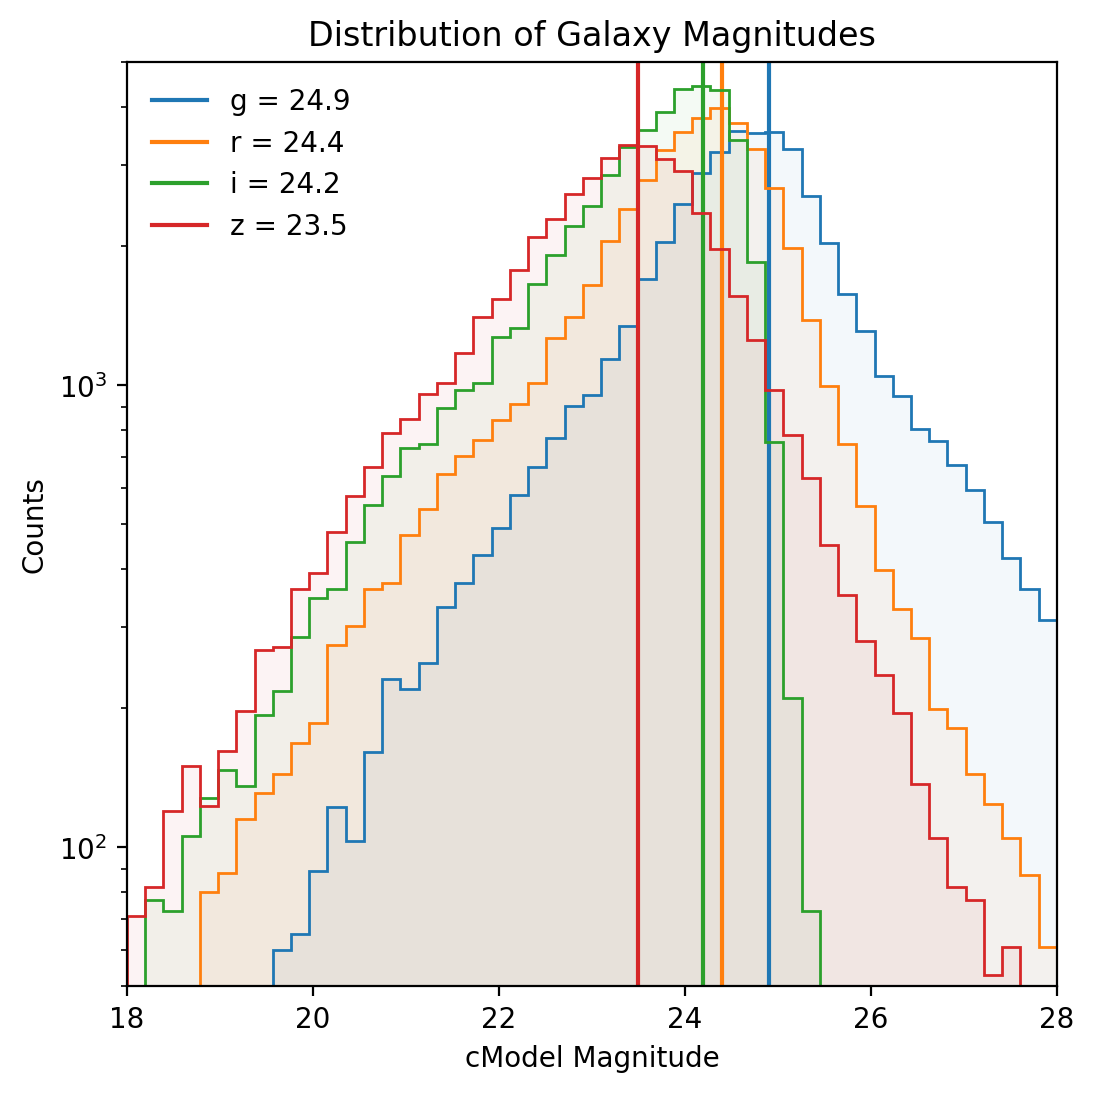

In [116]:
fig, ax = plt.subplots(ncols=1, figsize=(6,6))

near_table = table[np.logical_and(sep.deg < 0.5, table['refExtendedness']==1)]
cmap = cm.tab10
band_list = 'griz'
# band_lims = [25.3, 24.9, 24.5, 24.0]
band_lims = [24.9, 24.4, 24.2, 23.5]
for i in range(4):
    band = band_list[i]
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), bins=51, histtype='step');
    ax.hist(near_table[f'{band}_cModel_mag'], range=(18, 28), color=cmap(i), bins=51, histtype='stepfilled', alpha=0.05);
    ax.axvline(band_lims[i], ls='-', alpha=1, color=cmap(i), label=f'{band} = {band_lims[i]}')
ax.set_xlim(18, 28)
ax.set_ylim(5e1, 5e3)
ax.set_xlabel('cModel Magnitude')
ax.semilogy()
ax.legend(frameon=False, loc='upper left')
ax.set_ylabel("Counts", x=0.05)
ax.set_title("Distribution of Galaxy Magnitudes")
# plt.savefig('./figs/galaxy_dist.png', dpi=450)

### Red Sequence

We can identify the cluster members by plotting a color magnitude diagram 

2194


Text(0.5, 0.01, 'cModel $r$-mag')

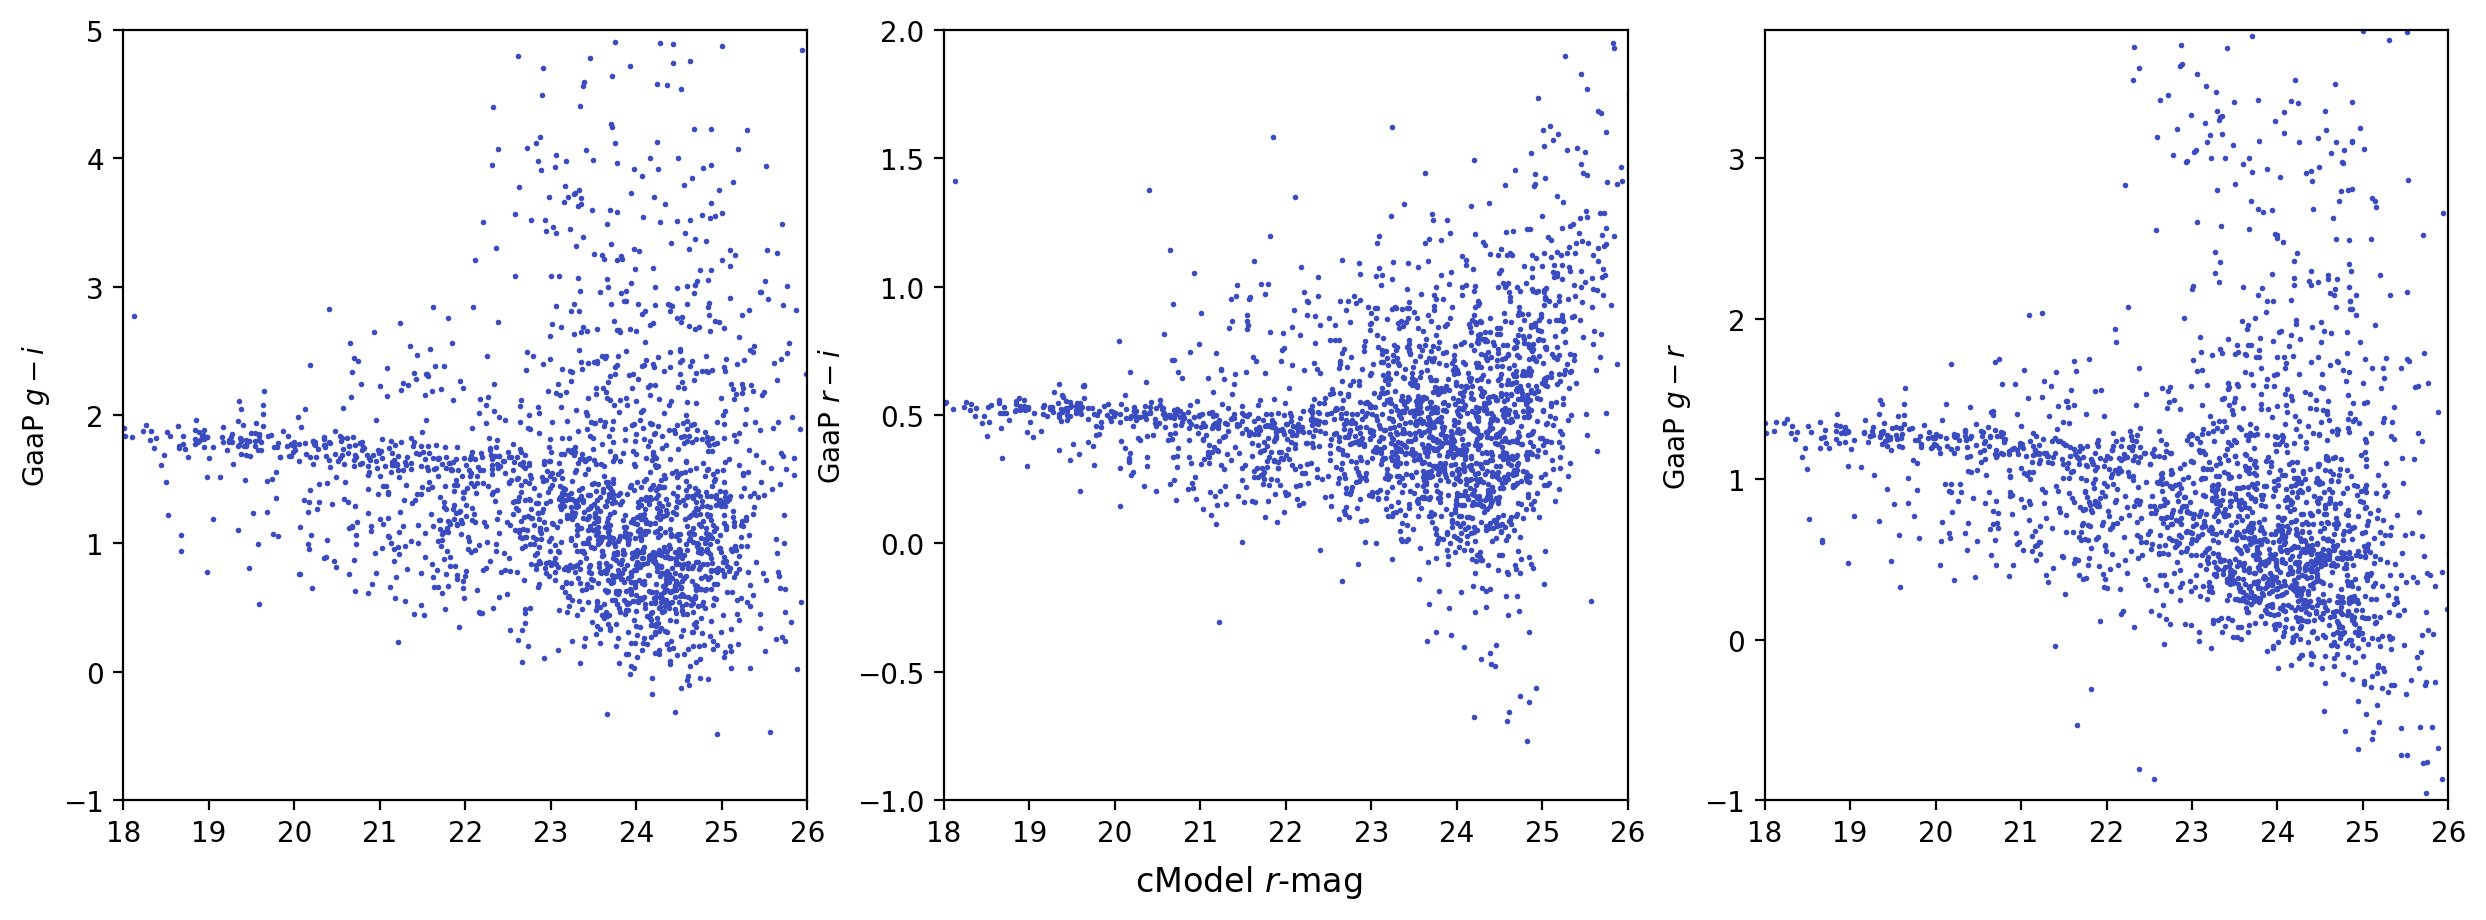

In [117]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5)) 

rs_table = table[np.logical_and(sep.deg < 0.1, table['refExtendedness']==1)]
print(len(rs_table))

color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
cmap = cm.coolwarm
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, color=cmap(0))
    # ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], c=rs_table['sep'], marker='.', s=4)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

fig.supxlabel(r"cModel $r$-mag")

In [118]:
# Fitting the redsequence by eye

gi_table_line = (table['r_cModel_mag'] - 18) * (-0.2/5) + 1.9
ri_table_line = (table['r_cModel_mag'] - 18) * (-0.1/5) + .55
gr_table_line = (table['r_cModel_mag'] - 18) * (-0.25/5) + 1.35

gi_lims = (0.1, -.25)
ri_lims = (0.04, -0.08)
gr_lims = (0.1, -.15)

In [119]:
gi_redseq = np.logical_and.reduce((table['gi'] < gi_table_line + gi_lims[0], table['gi'] > gi_table_line + gi_lims[1],
                                   table['r_cModel_mag'] < 28, table['r_cModel_mag'] > 18))
ri_redseq = np.logical_and.reduce((table['ri'] < ri_table_line + ri_lims[0], table['ri'] > ri_table_line + ri_lims[1],
                                   table['r_cModel_mag'] < 28, table['r_cModel_mag'] > 18))
gr_redseq = np.logical_and.reduce((table['gr'] < gr_table_line + gr_lims[0], table['gr'] > gr_table_line + gr_lims[1],
                                   table['r_cModel_mag'] < 28, table['r_cModel_mag'] > 18))


In [120]:
all_redseq = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))
table['all_redseq'] = all_redseq

In [121]:
# For individual colors we should add a magnitude limit since it's more likely for source galaxies to be located in at least one color

mag_lim = 23.5
table['gi_redseq'] = np.logical_and(gi_redseq, table['r_cModel_mag'] < mag_lim)
table['ri_redseq'] = np.logical_and(ri_redseq, table['r_cModel_mag'] < mag_lim)
table['gr_redseq'] = np.logical_and(gr_redseq, table['r_cModel_mag'] < mag_lim)

312 358 313


Text(0.5, 0.01, 'cModel $r$-mag')

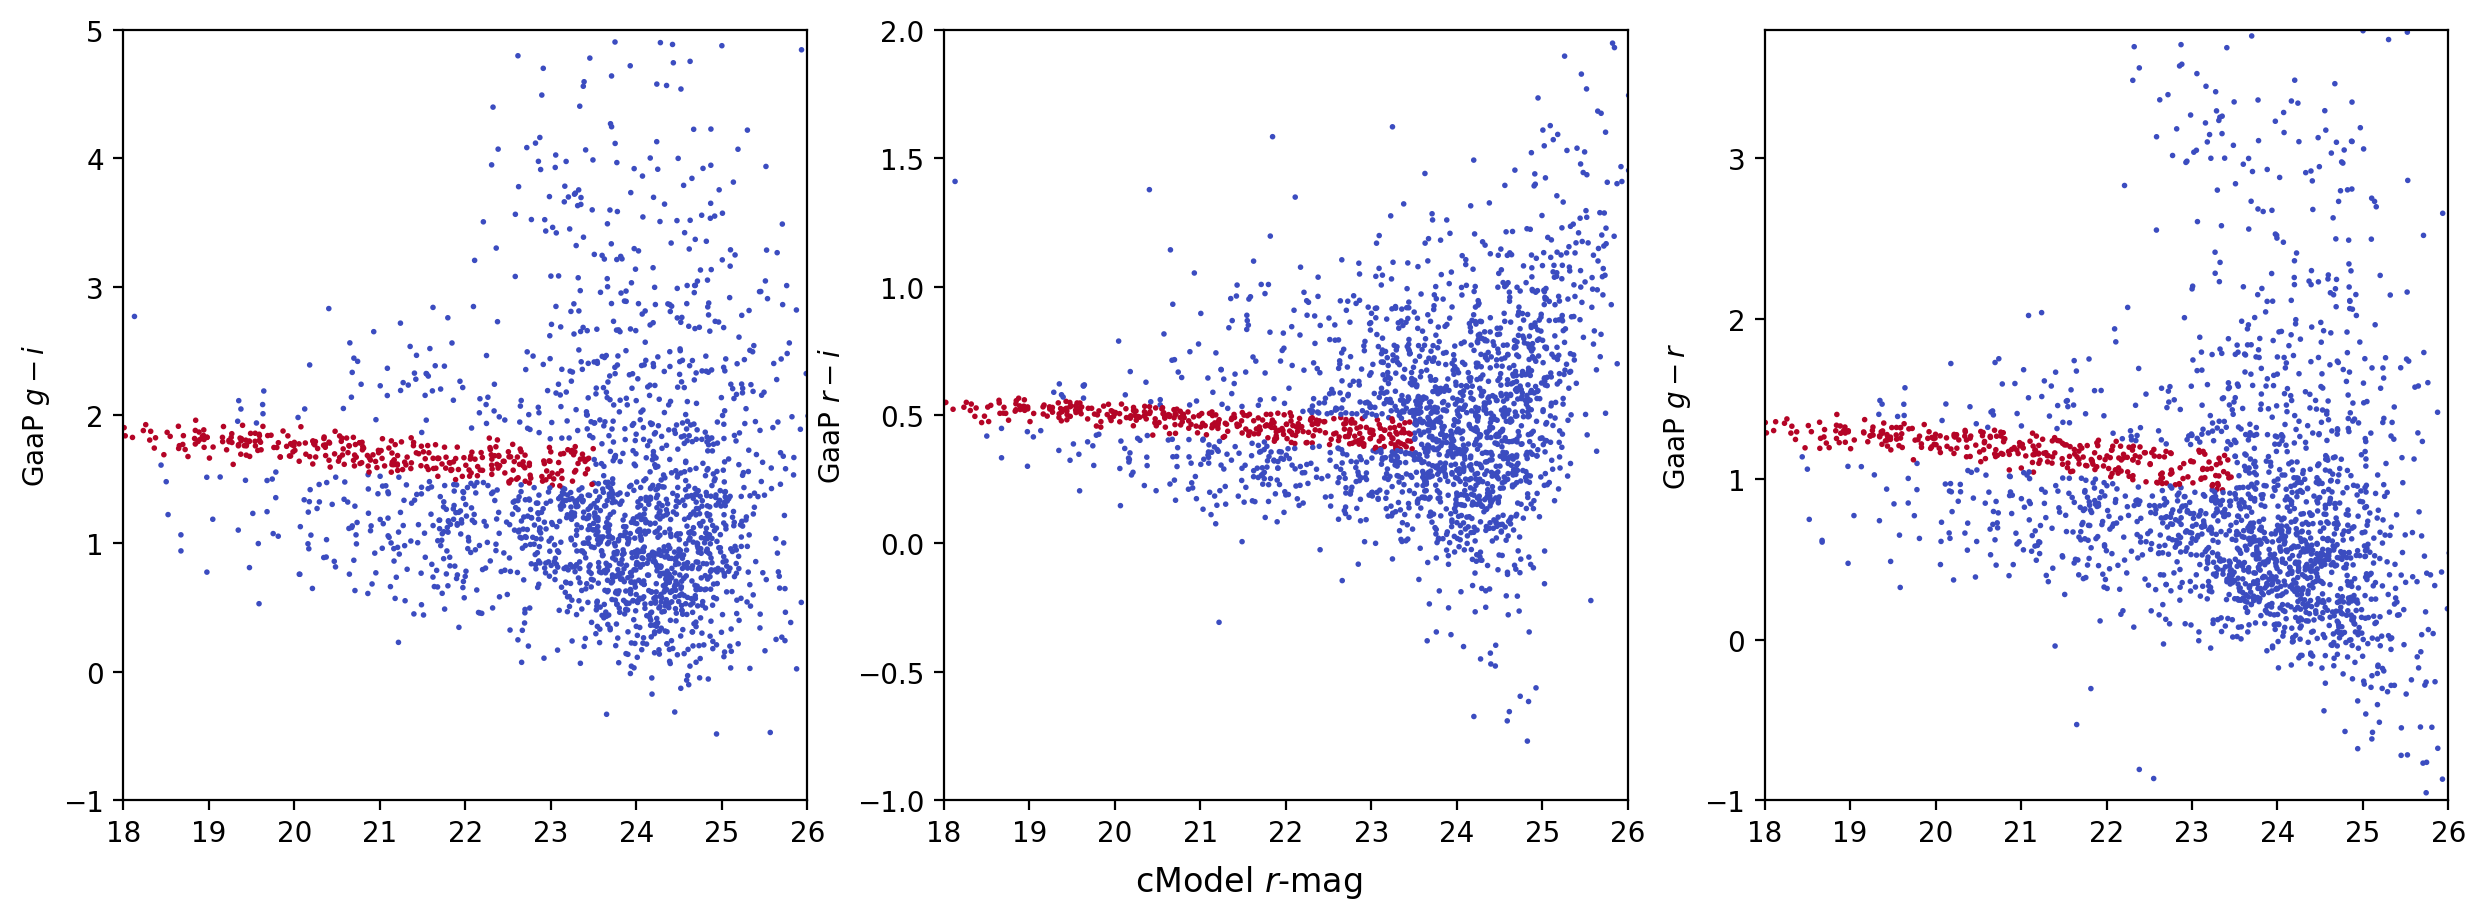

In [122]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(sep.deg < 0.1, table['refExtendedness']==1)]
print(np.sum(rs_table['gi_redseq']), np.sum(rs_table['ri_redseq']), np.sum(rs_table['gr_redseq']))
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, c=rs_table[f'{col}_redseq'], cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

221


Text(0.5, 0.01, 'cModel $r$-mag')

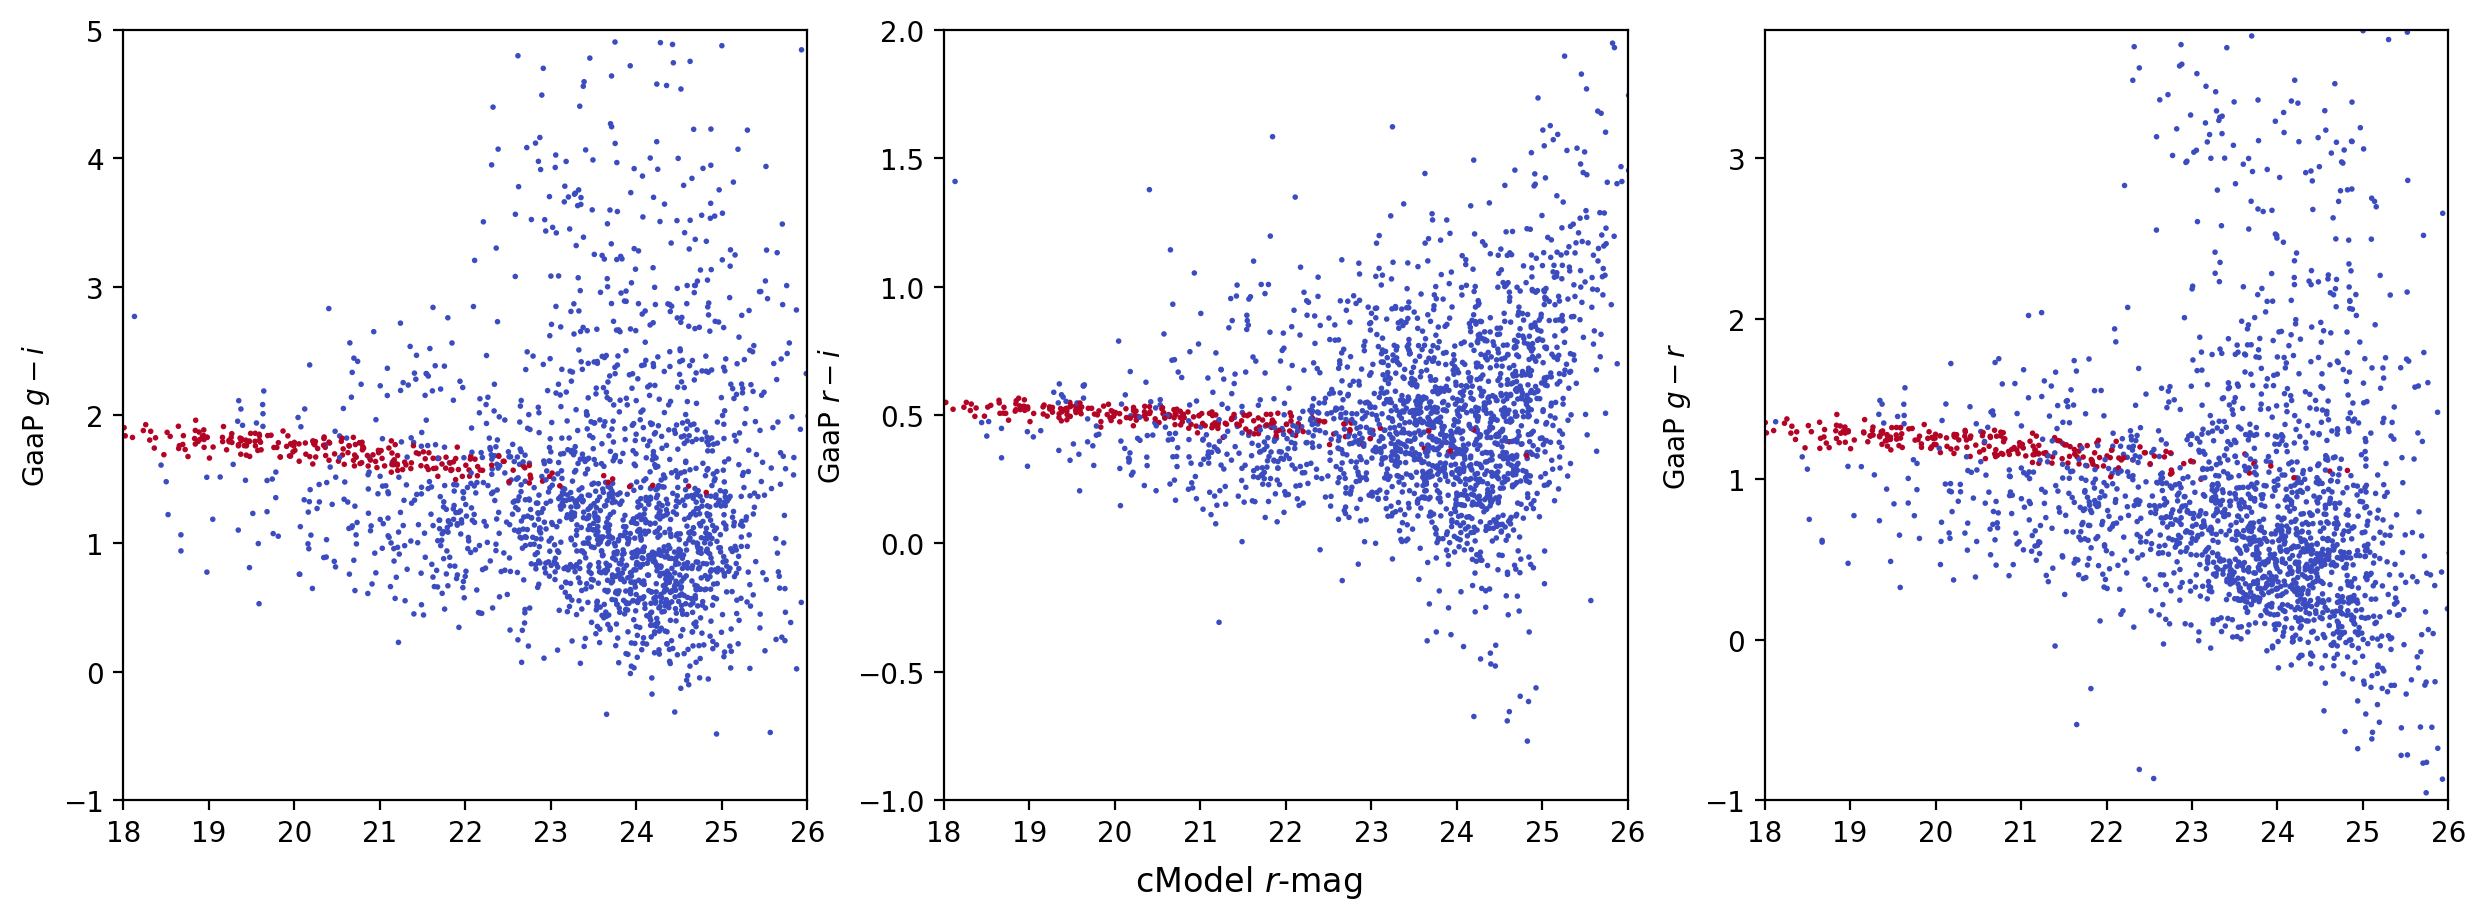

In [123]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = table[np.logical_and(sep.deg < 0.1, table['refExtendedness']==1)]
print(np.sum(rs_table['all_redseq']))
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModel_mag'], rs_table[col], marker='.', s=4, c=rs_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(f'GaaP {col_name[i]}')
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

In [124]:
Nobj = len(table)
Nrs = np.sum(table['all_redseq'])
print(Nrs, Nobj-Nrs)

1144 57532


In [125]:
# Apply cuts
cut_types = ['all', 'ri', 'gr', 'gi']
for ct in cut_types:
    filt = (table['refExtendedness'] >= 0.5)
    filt &= table['g_cModel_flag']== False
    filt &= table['r_cModel_flag']== False
    filt &= table['i_cModel_flag']== False
    filt &= (table['i_cModel_mag'] <= 24)
    filt &= (table['i_cModel_mag'] >= 20)
    filt &= (table['i_cModelFlux']/table['i_cModelFluxErr']) >= 10
    filt &= ~(table['i_hsmShapeRegauss_flag'])
    filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
    filt &= table['res'] >= 0.3
    filt &= table['i_blendedness'] <= 0.42
    filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
    filt &= table['i_iPSF_flag']==0
    filt &= ~(table[f'{ct}_redseq'])
    # filt &= ~prak_rs
    # filt &= table['fzb_z_median'] > .3
    print(f"After cuts: {np.sum(filt)}")
    source_table = table[filt]
    source_table.meta = {}
    source_table.write(f'cluster_data/technote/abell360_POSTCUTS_{ct}_DP1_new.fits', format="fits", overwrite=True)

After cuts: 20703
After cuts: 18907
After cuts: 19397
After cuts: 19480


In [127]:
weaklen_table = Table.read('cluster_data/technote/abell360_POSTCUTS_all_DP1_new.fits', format='fits')

### Photo-z Cuts

Another way for us to obtain the source sample is by removing objects that have $z \leq 0.22$ which we can do using photometric redshift estimates.
Here we load in both the point estimates and the $P(z)$ distributions for each object.

In [128]:
def get_pdfs(algo_type, filt):
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [154]:
# Get point estimates for the entire field (169034 objects)
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)
pz_ests = Table.from_pandas(pz_ests)

In [209]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for algo in method_list:
    zwidth = (pz_ests[f'{algo}_z_err68_high'] - pz_ests[f'{algo}_z_err68_low'])
    pz_ests[algo+'_diff'] = zwidth

In [202]:
# We could load this in via butler we did save this earlier :)
# This is the cleaned catalog that removed entries if any of the measurement algorithms failed.
# We have 58676
dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_new.fits', format="fits")
# dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

In [210]:
pz_table = join(dp1_catalog, pz_ests, keys='objectId')

In [211]:
# The P(z) PDFs are stored in a qp file which we can access via the get_pdfs function
# This contains the PDFs for all objects in the field which would be too much data to
# load in this notebook. We only want the PDFs for the objects that have passed our
# basic quality cuts.

clean_pz_ids = pz_table['objectId']
big_pz_filt = [k in clean_pz_ids for k in pz_ests['objectId']]

In [213]:
xs = np.linspace(0, 3, 301)

In [214]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 11444
On tpz we have 11280
On fzboost we have 11018
On knn we have 13285


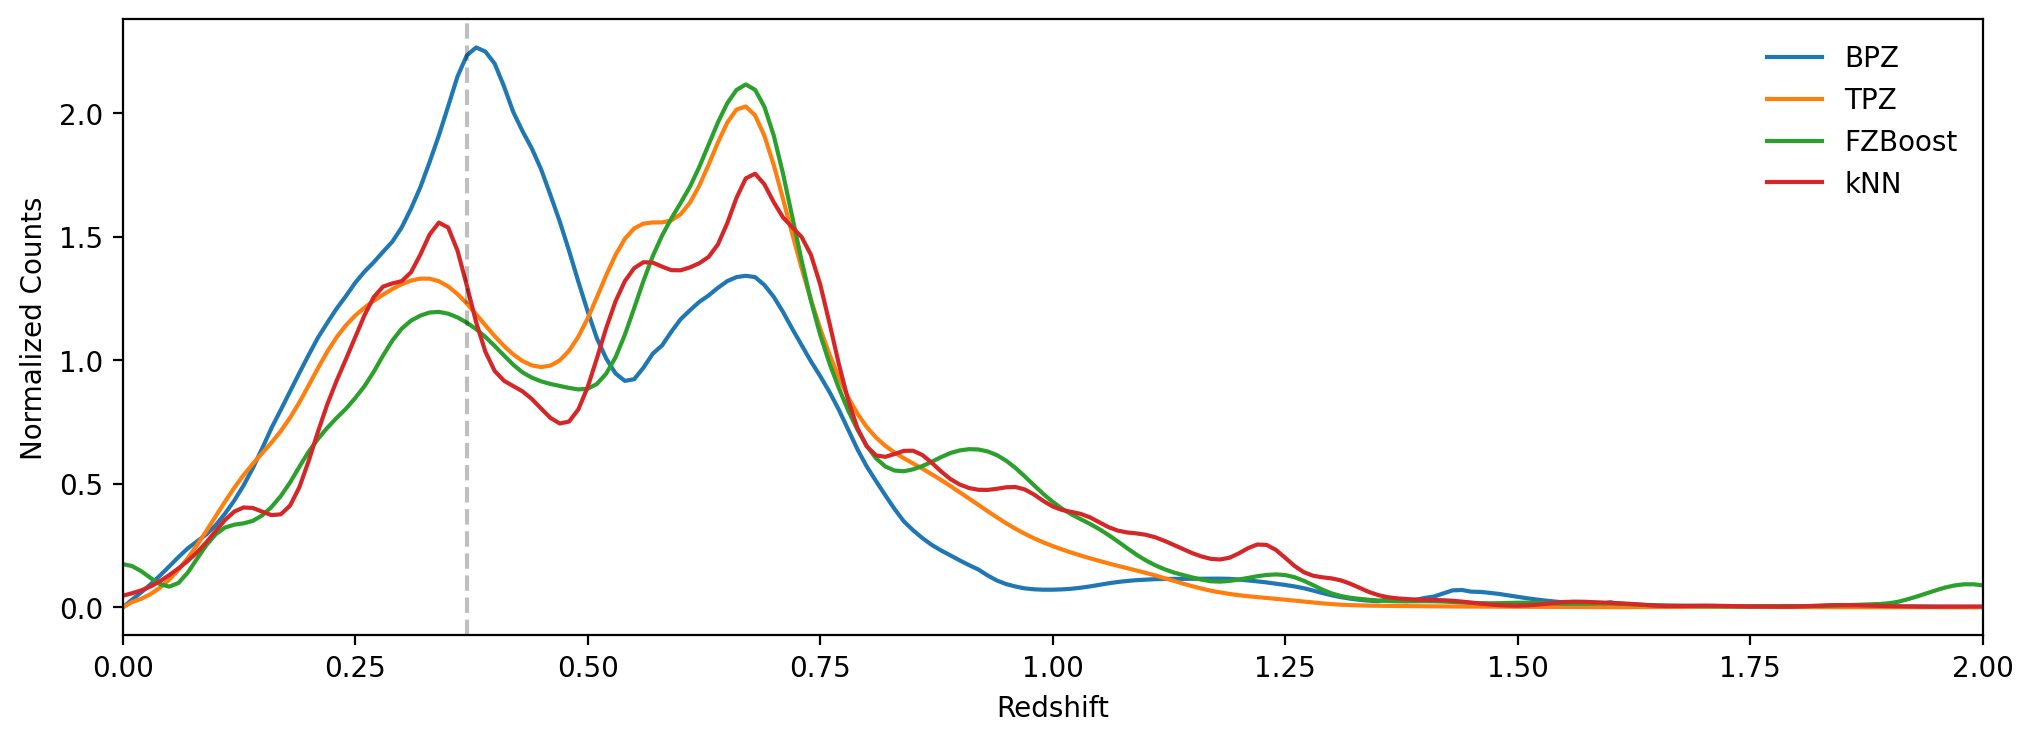

In [215]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

In [217]:
# Apply cuts

filt = (pz_table['refExtendedness'] >= 0.5)
filt &= pz_table['g_cModel_flag']== False
filt &= pz_table['r_cModel_flag']== False
filt &= pz_table['z_cModel_flag']== False
filt &= pz_table['i_cModel_flag']== False
filt &= (pz_table['i_cModel_mag'] <= 24)
filt &= (pz_table['i_cModelFlux']/pz_table['i_cModelFluxErr']) >= 10
filt &= ~(pz_table['i_hsmShapeRegauss_flag'])
filt &= ~np.isnan(pz_table['refExtendedness'])
filt &= (pz_table['i_hsmShapeRegauss_e1']**2 + pz_table['i_hsmShapeRegauss_e2']**2) <= 4
filt &= pz_table['res'] >= 0.3
filt &= (pz_table['i_cModel_mag'] >= 20)
filt &= pz_table['i_blendedness'] <= 0.42
filt &= (pz_table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < pz_table['i_hsmShapeRegauss_sigma'])
filt &= pz_table['i_iPSF_flag']==0

weaklen_table = pz_table[filt]
print(f"After cuts: {np.sum(filt)}")

After cuts: 17828


In [218]:
# True for objects that SHOULD be in the weak lensing catalog

wl_pz_ids = weaklen_table['objectId']
wl_pz_filt = np.array([k in wl_pz_ids for k in pz_ests['objectId']])

In [134]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
wl_pdfs = []

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'
    new_filt = np.logical_and.reduce((wl_pz_filt, pz_ests[f'{alg}_z_{central}'] > pz_cutoff, pz_ests[f'{alg}_diff'] < 0.25))
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)
    wl_pdfs.append(pdf)

On bpz we have 5555
On tpz we have 6186
On fzboost we have 6316
On knn we have 6220


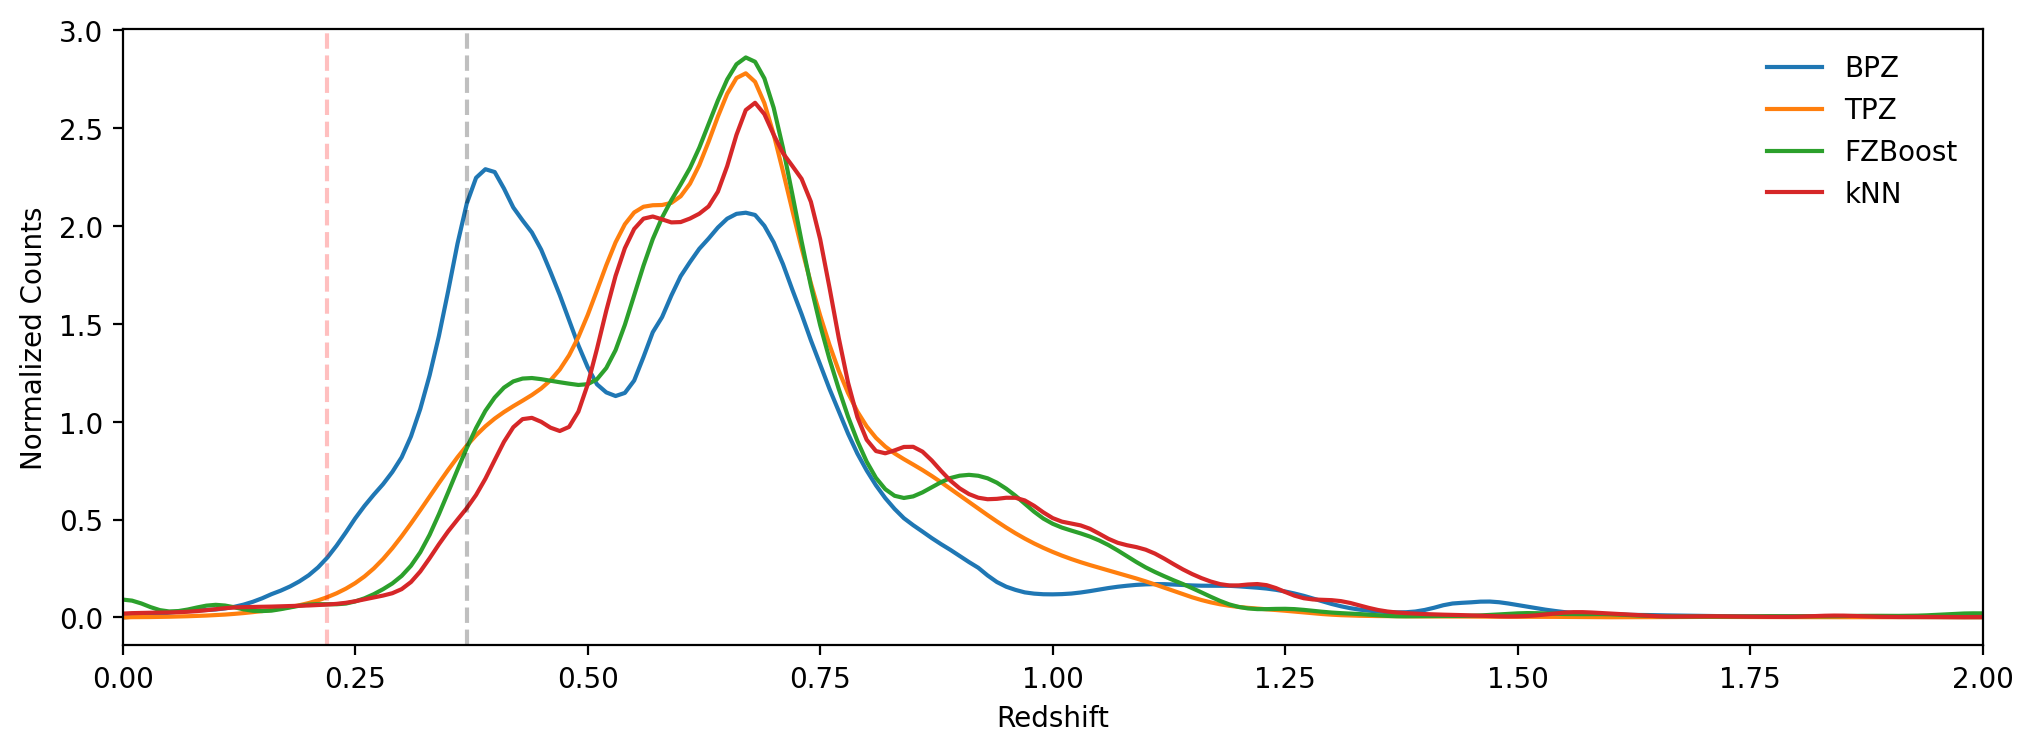

In [188]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, wl_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

In [191]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
# wl_pdfs = []

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'
    new_filt = np.logical_and.reduce((wl_pz_filt, pz_ests[f'{alg}_z_{central}'] > pz_cutoff, pz_ests[f'{alg}_diff'] < 0.25))
    print(f"On {alg} we have {np.sum(new_filt)}")
    # pdf, _, xs = get_pdfs(alg, new_filt)
    # wl_pdfs.append(pdf)

On bpz we have 5555
On tpz we have 6186
On fzboost we have 6316
On knn we have 6220


In [198]:
# Apply cuts
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff1 = 0.37
pz_cutoff2 = 0.65

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'

    filt = (pz_table['refExtendedness'] >= 0.5)
    filt &= pz_table['g_cModel_flag']== False
    filt &= pz_table['r_cModel_flag']== False
    filt &= pz_table['z_cModel_flag']== False
    filt &= pz_table['i_cModel_flag']== False
    filt &= (pz_table['i_cModel_mag'] <= 24)
    filt &= (pz_table['i_snr'] >= 10)
    filt &= ~(pz_table['i_hsmShapeRegauss_flag'])
    filt &= ~np.isnan(pz_table['refExtendedness'])
    filt &= (pz_table['i_hsmShapeRegauss_e1']**2 + pz_table['i_hsmShapeRegauss_e2']**2) <= 4
    filt &= pz_table['res'] >= 0.3
    filt &= pz_table['i_blendedness'] <= 0.42
    filt &= (pz_table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < pz_table['i_hsmShapeRegauss_sigma'])
    filt &= pz_table['i_iPSF_flag']==0
    filt &= (pz_table['i_cModel_mag'] >= 20)


    filt &= pz_table[f'{alg}_z_{central}'] > pz_cutoff1
    filt &= pz_table[f'{alg}_z_{central}'] > pz_cutoff2 # Change this from < to > when doing bin1 or bin2
    filt &= pz_table[f'{alg}_diff'] < 0.25
    # filt &= ~celine_rs
    # filt &= ~prak_rs
    # filt &= table['tpz_z_median'] > pc
    print(f"After cuts: {np.sum(filt)}")
    source_table = pz_table[filt]
    source_table.write(f'cluster_data/technote/shear-ratio_{alg}bin2_DP1.fits', format="fits", overwrite=True)

After cuts: 2084
After cuts: 2968
After cuts: 3458
After cuts: 3504


In [135]:
# fig, ax = plt.subplots(1, figsize=(12, 4))

# ax.plot(xs, bpz_n_wl, label='bpz')
# ax.plot(xs, tpz_n_wl, label='tpz')
# ax.plot(xs, fzb_n_wl, label='fzboost')
# ax.plot(xs, knn_n_wl, label='knn')
# ax.legend()
# ax.set_xlim(0, 2)
# ax.set_xlabel("Redshift")
# ax.set_ylabel("Normalized Counts")
# ax.set_title("N(z) with Quality Cuts + Weak Lensing Cuts")

In [136]:
from scipy.stats import gaussian_kde

In [137]:
sv_38_crossmatch = Table.read('/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/match_desi_withpz.pq')


In [138]:
z_true = sv_38_crossmatch['desi_z']

# Compute KDE on a grid once (since true z is the same for all panels)
z_grid = np.linspace(0, 3, 301)
kde = gaussian_kde(z_true, bw_method=0.15)  # adjust bw_method for smoother/sharper KDE
kde_values = kde(z_grid)

NameError: name 'bpz_n' is not defined

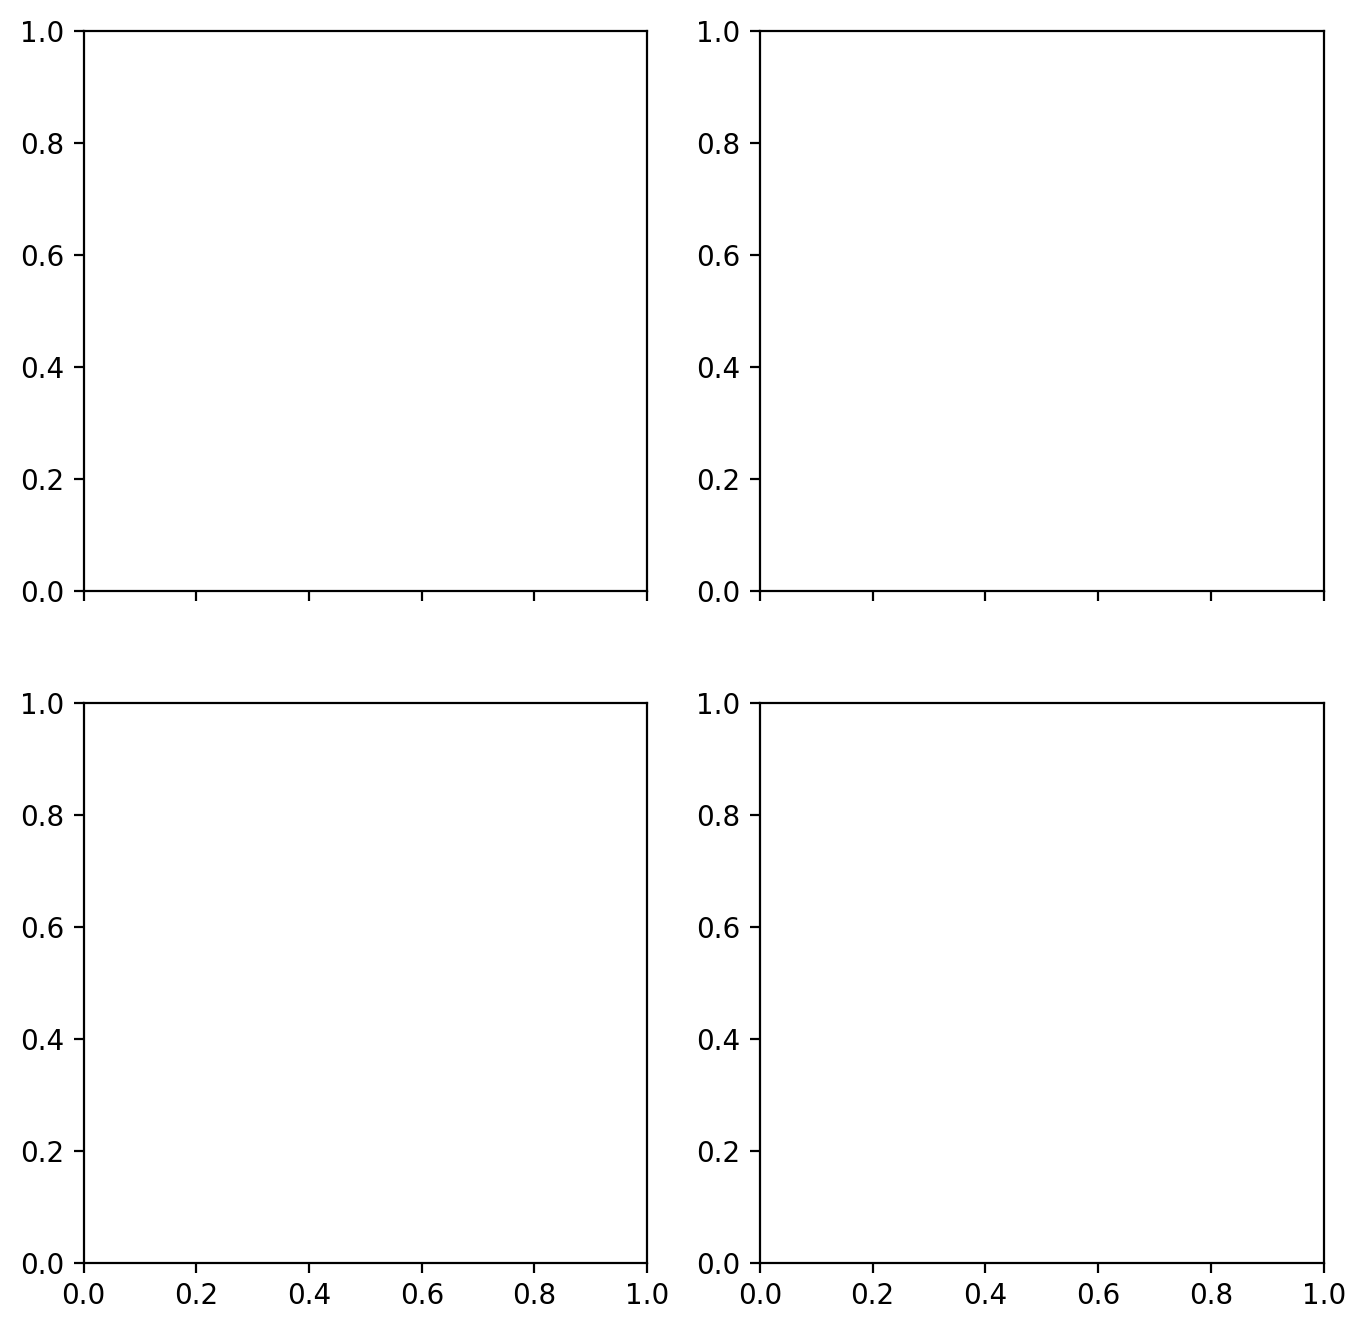

In [139]:
fig, ax = plt.subplots(2, 2, figsize=(8,8), sharex=True)

cmap = cm.coolwarm

ax[0,0].plot(xs, bpz_n, label='Quality Cuts', color=cmap(0.05))
ax[0,0].plot(xs, bpz_n_wl, label='Quality Cuts + WL', color=cmap(0.95))
ax[0,0].hist(weaklen_table['bpz_z_mean'], range=(0,3), bins=51, density=True, histtype='step', label='Median')
ax[0,0].set_title("BPZ")

ax[0,1].plot(xs, tpz_n, label='Quality Cuts', color=cmap(0.05))
ax[0,1].plot(xs, tpz_n_wl, label='Quality Cuts + WL', color=cmap(0.95))
ax[0,1].hist(weaklen_table['tpz_z_mean'], range=(0,3), bins=51, density=True, histtype='step', label='Median')
ax[0,1].set_title("TPZ")

ax[1,0].plot(xs, fzb_n, label='Quality Cuts', color=cmap(0.05))
ax[1,0].plot(xs, fzb_n_wl, label='Quality Cuts + WL', color=cmap(0.95))
ax[1,0].hist(weaklen_table['fzboost_z_mean'], range=(0,3), bins=51, density=True, histtype='step', label='Median')
ax[1,0].set_title("FZB")

ax[1,1].plot(xs, knn_n, label='Quality Cuts', color=cmap(0.05))
ax[1,1].plot(xs, knn_n_wl, label='Quality Cuts + WL Cuts', color=cmap(0.95))
ax[1,1].hist(weaklen_table['knn_z_median'], range=(0,3), bins=51, density=True, histtype='step', label='Median')
ax[1,1].set_title("knn")

for aa in ax:
    for xx in aa:
        xx.set_xlim(0, 3)
        xx.plot(z_grid, kde_values, color='C1', label='True KDE', linewidth = 2)
        xx.axvline(0.22, color='k', ls='--', alpha=0.2)

fig.supxlabel("Redshift")
fig.supylabel("Normalized Counts")
fig.suptitle("$N(z)$ with Cuts", y=0.92)

# handles, labels = ax[0, 0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='upper right', fontsize=12)
ax[0,0].legend(frameon=False)


In [163]:
s_ids = sv_38_crossmatch['objectId']
desi_filt = [k in s_ids for k in pz_ests['objectId']]

In [166]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

method_quality = []
method_wl = []

for method in method_list:
    quality, _, xs = get_pdfs(method, np.logical_and(big_pz_filt, desi_filt))
    wl, _, _ = get_pdfs(method, np.logical_and(wl_pz_filt, desi_filt))
    method_quality.append(quality)
    method_wl.append(wl)


# method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

# method_desi = []

# for method in method_list:
#     desi_pdf, _, xs = get_pdfs(method, desi_filt)
#     method_desi.append(desi_pdf)


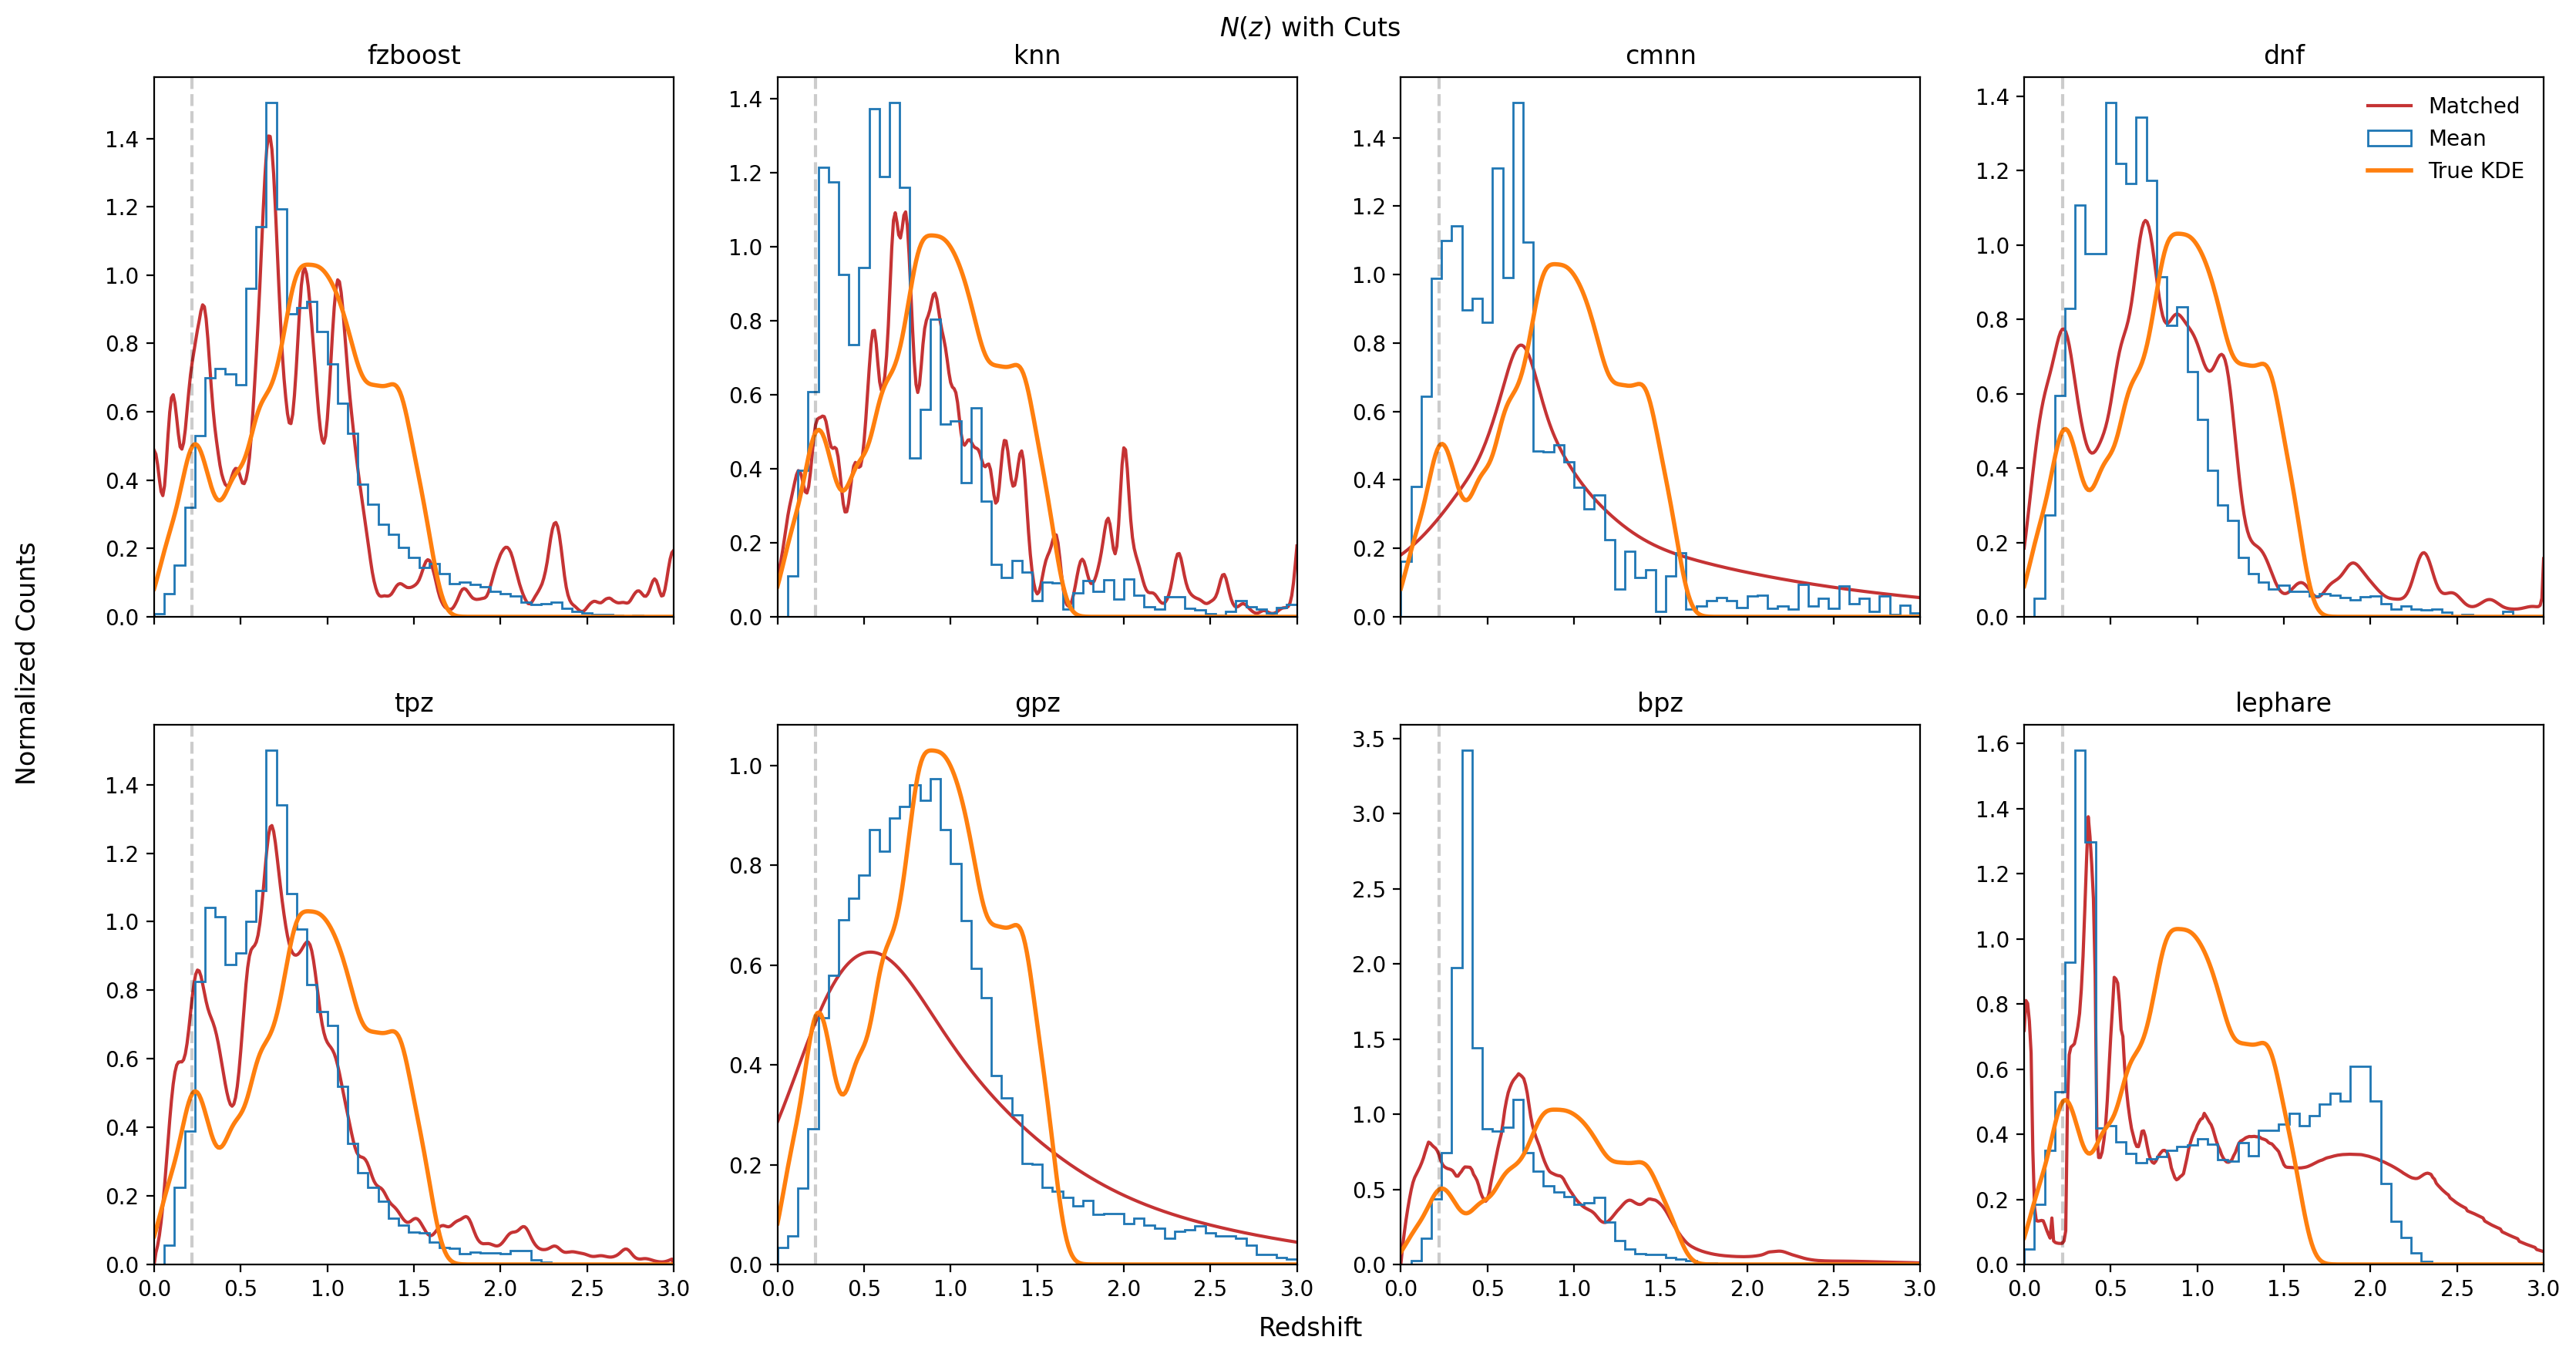

In [165]:

fig, axes = plt.subplots(2, 4, figsize=(20, 10), sharex=True)

cmap = cm.coolwarm

for i,method in enumerate(method_list):
    ix = i//4
    iy = i%4
    
    # quality, _, xs = get_pdfs(method, big_pz_filt)
    # wl, _, _ = get_pdfs(method, wl_pz_filt)
    # quality = method_quality[i]
    # wl = method_wl[i]

    axes[ix, iy].plot(xs, quality, label='Quality Cuts', color=cmap(0.05))
    axes[ix, iy].plot(xs, wl, label='Quality Cuts + WL', color=cmap(0.95))
    # axes[ix, iy].plot(xs, method_desi[i], label='Matched', color=cmap(0.95))
    if method=='knn':
        axes[ix, iy].hist(weaklen_table[f'{method}_z_median'], range=(0,3), bins=51, density=True, histtype='step', label='Median')
    else:
        axes[ix, iy].hist(weaklen_table[f'{method}_z_mean'], range=(0,3), bins=51, density=True, histtype='step', label='Mean')
    axes[ix, iy].set_title(method)
    axes[ix,iy].set_xlim(0, 3)
    axes[ix,iy].plot(z_grid, kde_values, color='C1', label='True KDE', linewidth = 2)
    axes[ix,iy].axvline(0.22, color='k', ls='--', alpha=0.2)

fig.supxlabel("Redshift", y=0.06)
fig.supylabel("Normalized Counts", x=0.08)
fig.suptitle("$N(z)$ with Cuts", y=0.92)
axes[0,3].legend(frameon=False)

#### Red Sequence Redshifts and N(z)s

In [254]:
def good_width(algo, table, central='mean'):
    # zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])/(table[f'{algo}_z_{central}'])
    zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])
    return zwidth

In [308]:
pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/output_estimate_knn.hdf5')


In [314]:
kale = pdfs[:13].pdf(xs)

In [324]:
from scipy.integrate import trapezoid

In [328]:
trapezoid(kale[], xs)

np.float64(0.4630443542930006)

In [322]:
np.sum(xs * kale[2])

np.float64(22.129671126713383)

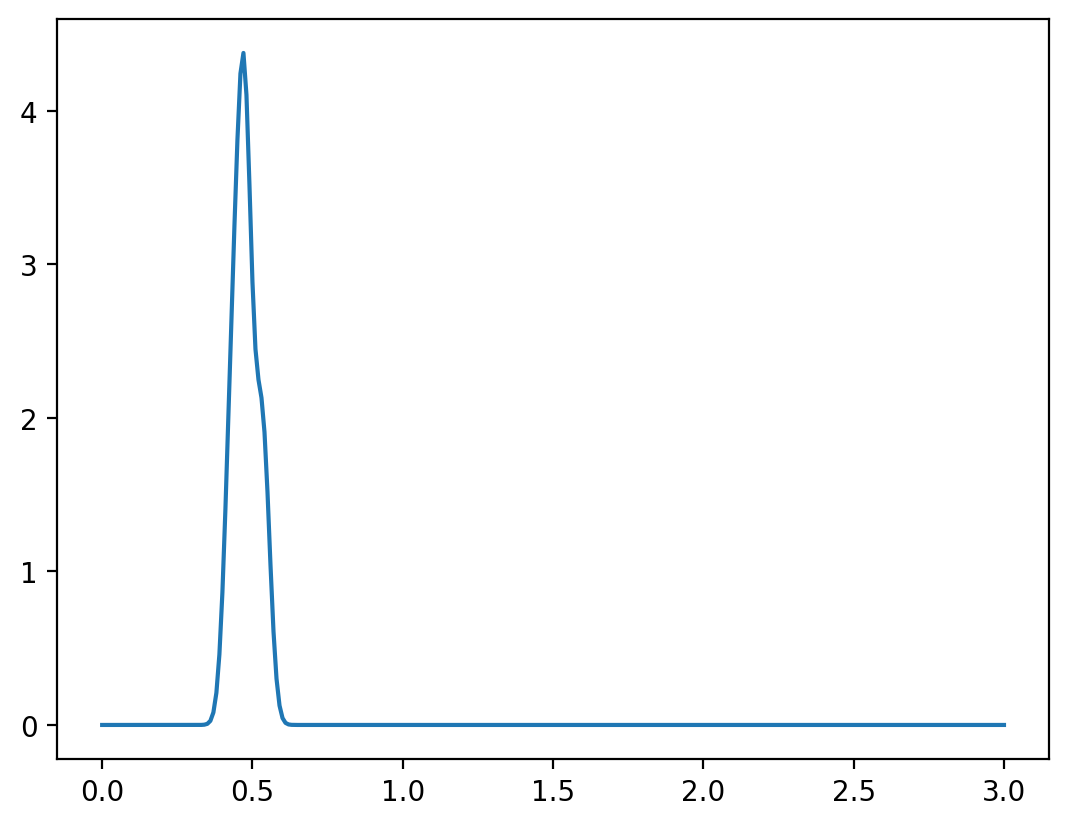

In [320]:
plt.plot(xs, kale[2])

In [255]:
def get_pdfs(algo_type, filt):
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [266]:
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)
pz_ests = Table.from_pandas(pz_ests)

In [267]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz', 'lephare']

for ml in method_list:
    if ml=='knn':
        zwidth = good_width(ml, pz_ests, central='median')
    else:
        zwidth = good_width(ml, pz_ests, central='mean')

    pz_ests[ml+'_diff'] = zwidth

In [272]:
dp1_catalog = Table.read('cluster_data/abell360_PRECUTS_DP1_gaap_cModel.fits', format="fits")

In [273]:
table = join(dp1_catalog, pz_ests, keys='objectId')

In [274]:
c1 = SkyCoord(table['coord_ra']*u.deg, table['coord_dec']*u.deg)
c2 = SkyCoord(cluster_coords[0]*u.deg, cluster_coords[1]*u.deg)
sep = c1.separation(c2)
table['sep'] = sep.deg

In [275]:
clean_filt = np.logical_and.reduce((~table['i_iPSF_flag'], ~table['i_hsmShapeRegauss_flag'], ~np.isnan(table['refExtendedness']), table['sep'] < 0.5,
                                    ~table['g_cModel_flag'], ~table['r_cModel_flag'], ~table['i_cModel_flag'], ~table['z_cModel_flag']))
table = table[clean_filt]

In [276]:
table['i_snr'] = table['i_cModelFlux']/table['i_cModelFluxErr']

In [277]:
# Apply cuts
filt = (table['refExtendedness'] >= 0.5)
filt &= table['sep'] < 0.5
filt &= table['g_cModel_flag']== False
filt &= table['r_cModel_flag']== False
filt &= table['z_cModel_flag']== False
filt &= table['i_cModel_flag']== False
# filt &= (table['i_cModel_mag'] <= 24)
# filt &= (table['i_snr'] >= 10)
filt &= ~(table['i_hsmShapeRegauss_flag'])
filt &= ~np.isnan(table['refExtendedness'])
# filt &= (table['i_hsmShapeRegauss_e1']**2 + table['i_hsmShapeRegauss_e2']**2) <= 4
# filt &= table['res'] >= 0.3
# filt &= table['i_blendedness'] <= 0.42
# filt &= (table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < table['i_hsmShapeRegauss_sigma'])
filt &= table['i_iPSF_flag']==0
# filt &= ~celine_rs
# filt &= ~prak_rs
# filt &= table['fzb_z_median'] > .3
print(f"After cuts: {np.sum(filt)}")

After cuts: 33503


In [278]:
pz_table = table[filt]

In [279]:
pz_table.add_index('objectId')

In [280]:
pz_table['gi'] = pz_table['g_gaap_mag'] - pz_table['i_gaap_mag']
pz_table['gr'] = pz_table['g_gaap_mag'] - pz_table['r_gaap_mag']
pz_table['ri'] = pz_table['r_gaap_mag'] - pz_table['i_gaap_mag']

In [281]:
mag_lim = 24

In [282]:
gi_table_line = (pz_table['r_cModel_mag'] - 18) * (-0.2/5) + 1.9
ri_table_line = (pz_table['r_cModel_mag'] - 18) * (-0.1/5) + .55
gr_table_line = (pz_table['r_cModel_mag'] - 18) * (-0.25/5) + 1.35

gi_lims = (0.1, -.25)
ri_lims = (0.04, -0.08)
gr_lims = (0.1, -.15)

In [283]:
gi_redseq = np.logical_and.reduce((pz_table['gi'] < gi_table_line + gi_lims[0], pz_table['gi'] > gi_table_line + gi_lims[1], pz_table['r_cModel_mag'] < mag_lim))
ri_redseq = np.logical_and.reduce((pz_table['ri'] < ri_table_line + ri_lims[0], pz_table['ri'] > ri_table_line + ri_lims[1], pz_table['r_cModel_mag'] < mag_lim))
gr_redseq = np.logical_and.reduce((pz_table['gr'] < gr_table_line + gr_lims[0], pz_table['gr'] > gr_table_line + gr_lims[1], pz_table['r_cModel_mag'] < mag_lim))


In [284]:
pz_table['gi_redseq'] = gi_redseq
pz_table['ri_redseq'] = ri_redseq
pz_table['gr_redseq'] = gr_redseq
pz_table['all_redseq'] = np.logical_and.reduce((gi_redseq, ri_redseq, gr_redseq))

In [285]:
# fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

# plot_table = pz_table[pz_table['refExtendedness']==1]
# cmap = cm.coolwarm
# color_names = ['gi', 'ri', 'gr']
# col_name = ['$g-i$', '$r-i$', '$g-r$']
# for i in range(3):
#     col = color_names[i]
#     ax[i].scatter(plot_table['r_cModel_mag'], plot_table[col], marker='.', s=4, c=plot_table[f'all_redseq'], cmap=cmap)
#     ax[i].set_ylabel(col_name[i])
#     ax[i].set_xlim(18, 26)

# ax[0].set_ylim(-1, 5)
# ax[1].set_ylim(-1, 2)
# ax[2].set_ylim(-1, 3.8)
# fig.supxlabel(r"cModel $r$-mag")

In [286]:
pzo = pz_ests['objectId']

clean_pz_ids = pz_table['objectId']
big_pz_filt = [k in clean_pz_ids and pz_table.loc[k]['all_redseq'] for k in pzo]

xs = np.linspace(0, 3, 301)

In [287]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 0.25)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 784
On tpz we have 751
On fzboost we have 618
On knn we have 621


In [307]:
quality_pdfs[0].sum()

np.float64(100.0061047855289)

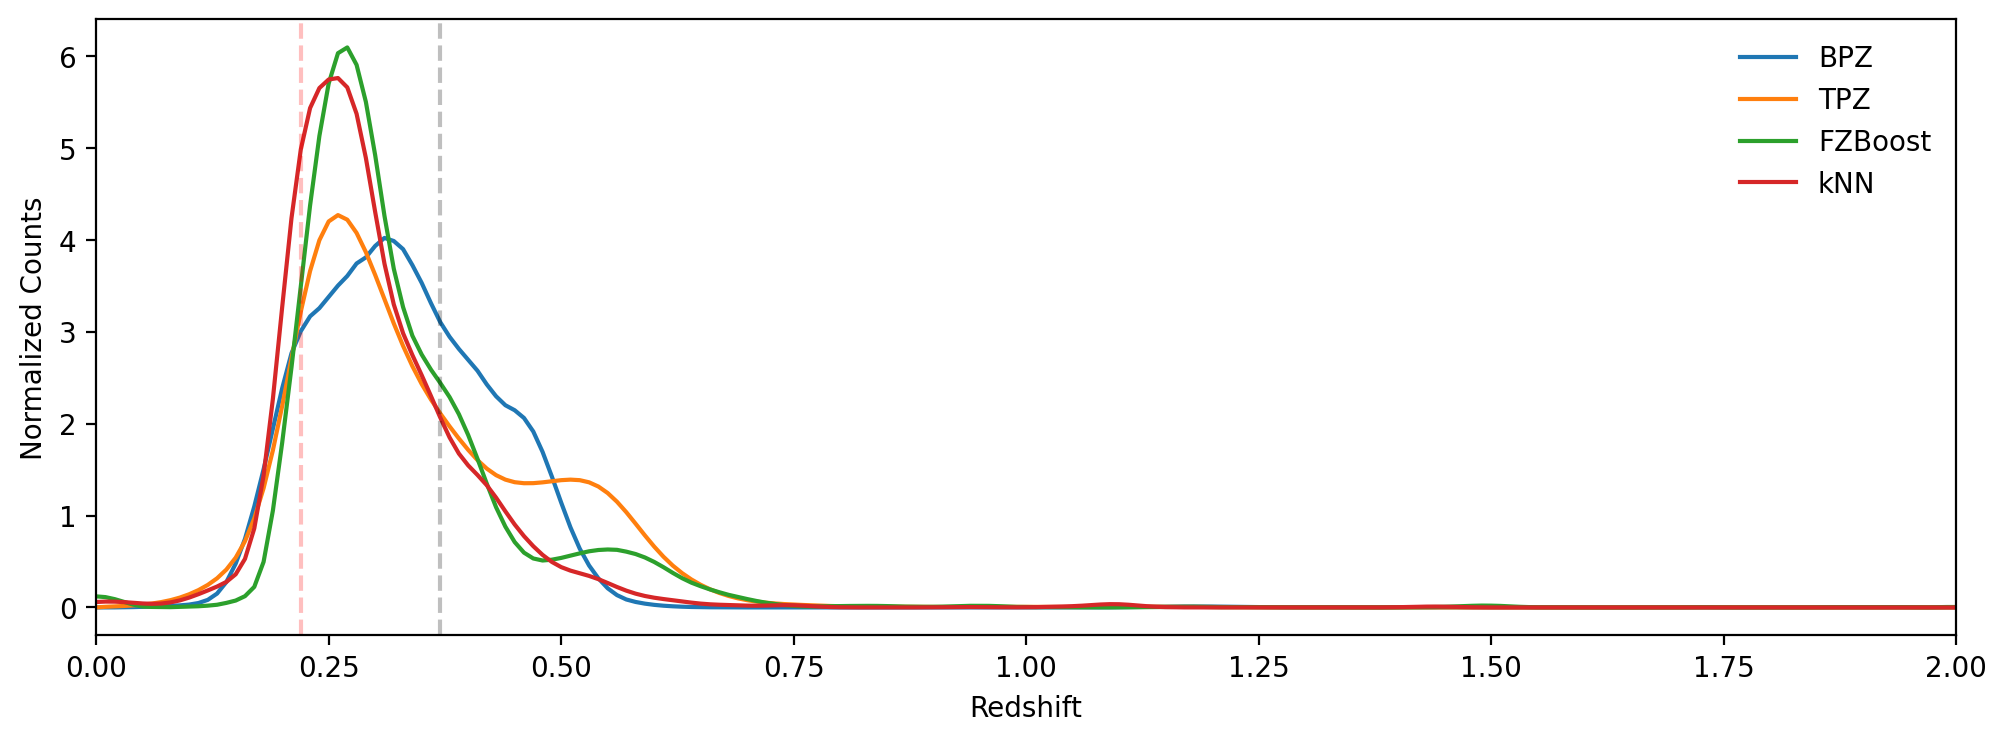

In [288]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

In [289]:
color_cut_nz = Table.read('./cluster_data/technote/abell360_POSTCUTS_all_DP1_new.fits')

In [329]:
pzo = pz_ests['objectId']

# clean_pz_ids = pz_table['objectId']
# big_pz_filt = [k in clean_pz_ids and pz_table.loc[k]['all_redseq'] for k in pzo]

clean_pz_ids = color_cut_nz['objectId']
big_pz_filt = [k in clean_pz_ids for k in pzo]

xs = np.linspace(0, 3, 301)

In [330]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
quality_pdfs = []

for alg in pz_algs:
    new_filt = np.logical_and(big_pz_filt, pz_ests[f'{alg}_diff'] < 20.25)#, pz_table['all_redseq']==True)
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs(alg, new_filt)

    # pdf, _, xs = get_pdfs(alg, big_pz_filt)
    quality_pdfs.append(pdf)

On bpz we have 17319
On tpz we have 17319
On fzboost we have 17319
On knn we have 17319


In [331]:
quality_pdfs = np.array(quality_pdfs)

In [303]:
quality_pdfs.shape

(4, 301)

In [376]:
np.save('cluster_data/technote/nz/colorcuts_nz_noquality.npy', quality_pdfs)

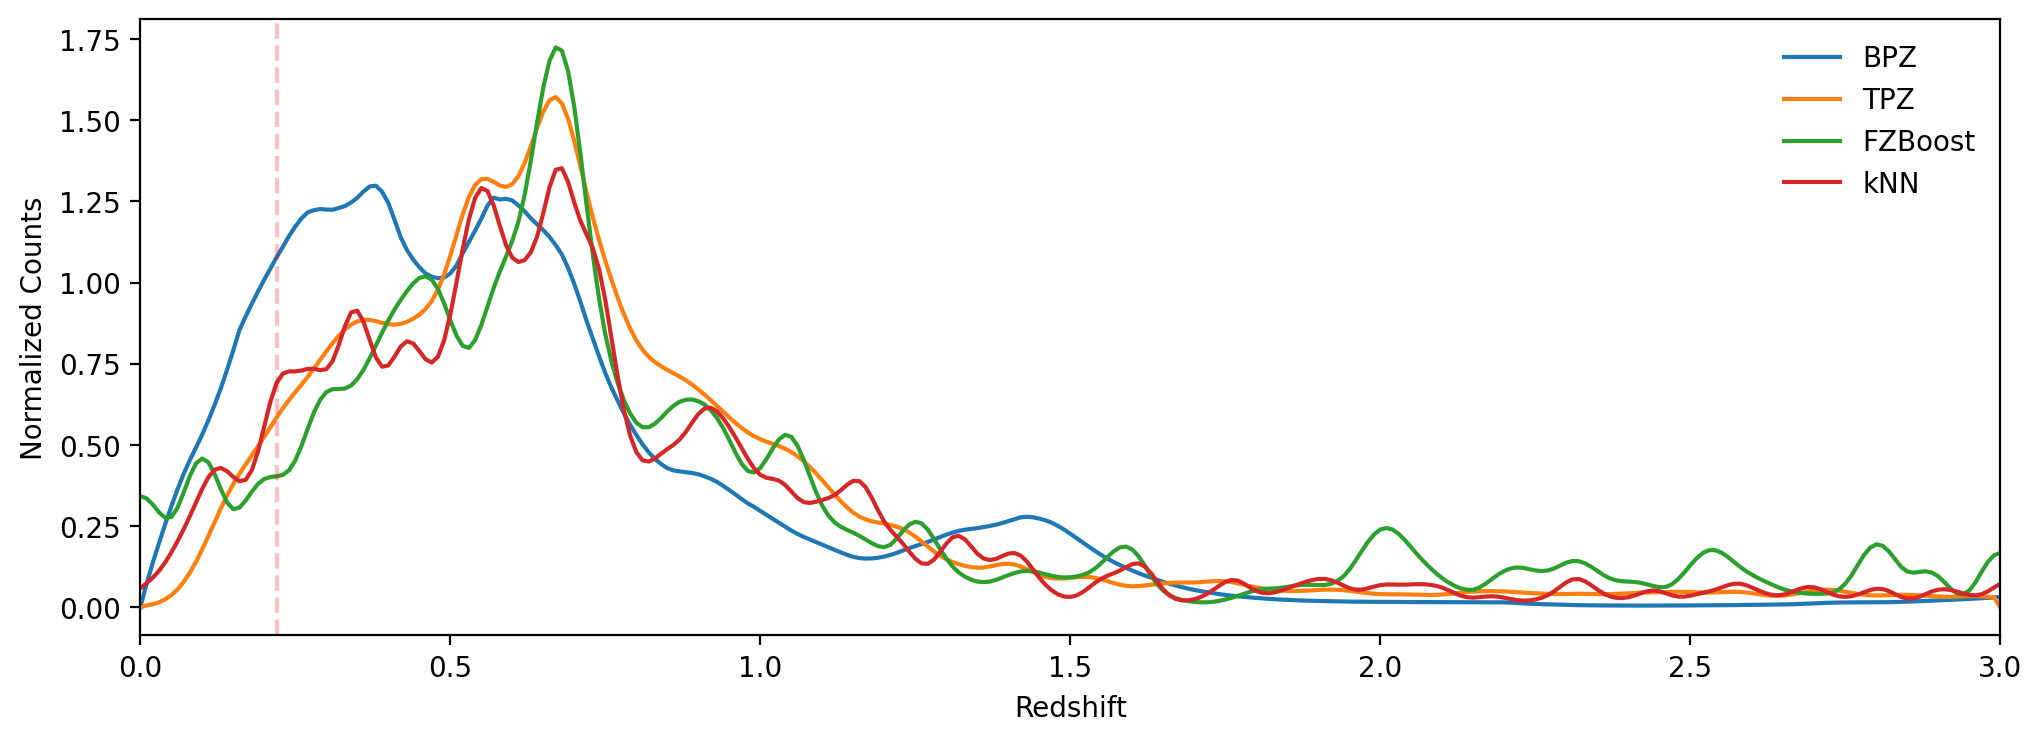

In [333]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 3)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

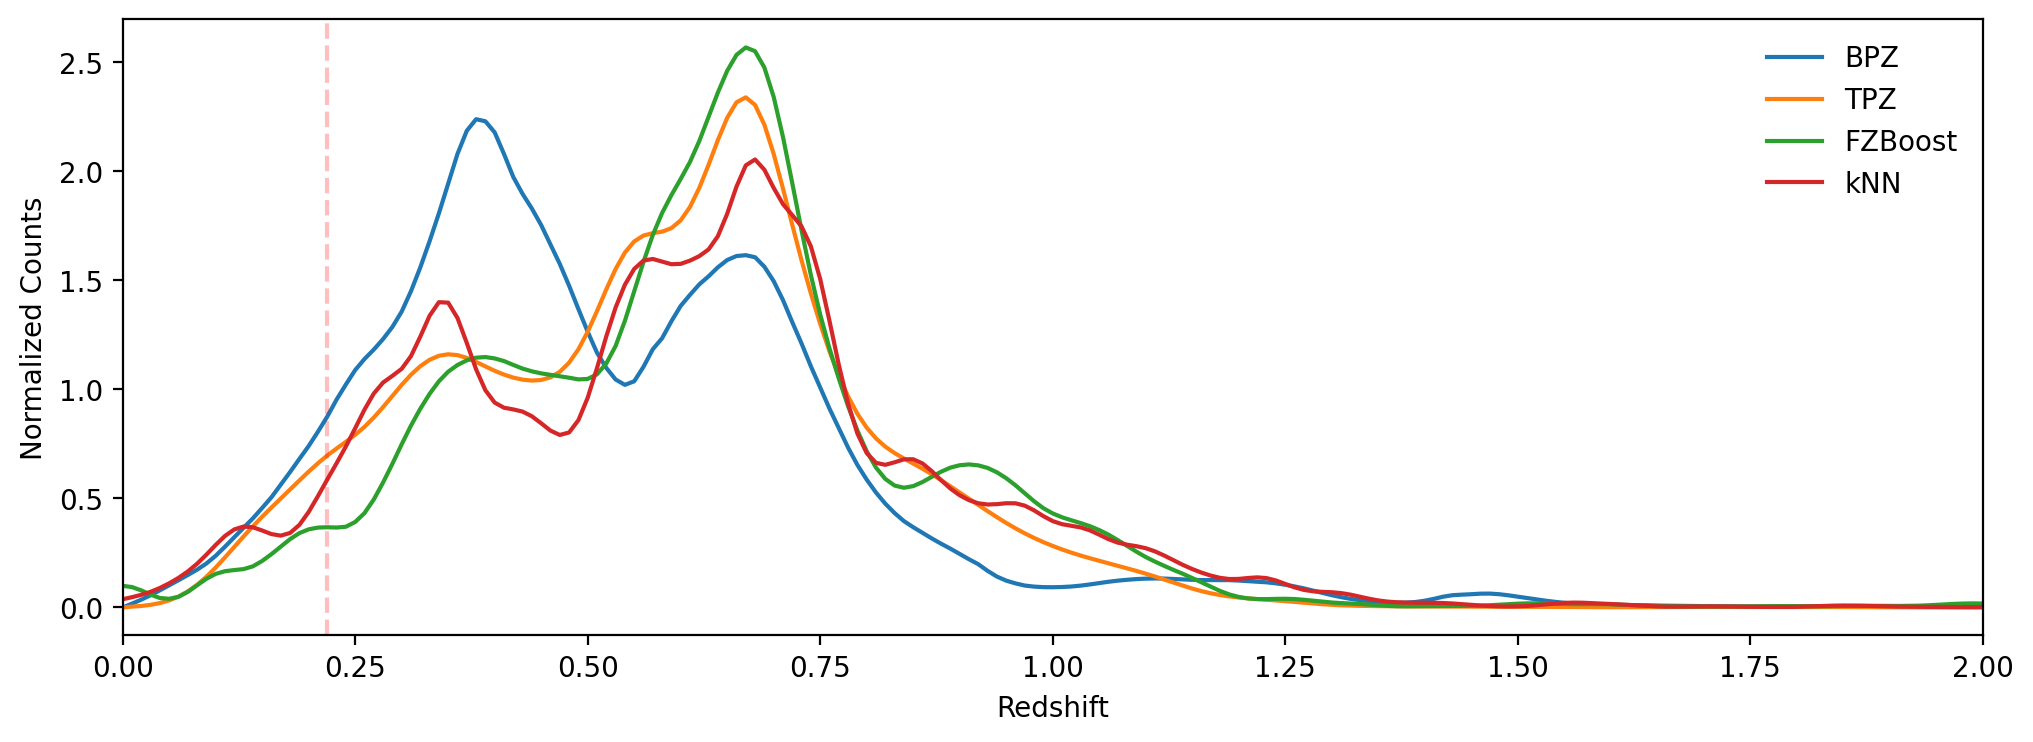

In [292]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

## Color-Cuts N(z)

In [166]:
def get_pdfs_nz(algo_type, filt):
    xs = np.linspace(0, 3, 301)
    # pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize/dp1_6band/output_estimate_{algo_type}.hdf5')
    pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize_4band/dp1_sv38/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [167]:
def good_width(algo, table, central='mean'):
    # zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])/(table[f'{algo}_z_{central}'])
    zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])
    return zwidth

In [141]:
fields = ['all', 'ECDFS', 'EDFS', 'Rubin_SV_095-25', 'Rubin_SV_38_7']
pz_fileloc_sample = f'/sdf/data/rubin/shared/pz/data/on_sky/dp1_v29.0.0_gold_{fields[-1]}.hdf5'

In [142]:
bands = list('ugrizy')
cModel_mags = [b+'_cModelMag' for b in bands]
gaap_mags = [b+'_gaap1p0Mag' for b in bands]

In [143]:
pz_match_cols = ['objectId', 'coord_ra', 'coord_dec'] + cModel_mags + gaap_mags
pz_match_data = []

with h5py.File(pz_fileloc_sample, "r") as f:
    # print("Keys: %s" % f.keys())

    for c in pz_match_cols:
        data = f[c][()]
        pz_match_data.append(data)

In [144]:
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)

In [145]:
pz_ests = Table.from_pandas(pz_ests)
pz_ests.add_index('objectId')

In [146]:
pz_match_table = Table(pz_match_data, names=pz_match_cols)
pz_match_table.add_index('objectId')

In [147]:
full_pz_table = join(pz_ests, pz_match_table)

In [156]:
gal_pz = join(full_pz_table, weaklen_table, keys='objectId')

In [158]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz']

for ml in method_list:
    if ml=='knn':
        zwidth = good_width(ml, full_pz_table, central='median')
    else:
        zwidth = good_width(ml, full_pz_table, central='mean')

    full_pz_table[ml+'_diff'] = zwidth

In [165]:
gal_pz_oid = gal_pz['objectId'] # The ids of the rows of the qp files
full_pz_id = full_pz_table['objectId']
gal_nz_filt = [fpz in gal_pz_oid for fpz in full_pz_id]

In [174]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
cc_nz_pdfs = []

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'
    new_filt = np.logical_and.reduce((gal_nz_filt, full_pz_table[f'{alg}_diff'] < 0.15))
    print(f"On {alg} we have {np.sum(new_filt)}")
    if np.sum(new_filt)==0:
        break
    pdf, _, xs = get_pdfs_nz(alg, new_filt)
    cc_nz_pdfs.append(pdf)

On bpz we have 3197
On tpz we have 3336
On fzboost we have 5730
On knn we have 5714


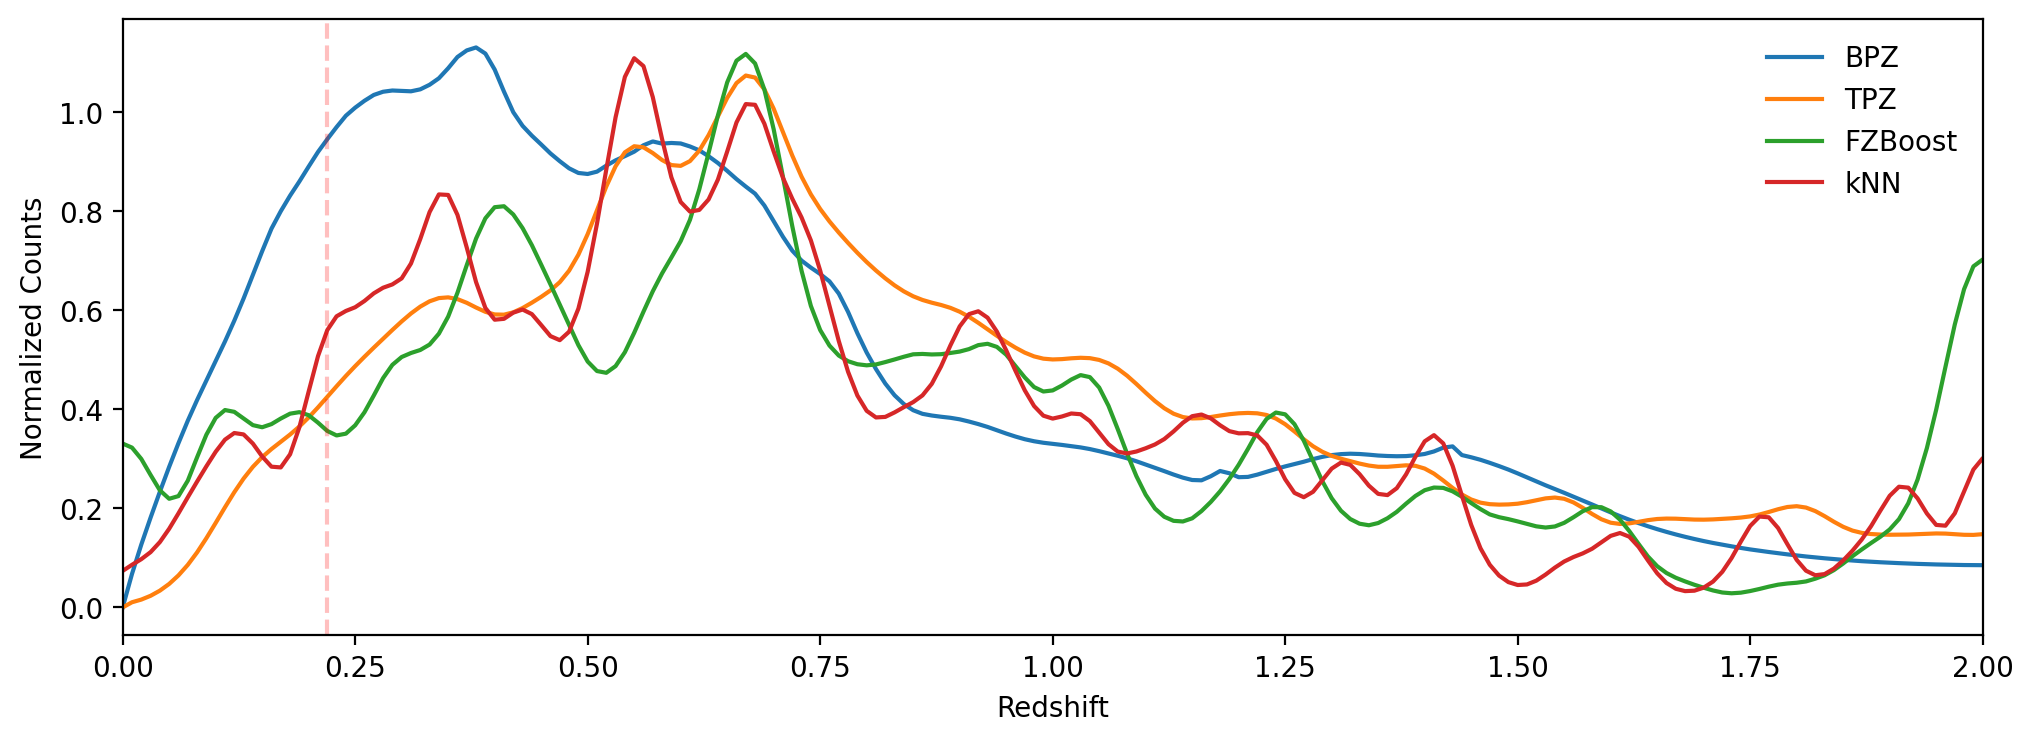

In [175]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, cc_nz_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

### ECDFS N(z) from color cuts

In [91]:
t_skymap = obs_butler.get('skyMap', skymap='lsst_cells_v1')

In [92]:
# Position of ECDFS
ra_bcg = 53.2
dec_bcg = -28.0

# Looking for all patches in delta deg region around it
delta = 0.5
center = lsst.geom.SpherePoint(ra_bcg, dec_bcg, lsst.geom.degrees)
ra_min, ra_max = ra_bcg - delta, ra_bcg + delta
dec_min, dec_max = dec_bcg - delta, dec_bcg + delta

nsteps = 20
ra_range = np.linspace(ra_min, ra_max, num=nsteps)
dec_range = np.linspace(dec_min, dec_max, num=nsteps)
radec = []
for rar in ra_range:
    for decr in dec_range:
        radec.append(lsst.geom.SpherePoint(rar, decr, lsst.geom.degrees))
        
tracts_and_patches = t_skymap.findTractPatchList(radec)

tp_dict = {}
for tract_num in np.arange(len(tracts_and_patches)):
    tract_info = tracts_and_patches[tract_num][0]
    tract_idx = tract_info.getId()
    # All the patches around the cluster
    patches = []
    for i,patch in enumerate(tracts_and_patches[tract_num][1]):
        patch_info = tracts_and_patches[tract_num][1][i]
        patch_idx = patch_info.sequential_index
        patches.append(patch_idx)
    tp_dict.update({tract_idx:patches})
print(tp_dict)

{4848: [70, 80, 90, 71, 81, 91, 72, 82, 92], 5063: [1, 11, 21, 31, 41, 51, 2, 12, 22, 32, 42, 52, 3, 13, 23, 33, 43, 53, 4, 14, 24, 34, 44, 54, 5, 15, 25, 35, 45, 55, 6, 16, 26, 36, 46, 56, 7, 17, 27, 37, 47, 57], 4849: [75, 85, 95, 76, 86, 96, 77, 87, 97, 78, 88, 98, 79, 89, 99]}


In [93]:
bands = list('ugrizy')
cmodel_flux = [b+'_cModelFlux' for b in bands] + [b+'_cModelFluxErr' for b in bands]
gaap_flux = [b+'_gaap1p0Flux' for b in bands] + [b+'_gaap1p0FluxErr' for b in bands]


butler_cols = ['coord_ra', 'coord_dec', 'refExtendedness',
               'objectId', 'parentObjectId', 'shape_xx', 'shape_xy', 'shape_yy',
               'i_ixxPSF', 'i_ixyPSF', 'i_iyyPSF', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag',
               'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2', 'i_hsmShapeRegauss_sigma', 'i_iPSF_flag',
               'refBand', 'x', 'y', 'patch', 'i_blendedness'] + cmodel_flux + gaap_flux

In [94]:
ecdfs_tracts = [5063, 4849, 4848]
mega_tables = []
for tract in ecdfs_tracts:
    # Get data from butler
    tb = obs_butler.get(
        "object",
        dataId={"band": "i", "tract": tract, "skymap": "lsst_cells_v1"},
        parameters = {"columns": butler_cols},
    )
    mega_tables.append(tb)

In [95]:
ecdfs_table = vstack(mega_tables, metadata_conflicts='silent')
ecdfs_table.add_index('objectId')

In [96]:
fields = ['all', 'ECDFS', 'EDFS', 'Rubin_SV_095-25', 'Rubin_SV_38_7']
pz_fileloc_sample = f'/sdf/data/rubin/shared/pz/data/on_sky/dp1_v29.0.0_gold_{fields[1]}.hdf5'

In [97]:
bands = list('ugrizy')
cModel_mags = [b+'_cModelMag' for b in bands]
gaap_mags = [b+'_gaap1p0Mag' for b in bands]

In [98]:
pz_match_cols = ['objectId', 'coord_ra', 'coord_dec'] + cModel_mags + gaap_mags
pz_match_data = []

with h5py.File(pz_fileloc_sample, "r") as f:
    print("Keys: %s" % f.keys())

    for c in pz_match_cols:
        data = f[c][()]
        pz_match_data.append(data)

Keys: <KeysViewHDF5 ['coord_dec', 'coord_ra', 'g_cModelMag', 'g_cModelMagErr', 'g_gaap1p0Mag', 'g_gaap1p0MagErr', 'g_gaap3p0Mag', 'g_gaap3p0MagErr', 'g_kronMag', 'g_kronMagErr', 'g_psfMag', 'g_psfMagErr', 'g_sersicMag', 'g_sersicMagErr', 'i_cModelMag', 'i_cModelMagErr', 'i_gaap1p0Mag', 'i_gaap1p0MagErr', 'i_gaap3p0Mag', 'i_gaap3p0MagErr', 'i_kronMag', 'i_kronMagErr', 'i_psfMag', 'i_psfMagErr', 'i_sersicMag', 'i_sersicMagErr', 'objectId', 'r_cModelMag', 'r_cModelMagErr', 'r_gaap1p0Mag', 'r_gaap1p0MagErr', 'r_gaap3p0Mag', 'r_gaap3p0MagErr', 'r_kronMag', 'r_kronMagErr', 'r_psfMag', 'r_psfMagErr', 'r_sersicMag', 'r_sersicMagErr', 'u_cModelMag', 'u_cModelMagErr', 'u_gaap1p0Mag', 'u_gaap1p0MagErr', 'u_gaap3p0Mag', 'u_gaap3p0MagErr', 'u_kronMag', 'u_kronMagErr', 'u_psfMag', 'u_psfMagErr', 'u_sersicMag', 'u_sersicMagErr', 'y_cModelMag', 'y_cModelMagErr', 'y_gaap1p0Mag', 'y_gaap1p0MagErr', 'y_gaap3p0Mag', 'y_gaap3p0MagErr', 'y_kronMag', 'y_kronMagErr', 'y_psfMag', 'y_psfMagErr', 'y_sersicMag', 

In [99]:
# pz_ests.columns

In [100]:
pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_all/dp1_v29.0.0_gold_photoz_cat.parquet'
# pz_file = '/sdf/data/rubin/shared/pz/projects/dp1/data/gold_baseline/dp1_sv38/dp1_v29.0.0_gold_Rubin_SV_38_7_photoz_cat.parquet'
pz_ests = pd.read_parquet(pz_file)

In [101]:
pz_ests = Table.from_pandas(pz_ests)
pz_ests.add_index('objectId')

In [102]:
pz_match_table = Table(pz_match_data, names=pz_match_cols)
pz_match_table.add_index('objectId')

In [103]:
full_pz_table = join(pz_ests, pz_match_table, keys='objectId')

In [104]:
i_mag = u.nJy.to(u.ABmag, ecdfs_table['i_cModelFlux'])
i_snr = ecdfs_table['i_cModelFlux'] / ecdfs_table['i_cModelFluxErr']
R2 = 1 - (ecdfs_table['i_ixxPSF']+ecdfs_table['i_iyyPSF'])/(ecdfs_table['shape_xx']+ecdfs_table['shape_yy'])
ecdfs_table['res'] = R2
ecdfs_table['i_mag'] = i_mag
ecdfs_table['i_snr'] = i_snr

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: divide by zero encountered in log10
  return dex.to(self._function_unit, np.log10(x))
/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.0.0/lib/python3.12/site-packages/astropy/units/function/logarithmic.py:67: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


In [105]:
ecdfs_overlap = ecdfs_table.loc[full_pz_table['objectId']]

In [106]:
add_cols = ['refExtendedness', 'g_cModel_flag', 'r_cModel_flag', 'i_cModel_flag', 'i_mag', 'i_snr', 'res',
            'i_hsmShapeRegauss_flag', 'i_hsmShapeRegauss_e1', 'i_hsmShapeRegauss_e2', 'i_blendedness', 'i_hsmShapeRegauss_sigma', 'i_iPSF_flag']

for ac in add_cols:
    tmp = ecdfs_overlap[ac]
    full_pz_table[ac] = tmp

In [42]:
gal_pz = full_pz_table[full_pz_table['refExtendedness']==1]

In [43]:
# fig, ax = plt.subplots(1, figsize=(10, 5))

# cmap = cm.tab10

# ax.hist(gal_pz['fzboost_z_median'], range=(0, 3), bins=61, histtype='step', label='FZB Median', color=cmap(0))
# ax.hist(gal_pz['fzboost_z_median'], range=(0, 3), bins=61, histtype='stepfilled', color=cmap(0), alpha=0.2)
# ax.hist(gal_pz['tpz_z_median'], range=(0, 3), bins=61, histtype='step', label='TPZ Median', color=cmap(1))
# ax.hist(gal_pz['tpz_z_median'], range=(0, 3), bins=61, histtype='stepfilled', color=cmap(1), alpha=0.2);
# ax.legend()
# ax.set_title("ECDFS N(z) Pre-Cut on Galaxies Only")

In [44]:
full_pz_table['gi'] = full_pz_table['g_gaap1p0Mag'] - full_pz_table['i_gaap1p0Mag']
full_pz_table['gr'] = full_pz_table['g_gaap1p0Mag'] - full_pz_table['r_gaap1p0Mag']
full_pz_table['ri'] = full_pz_table['r_gaap1p0Mag'] - full_pz_table['i_gaap1p0Mag']

In [45]:
mag_lim = 24

In [46]:
gi_table_line = (full_pz_table['r_cModelMag'] - 18) * (-0.2/5) + 1.9
ri_table_line = (full_pz_table['r_cModelMag'] - 18) * (-0.1/5) + .55
gr_table_line = (full_pz_table['r_cModelMag'] - 18) * (-0.25/5) + 1.35

gi_lims = (0.1, -.25)
ri_lims = (0.04, -0.1)
gr_lims = (0.1, -.15)

In [47]:
gi_redseq = np.logical_and.reduce((full_pz_table['gi'] < gi_table_line + gi_lims[0], full_pz_table['gi'] > gi_table_line + gi_lims[1], full_pz_table['r_cModelMag'] < mag_lim))
ri_redseq = np.logical_and.reduce((full_pz_table['ri'] < ri_table_line + ri_lims[0], full_pz_table['ri'] > ri_table_line + ri_lims[1], full_pz_table['r_cModelMag'] < mag_lim))
gr_redseq = np.logical_and.reduce((full_pz_table['gr'] < gr_table_line + gr_lims[0], full_pz_table['gr'] > gr_table_line + gr_lims[1], full_pz_table['r_cModelMag'] < mag_lim))


In [48]:
full_pz_table['gi_redseq'] = gi_redseq
full_pz_table['ri_redseq'] = ri_redseq
full_pz_table['gr_redseq'] = gr_redseq

In [49]:
all_redseq = np.logical_and.reduce((full_pz_table['gi_redseq'], full_pz_table['gr_redseq'], full_pz_table['ri_redseq']))
full_pz_table['all_redseq'] = all_redseq

In [50]:
#### Apply cuts
filt = (full_pz_table['refExtendedness'] >= 0.5)
filt &= full_pz_table['g_cModel_flag']== False
filt &= full_pz_table['r_cModel_flag']== False
filt &= full_pz_table['i_cModel_flag']== False
filt &= ~(full_pz_table['i_hsmShapeRegauss_flag'])
filt &= (full_pz_table['i_hsmShapeRegauss_e1']**2 + full_pz_table['i_hsmShapeRegauss_e2']**2) <= 4
filt &= full_pz_table['res'] >= 0.3
filt &= full_pz_table['i_blendedness'] <= 0.42
filt &= (full_pz_table['i_hsmShapeRegauss_sigma']<= 0.4) * (0 < full_pz_table['i_hsmShapeRegauss_sigma'])
filt &= full_pz_table['i_iPSF_flag']==0
filt &= full_pz_table['i_cModelMag']>=20
# filt &= ~full_pz_table['all_redseq']
# filt &= ~prak_rs
# filt &= table['fzb_z_median'] > .3
print(f"After cuts: {np.sum(filt)}")

After cuts: 80472


In [51]:
ecdfs_test = full_pz_table[filt]

In [52]:
# test_is = np.arange(23.4, 24, .1)

# # for i_cut in test_is:
# #     print(f'i={i_cut:0.1f}')
# #     print('----------------------------------')
# #     print("Removed by both flags: ", np.sum(np.logical_and.reduce((test_table['i_snr'] < 10, test_table['i_cModel_mag'] > i_cut))))
# #     print("Removed by SNR flag ONLY: ", np.sum(np.logical_and.reduce((test_table['i_snr'] < 10, test_table['i_cModel_mag'] < i_cut))))
# #     print("Removed by i-mag flag ONLY: ", np.sum(np.logical_and.reduce((test_table['i_snr'] > 10, test_table['i_cModel_mag'] > i_cut))))
# #     print("Remaining table: ", len(test_table) - np.sum(np.logical_and.reduce((test_table['i_snr'] < 10, test_table['i_cModel_mag'] > i_cut))))
# #     print("")

# fig, ax = plt.subplots(1, figsize=(6,6))

# ax.plot(ecdfs_test['i_cModelMag'], ecdfs_test['i_snr'], '.', label='ecdfs')
# ax.plot(test_table['i_cModel_mag'], test_table['i_snr'], '.', label='a360')
# ax.axvline(23.5, ls='--', color='k')
# ax.legend()
# plt.semilogy()

In [53]:
ecdfs_test = full_pz_table[filt]
final_filt = ecdfs_test['i_cModelMag'] < 23.5
final_filt &= ecdfs_test['i_snr'] > 10
wl_pz = ecdfs_test[final_filt]

Text(0.5, 0.01, 'cModel $r$-mag')

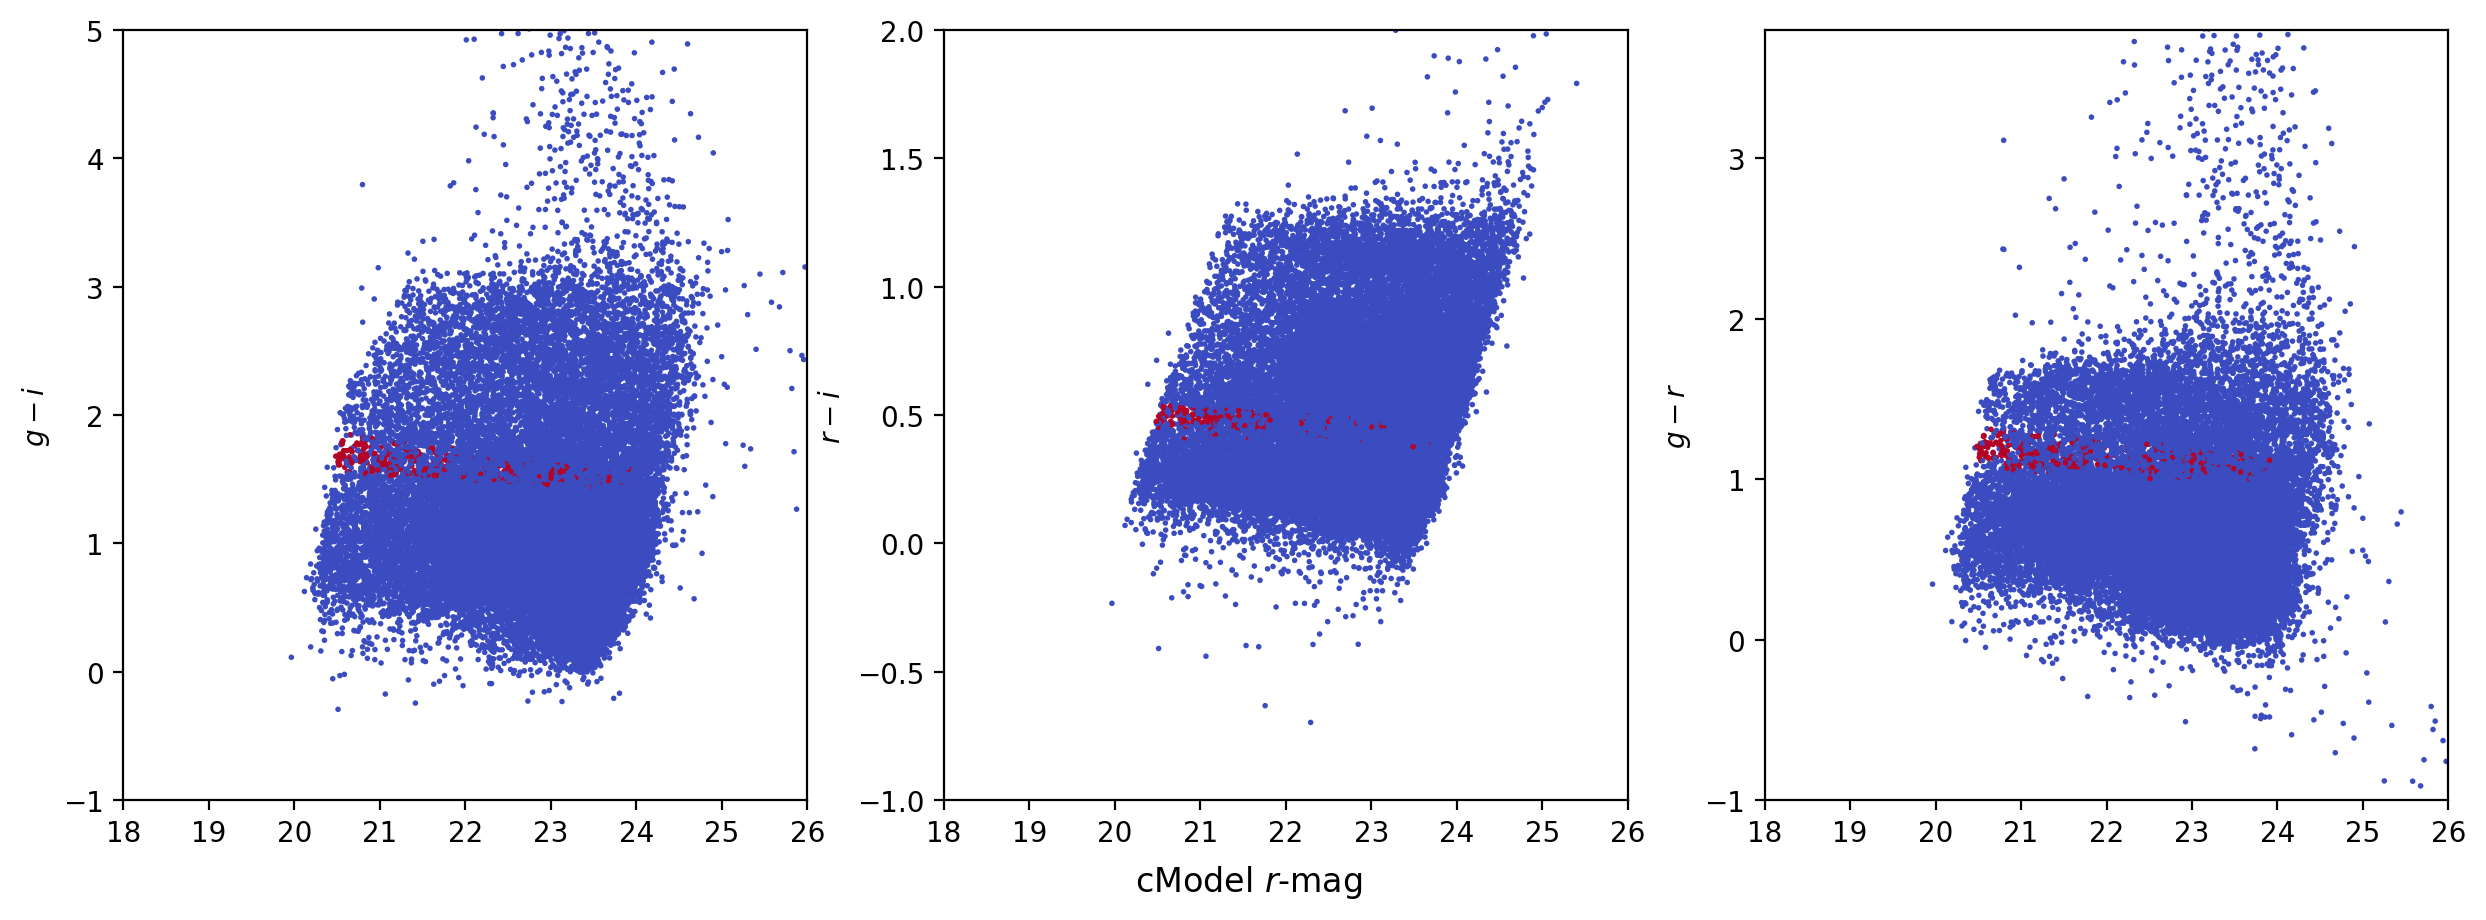

In [54]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))

rs_table = wl_pz[wl_pz['refExtendedness']==1]
cmap = cm.coolwarm
color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']
for i in range(3):
    col = color_names[i]
    ax[i].scatter(rs_table['r_cModelMag'], rs_table[col], marker='.', s=4, c=rs_table[f'all_redseq'], cmap=cmap)
    ax[i].set_ylabel(col_name[i])
    ax[i].set_xlim(18, 26)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)
fig.supxlabel(r"cModel $r$-mag")

In [55]:
# cut_gal_pz = full_pz_table[np.logical_and(full_pz_table['refExtendedness']==1, ~full_pz_table['all_redseq'])]
# cut_gal_pz = cut_pz[cut_pz['refExtendedness']==1]
cut_gal_pz = wl_pz[~wl_pz['all_redseq']]

In [56]:
ecdfs_pz_cat = Table.read('/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize/dp1_6band/dp1_v29.0.0_gold_ecdfs_edfs_sv95_photoz_cat.parquet')

In [57]:
def good_width(algo, table, central='mean'):
    # zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])/(table[f'{algo}_z_{central}'])
    zwidth = (table[f'{algo}_z_err68_high'] - table[f'{algo}_z_err68_low'])
    return zwidth

In [58]:
method_list = ['fzboost', 'knn', 'cmnn', 'dnf', 'tpz', 'gpz', 'bpz']

for ml in method_list:
    if ml=='knn':
        zwidth = good_width(ml, ecdfs_pz_cat, central='median')
    else:
        zwidth = good_width(ml, ecdfs_pz_cat, central='mean')

    ecdfs_pz_cat[ml+'_diff'] = zwidth

In [59]:
ecdfs_pz_oid = ecdfs_pz_cat['objectId'] # The ids of the rows of the qp files
nz_id = cut_gal_pz['objectId'] # The ids we want the N(z) of
ecdfs_nz_filt = [eid in nz_id for eid in ecdfs_pz_oid]

In [60]:
def get_pdfs_ecdfs(algo_type, filt):
    xs = np.linspace(0, 3, 301)
    pdfs = qp.read(f'/home/z/ztq1996/comm_pz/dp1_run/rail_project_root/projects/dp1/data/gold_dp1_optimize/dp1_6band/output_estimate_{algo_type}.hdf5')
    pdf_plot = pdfs[filt].pdf(xs)

    stacked_plot = np.sum(pdf_plot, axis=0)
    normalized_plot = stacked_plot / np.sum(filt)

    # stacked_plot_all = np.sum(pdf_plot, axis=0)
    # normalized_plot_all = stacked_plot_all / len(pdf_plot)

    return normalized_plot, pdf_plot, xs

In [61]:
pz_algs = ['bpz', 'tpz', 'fzboost', 'knn']
pz_cutoff = 0.22+0.15
ecdfs_nz_pdfs = []

for alg in pz_algs:
    central = 'median' if alg=='knn' else 'mean'
    new_filt = np.logical_and.reduce((ecdfs_nz_filt, ecdfs_pz_cat[f'{alg}_diff'] < 0.25))
    print(f"On {alg} we have {np.sum(new_filt)}")
    pdf, _, xs = get_pdfs_ecdfs(alg, new_filt)
    ecdfs_nz_pdfs.append(pdf)

On bpz we have 28014
On tpz we have 12522
On fzboost we have 24757
On knn we have 19090


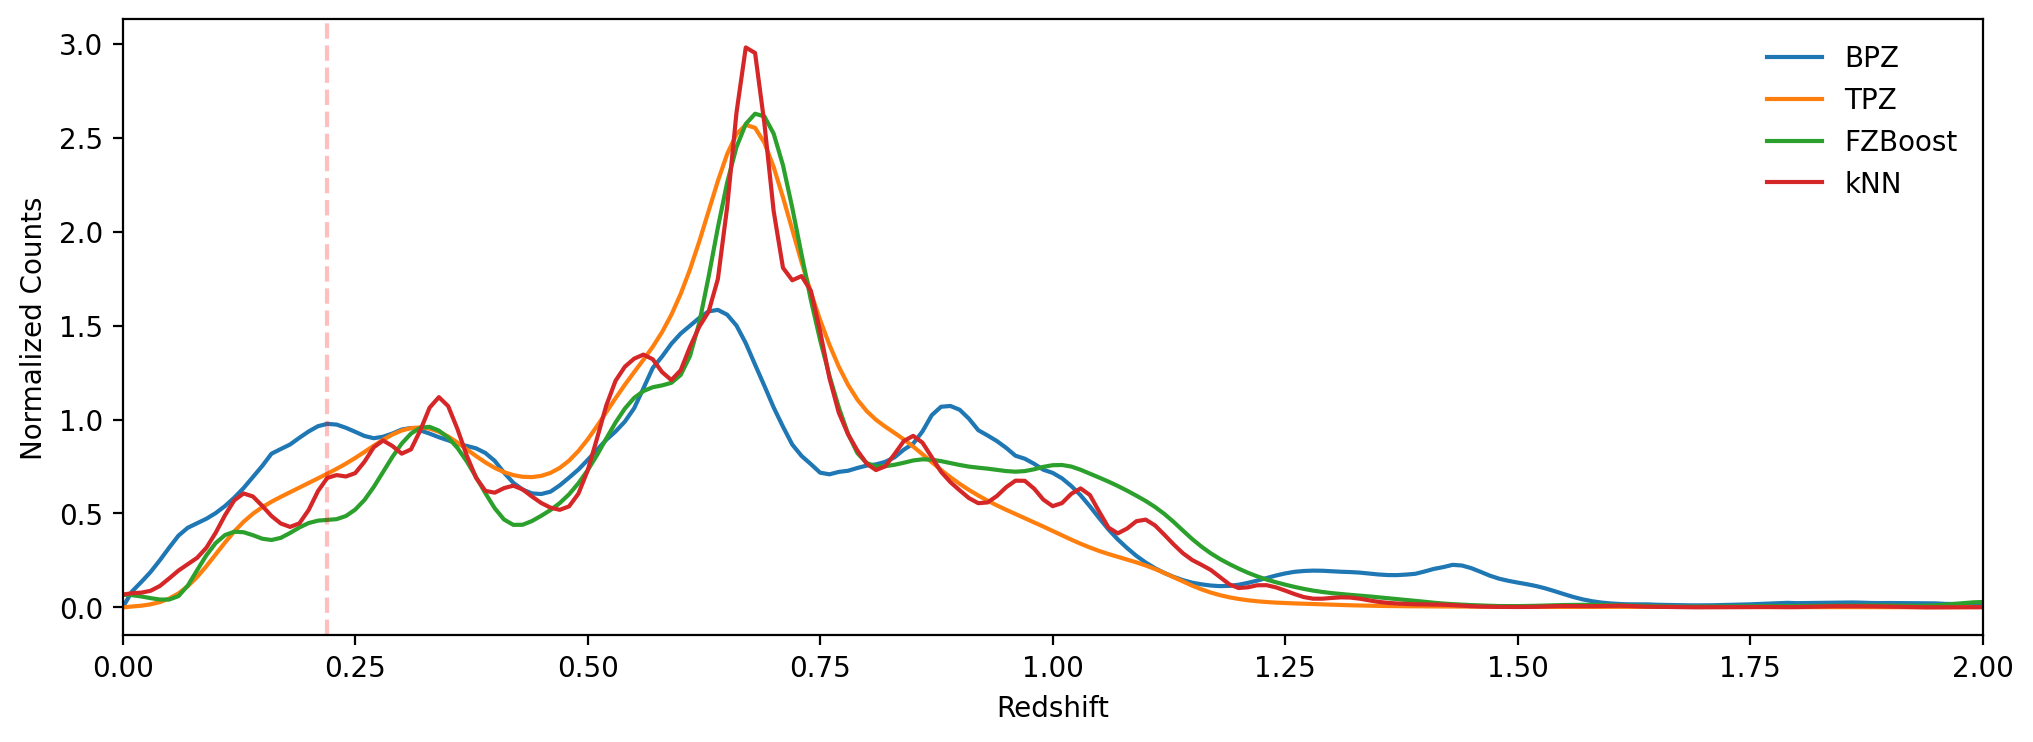

In [64]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']

for i, alg in enumerate(pz_algs):
    ax.plot(xs, ecdfs_nz_pdfs[i], label=label[i])

ax.legend(frameon=False)
ax.set_xlim(0, 2)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.axvline(0.37, ls='--', color='k', alpha=0.25)
# ax.set_title("N(z) with $z \\geq 0.37$ and $\\sigma_z \\leq 0.25$")

Text(0.02, 0.5, 'Counts')

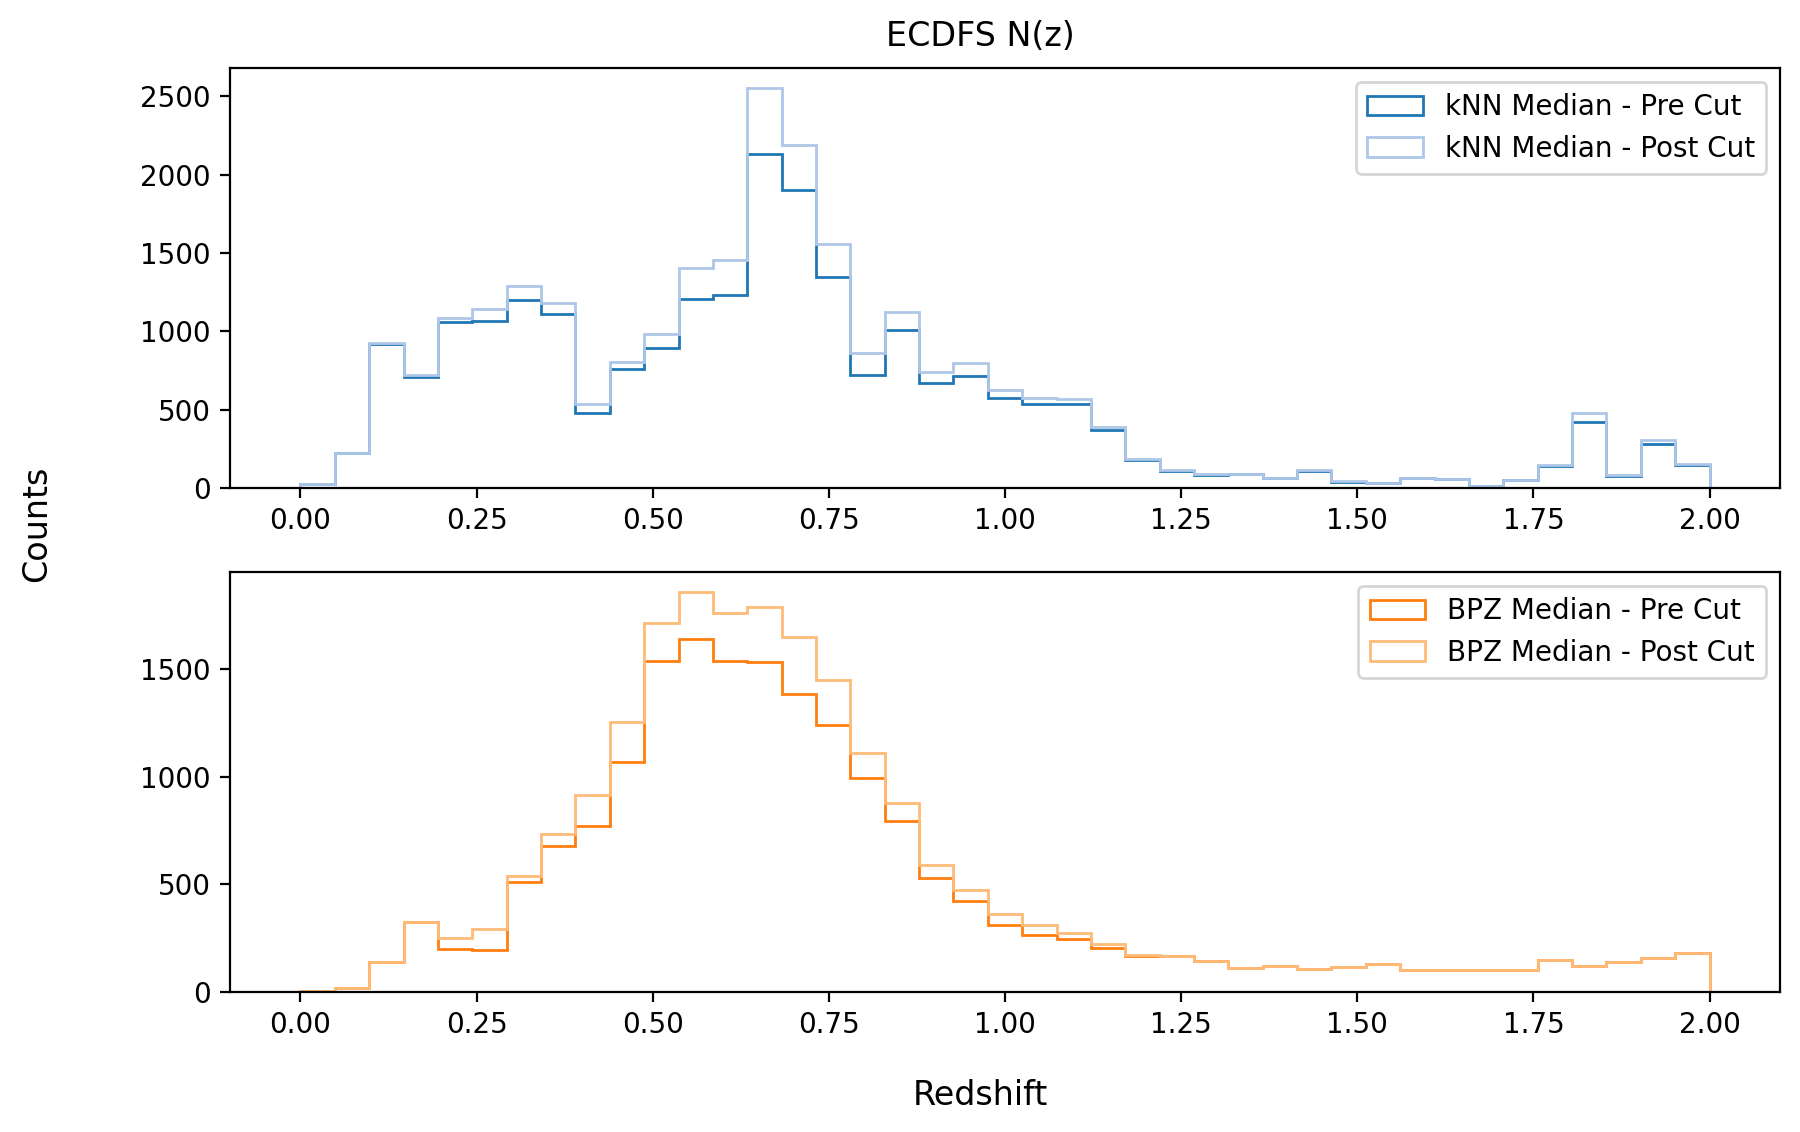

In [1004]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

cmap = cm.tab20

ax[0].hist(nocut_pz['knn_z_median'], range=(0, 2), bins=41, histtype='step',
           label='kNN Median - Pre Cut', color=cmap(0))
# ax[0].hist(nocut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(0), alpha=0.5)
ax[0].hist(cut_pz['knn_z_median'], range=(0, 2), bins=41, histtype='step',
           label='kNN Median - Post Cut', color=cmap(1))
# ax[0].hist(cut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(1), alpha=0.5)
ax[0].legend()

ax[1].hist(nocut_pz['bpz_z_median'], range=(0, 2), bins=41, histtype='step',
           label='BPZ Median - Pre Cut', color=cmap(2))
# ax[1].hist(nocut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(2), alpha=0.05);
ax[1].hist(cut_pz['bpz_z_median'], range=(0, 2), bins=41, histtype='step',
           label='BPZ Median - Post Cut', color=cmap(3))
# ax[1].hist(cut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(3), alpha=0.05)
ax[1].legend()
fig.suptitle("ECDFS N(z)", y=.92)
fig.supxlabel("Redshift")
fig.supylabel("Counts")

Text(0.02, 0.5, 'Counts')

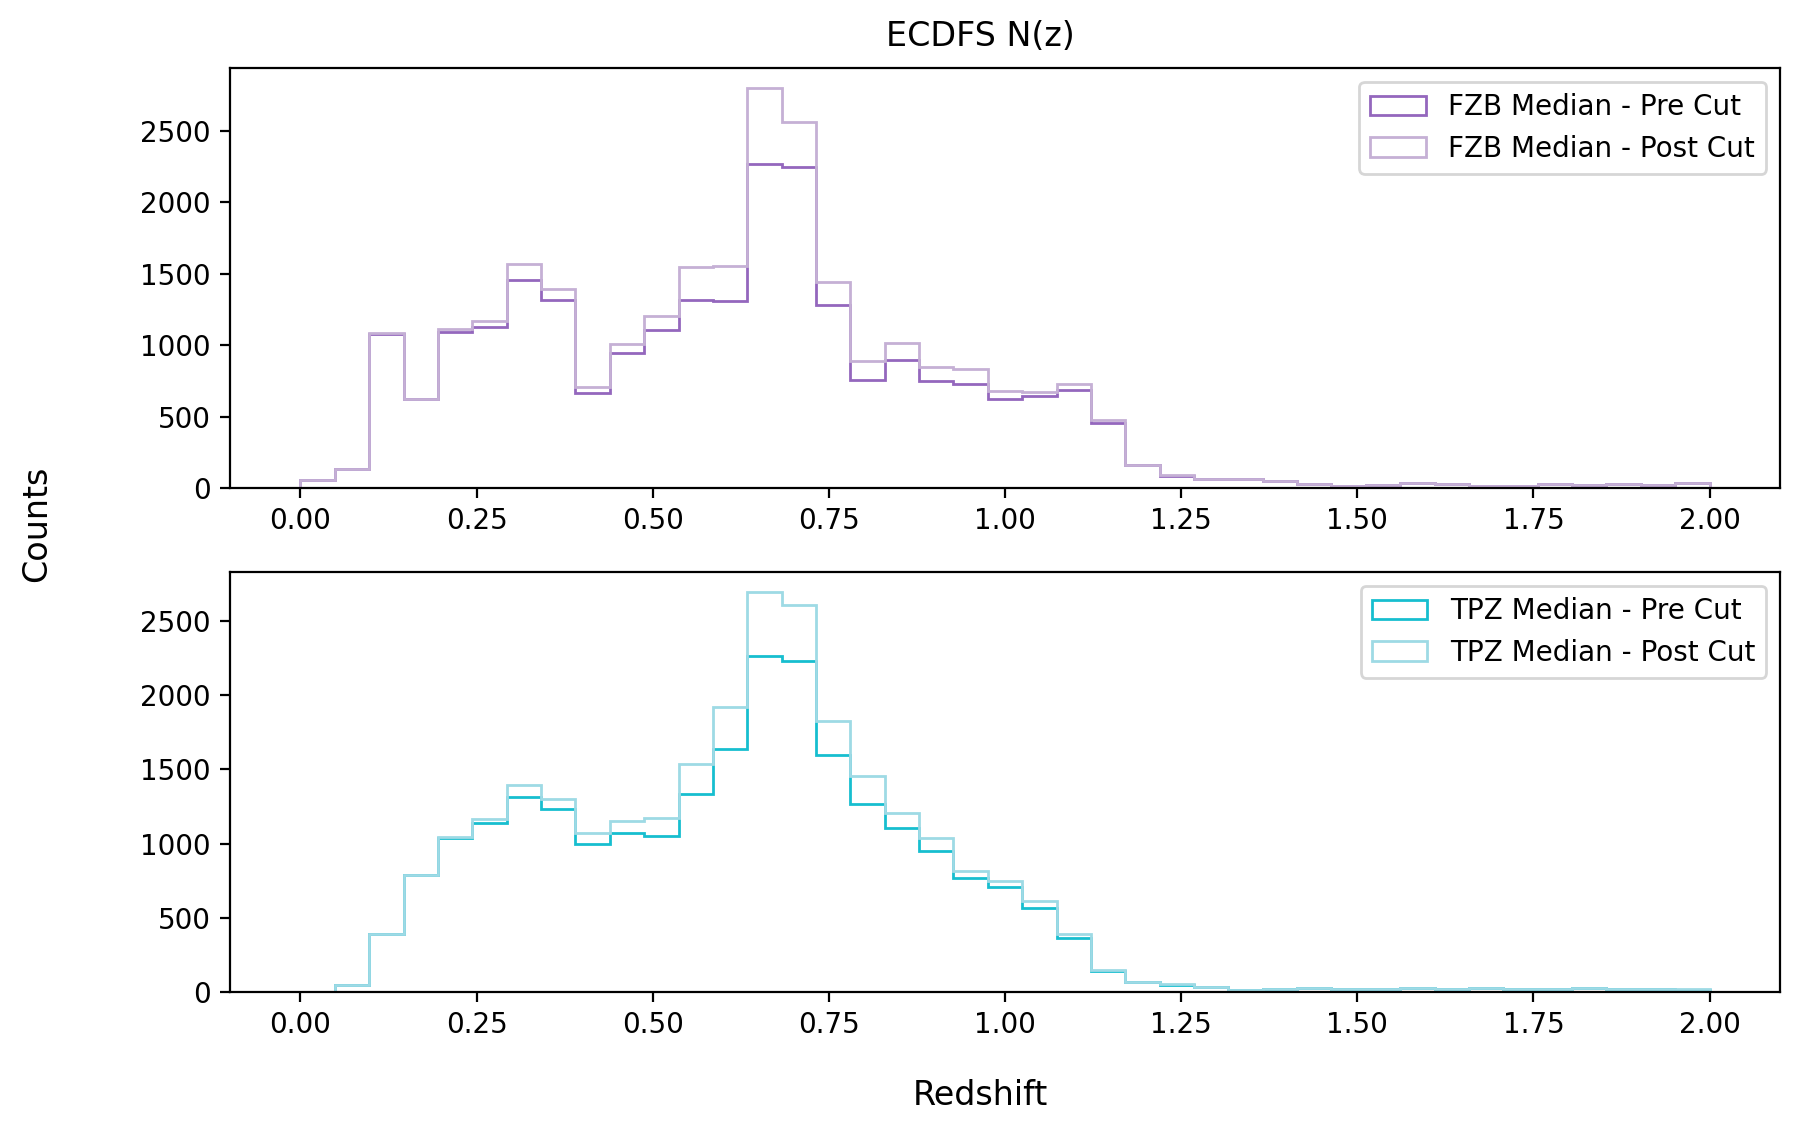

In [1005]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 6))

cmap = cm.tab20

ax[0].hist(nocut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='step',
           label='FZB Median - Pre Cut', color=cmap(8))
# ax[0].hist(nocut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(0), alpha=0.5)
ax[0].hist(cut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='step',
           label='FZB Median - Post Cut', color=cmap(9))
# ax[0].hist(cut_pz['fzboost_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(1), alpha=0.5)
ax[0].legend()

ax[1].hist(nocut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='step',
           label='TPZ Median - Pre Cut', color=cmap(18))
# ax[1].hist(nocut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(2), alpha=0.05);
ax[1].hist(cut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='step',
           label='TPZ Median - Post Cut', color=cmap(19))
# ax[1].hist(cut_pz['tpz_z_median'], range=(0, 2), bins=41, histtype='stepfilled', color=cmap(3), alpha=0.05)
ax[1].legend()
fig.suptitle("ECDFS N(z)", y=.92)
fig.supxlabel("Redshift")
fig.supylabel("Counts")

### DESI Matched


In [416]:
from matplotlib._cm import cubehelix

In [376]:
match_cc = Table.read('/home/a/adari/u/clusters/data/match_desi.fits')

In [377]:
match_cc['gi'] = match_cc['g_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
match_cc['ri'] = match_cc['r_gaap1p0Mag'] - match_cc['i_gaap1p0Mag']
match_cc['gr'] = match_cc['g_gaap1p0Mag'] - match_cc['r_gaap1p0Mag']

In [378]:
mag_lim = 24.5

In [379]:
gi_table_line = (match_cc['r_cModelMag'] - 18) * (-0.2/5) + 1.9
ri_table_line = (match_cc['r_cModelMag'] - 18) * (-0.1/5) + .55
gr_table_line = (match_cc['r_cModelMag'] - 18) * (-0.25/5) + 1.35

gi_lims = (0.1, -.25)
ri_lims = (0.04, -0.1)
gr_lims = (0.1, -.15)

In [380]:
desi_gi_redseq = np.logical_and.reduce((match_cc['gi'] < gi_table_line + gi_lims[0], match_cc['gi'] > gi_table_line + gi_lims[1], match_cc['r_cModelMag'] < mag_lim))
desi_ri_redseq = np.logical_and.reduce((match_cc['ri'] < ri_table_line + ri_lims[0], match_cc['ri'] > ri_table_line + ri_lims[1], match_cc['r_cModelMag'] < mag_lim))
desi_gr_redseq = np.logical_and.reduce((match_cc['gr'] < gr_table_line + gr_lims[0], match_cc['gr'] > gr_table_line + gr_lims[1], match_cc['r_cModelMag'] < mag_lim))


In [381]:
match_cc['gi_redseq'] = desi_gi_redseq
match_cc['ri_redseq'] = desi_ri_redseq
match_cc['gr_redseq'] = desi_gr_redseq

In [415]:
match_cc['all_redseq'] = np.logical_and.reduce((desi_gi_redseq, desi_ri_redseq, desi_gr_redseq))

In [420]:
redseq_match = match_cc[match_cc['all_redseq']]

In [430]:
np.sum(np.logical_and(.21 < redseq_match['desi_z'], redseq_match['desi_z'] < .22))

21

In [448]:
kale, _ = np.histogram(redseq_match['desi_z'], range=(0.01, .51), bins=25)

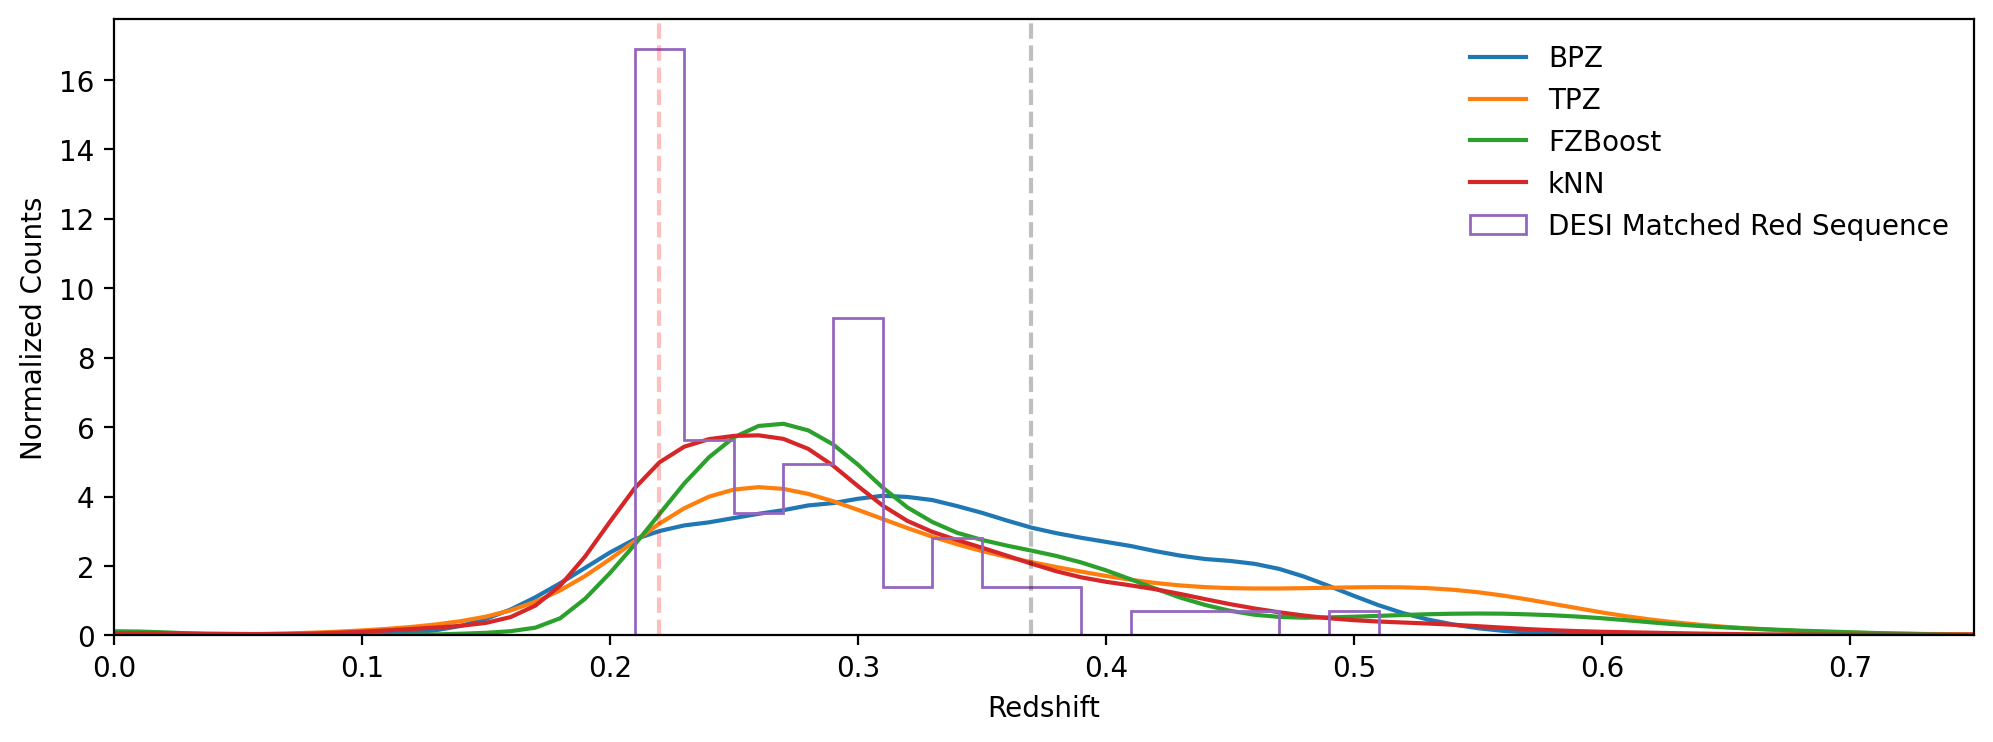

In [460]:
fig, ax = plt.subplots(1, figsize=(12, 4))

label = ['BPZ', 'TPZ', 'FZBoost', 'kNN']
for i, alg in enumerate(pz_algs):
    ax.plot(xs, quality_pdfs[i], label=label[i])

ax.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25, label="DESI Matched Red Sequence", density=True)
ax.legend(frameon=False)
ax.set_xlim(0, .75)
ax.set_xlabel("Redshift")
ax.set_ylabel("Normalized Counts")
ax.axvline(0.37, ls='--', color='k', alpha=0.25)
ax.axvline(0.22, ls='--', color='r', alpha=0.25)
# ax.set_title("N(z) with $\\sigma_z \\leq 0.25$")
# ax.set_title("N(z) with Quality Cuts")

Text(0, 0.5, 'Counts')

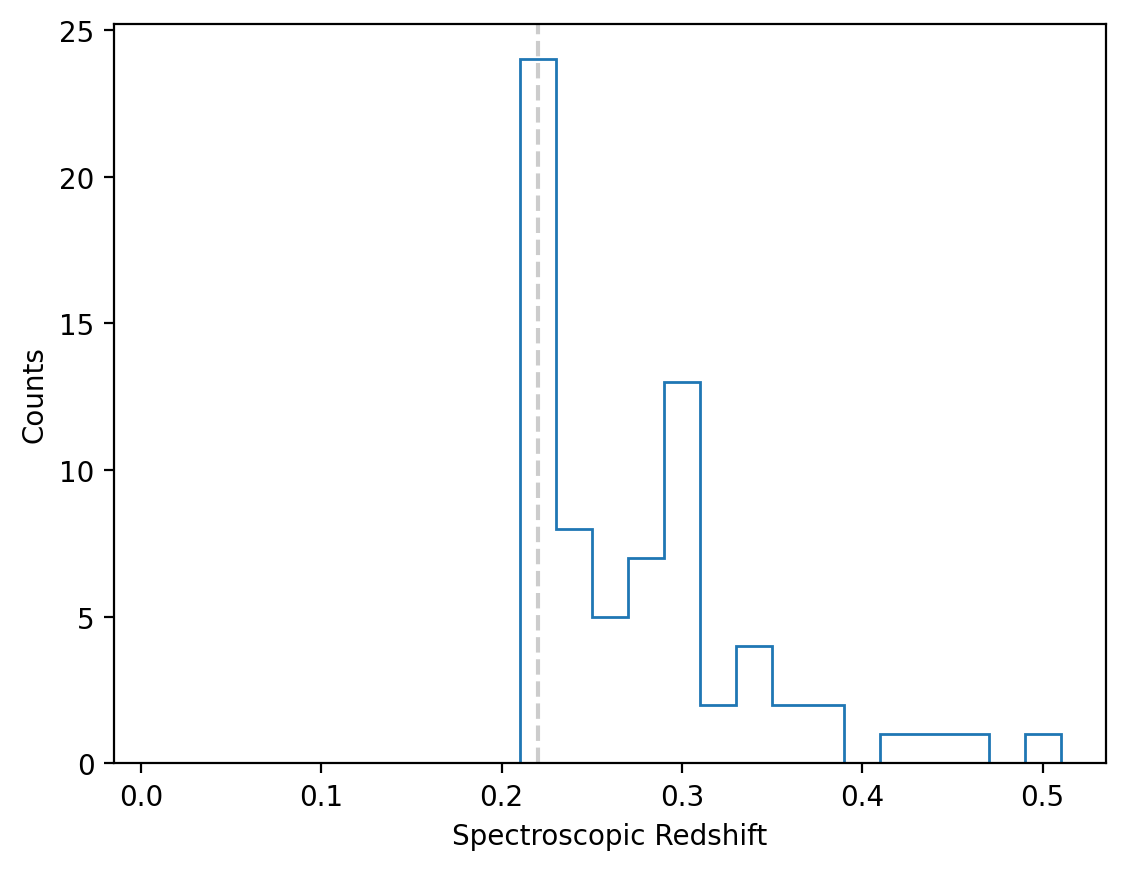

In [434]:
plt.axvline(0.22, ls='--', color='k', alpha=0.2)
plt.hist(redseq_match['desi_z'], histtype='step', range=(0.01, .51), bins=25, label="Matched Red Sequence")
plt.xlabel("Spectroscopic Redshift")
plt.ylabel("Counts")

In [417]:
cmap = cubehelix_colormap(
   start=0.2,
   rot=-0.1,
   gamma=1,
   hue=1,
   light=0.9,
   dark=0.1,
   name="",
)
cmap_r = cmap.reversed()

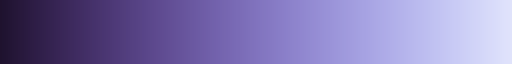

In [418]:
cmap

In [453]:
# cluster_zfilt = np.abs(match_cc['desi_z'] - 0.22) < 0.05
cluster_zfilt = match_cc['all_redseq']

Text(0.5, 0.01, 'cModel $r$-mag')

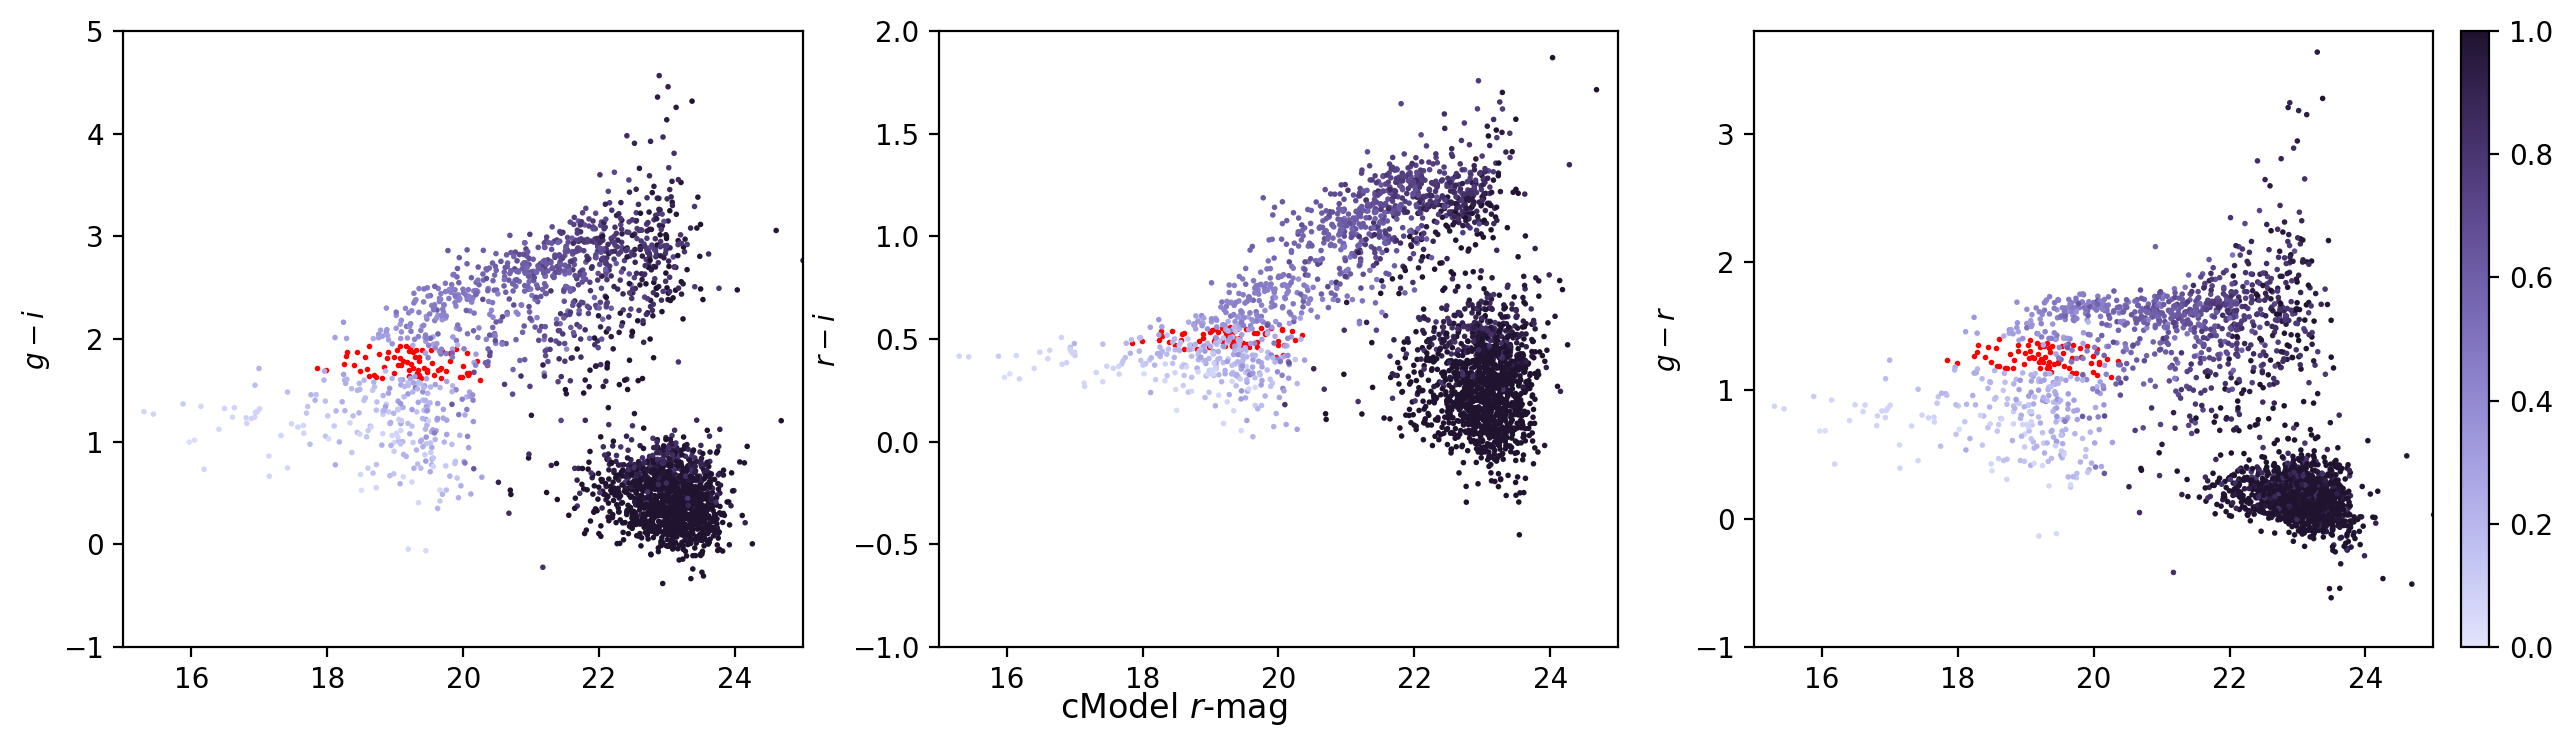

In [454]:
fig, ax = plt.subplots(ncols=3, figsize=(14, 4))

color_names = ['gi', 'ri', 'gr']
col_name = ['$g-i$', '$r-i$', '$g-r$']

# cmap = cm.coolwarm_r

for i in range(3):
    col = color_names[i]
    im = ax[i].scatter(match_cc['r_cModelMag'][cluster_zfilt], match_cc[col][cluster_zfilt], marker='.', s=4, c='r')
    im = ax[i].scatter(match_cc['r_cModelMag'][~cluster_zfilt], match_cc[col][~cluster_zfilt], marker='.', s=4, c=match_cc['desi_z'][~cluster_zfilt], cmap=cmap_r, vmin=0.0, vmax=1)
    # im = ax[i].scatter(match_cc['r_cModelMag'], match_cc[col], marker='.', s=4, c=colors, vmin=0.0, vmax=1)
    ax[i].set_ylabel(col_name[i])
    ax[i].set_xlim(15, 25)

ax[0].set_ylim(-1, 5)
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 3.8)

fig.subplots_adjust(right=0.95)
cbar_ax = fig.add_axes([0.96, 0.11, 0.01, .77])
fig.colorbar(im, cax=cbar_ax)

fig.supxlabel(r"cModel $r$-mag")

## Profile Comparison

In [179]:
with open(f'./cluster_data/technote/profile_all_y3', 'rb') as f:
    profile = pickle.load(f)

In [172]:
cc_types = ['all', 'gi', 'ri', 'gr']
profiles = []

for cc in cc_types:
    with open(f'./cluster_data/technote/profile_{cc}_y3', 'rb') as f:
        profile = pickle.load(f)
        profiles.append(profile.profile)

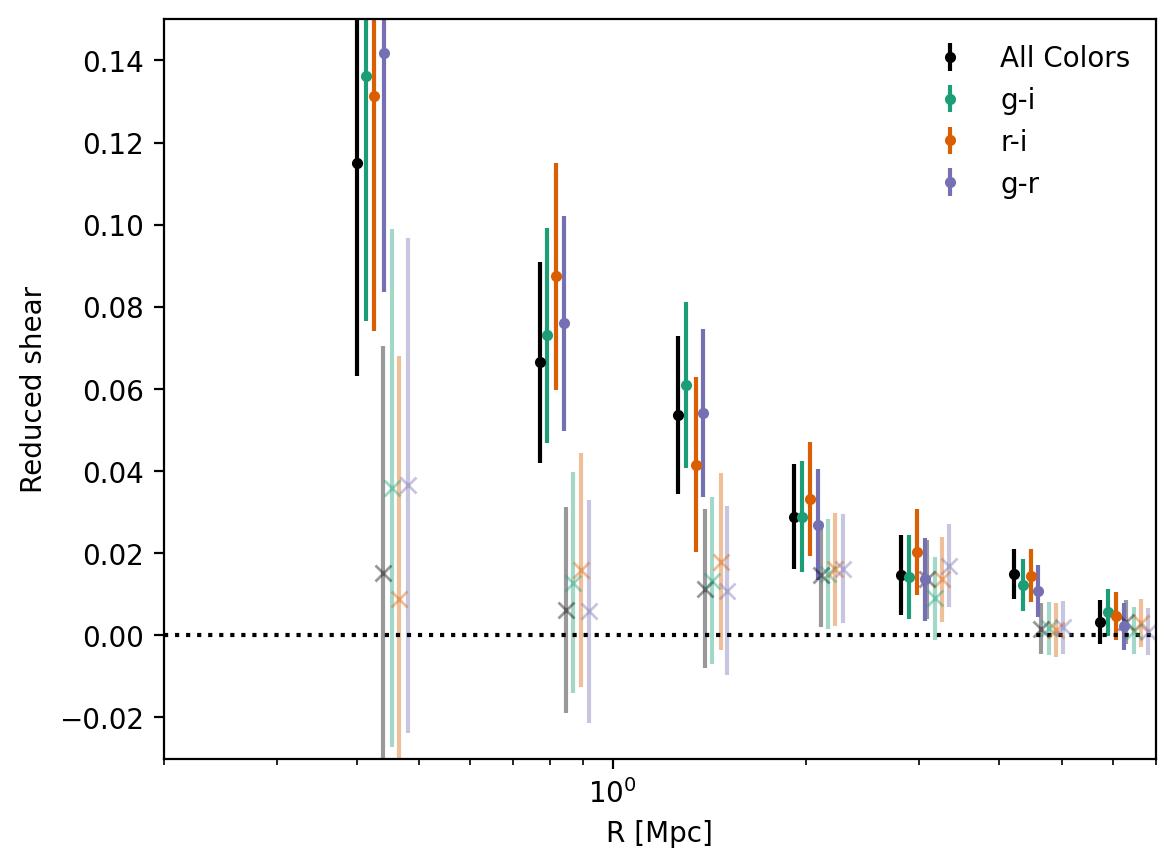

In [190]:

colors = ['#000000', '#1b9e77','#d95f02','#7570b3']
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.4)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.15])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with Color Cuts - DP1")

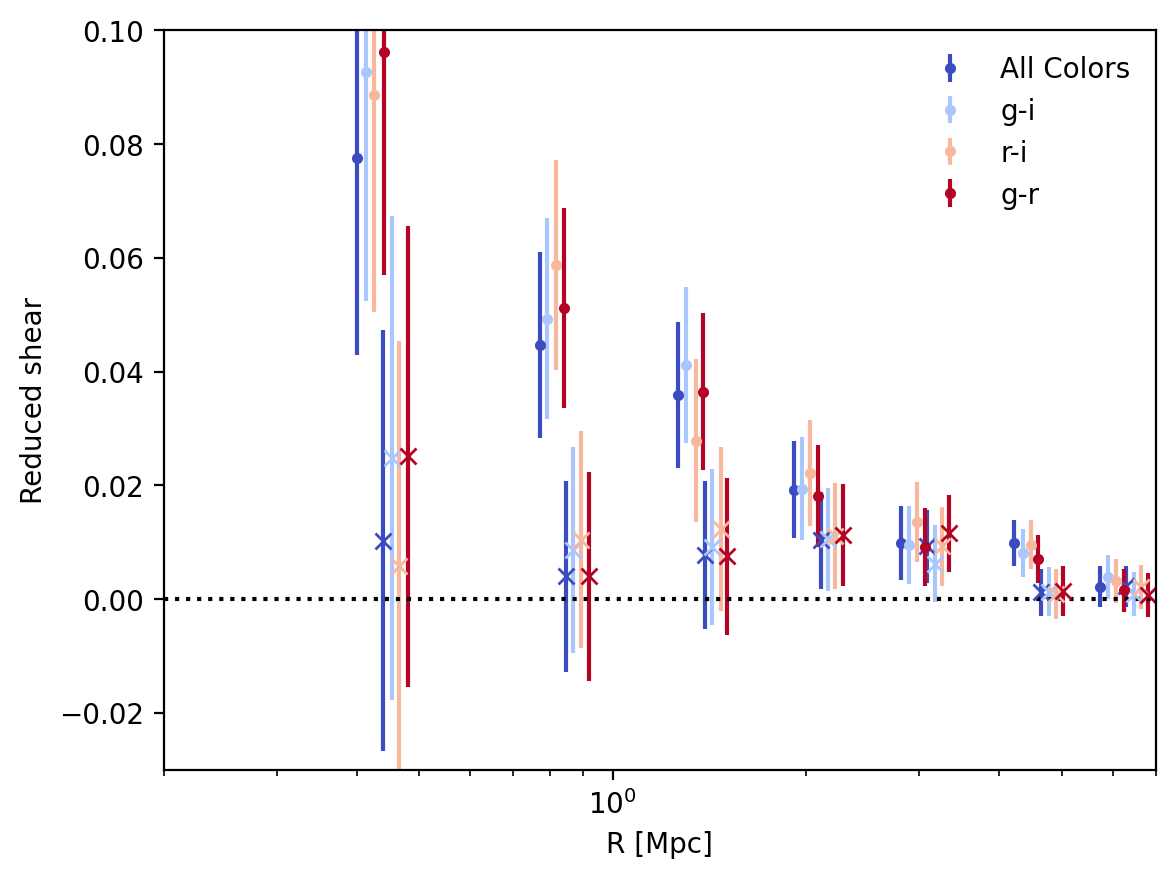

In [38]:

cmap = cm.coolwarm
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=cmap(i/3))
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=cmap(i/3))

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with Color Cuts - DP1")

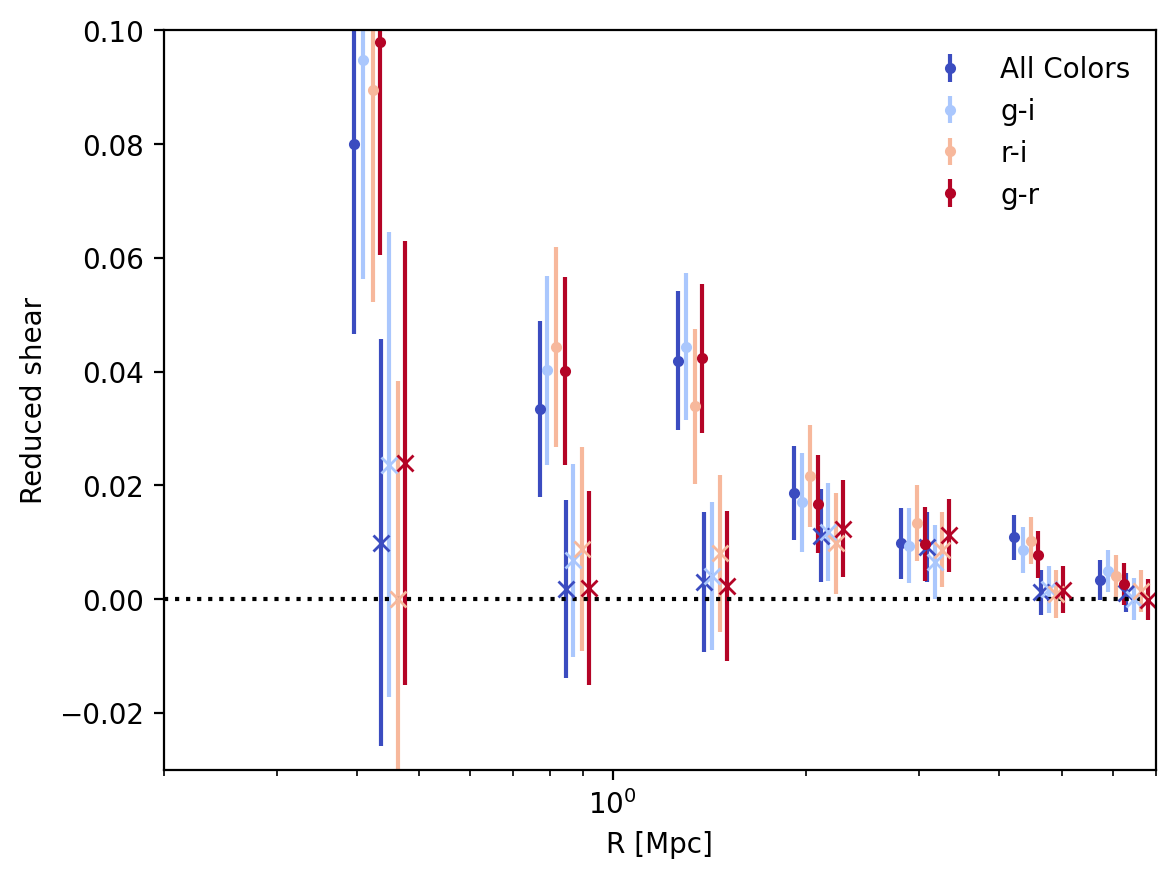

In [949]:

cmap = cm.coolwarm
labels = ['All Colors', 'g-i', 'r-i', 'g-r']

for i,profile in enumerate(profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=cmap(i/3))
    plt.errorbar(profile['radius']*(1.1+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=cmap(i/3))

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with Color Cuts - DP1")

In [482]:
pz_types = ['bpz0.37', 'tpz0.37', 'fzboost0.37', 'knn0.37']
pz_profiles = []

for cc in pz_types:
    with open(f'./cluster_data/technote/profile_{cc}', 'rb') as f:
        profile = pickle.load(f)
        pz_profiles.append(profile.profile)

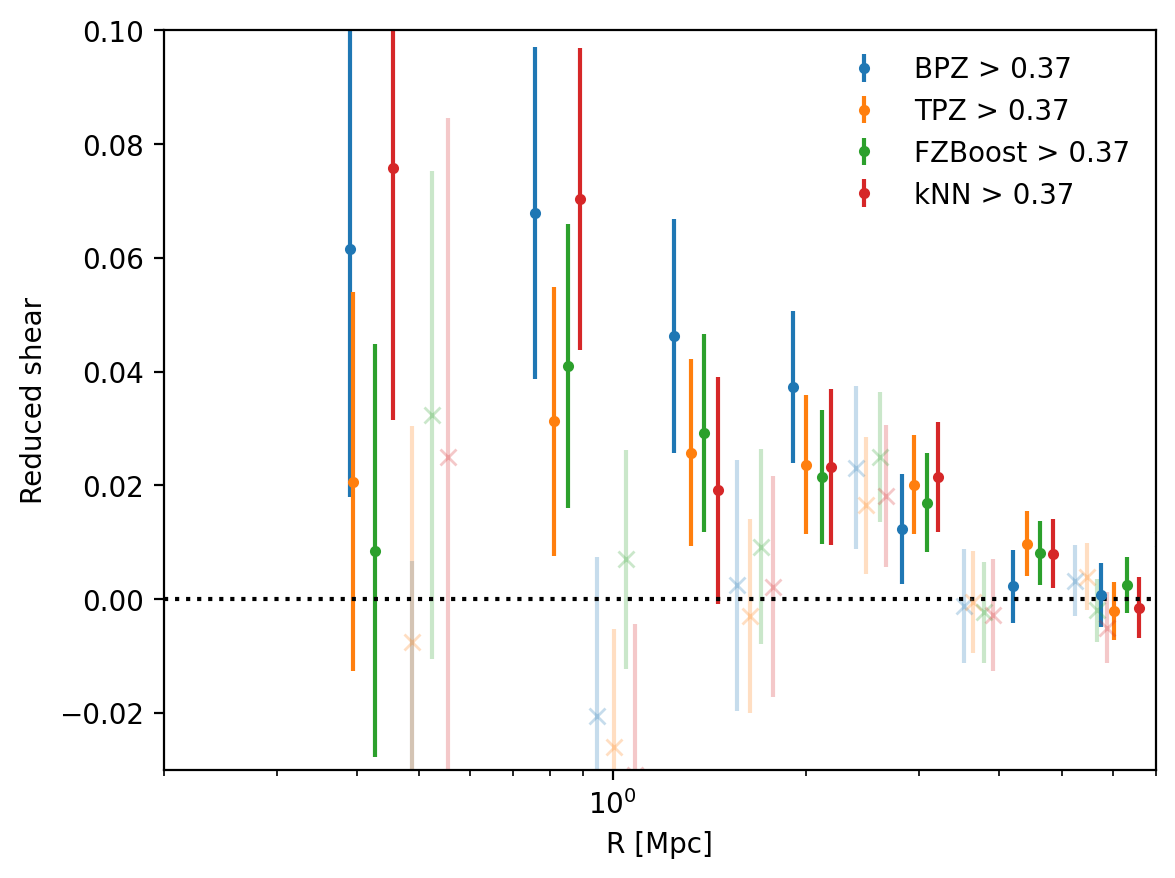

In [484]:

cmap = cm.tab10
labels = ['BPZ > 0.37', 'TPZ > 0.37',  'FZBoost > 0.37', 'kNN > 0.37']
# colors = [cmap(0), cmap(1.),cmap(.25), cmap(0.75)]
colors = [cmap(i) for i in range(4)]


for i,profile in enumerate(pz_profiles):
    plt.errorbar(profile['radius']*(1+.05*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.25+.05*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i], alpha=0.25)

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with PZ Cuts - DP1")

In [815]:
pz_types = ['knn0.22', 'bpz0.22', 'knn0.45', 'bpz0.45']
pz_profiles = []

for cc in pz_types:
    with open(f'./cluster_data/technote/profile_{cc}', 'rb') as f:
        profile = pickle.load(f)
        pz_profiles.append(profile.profile)

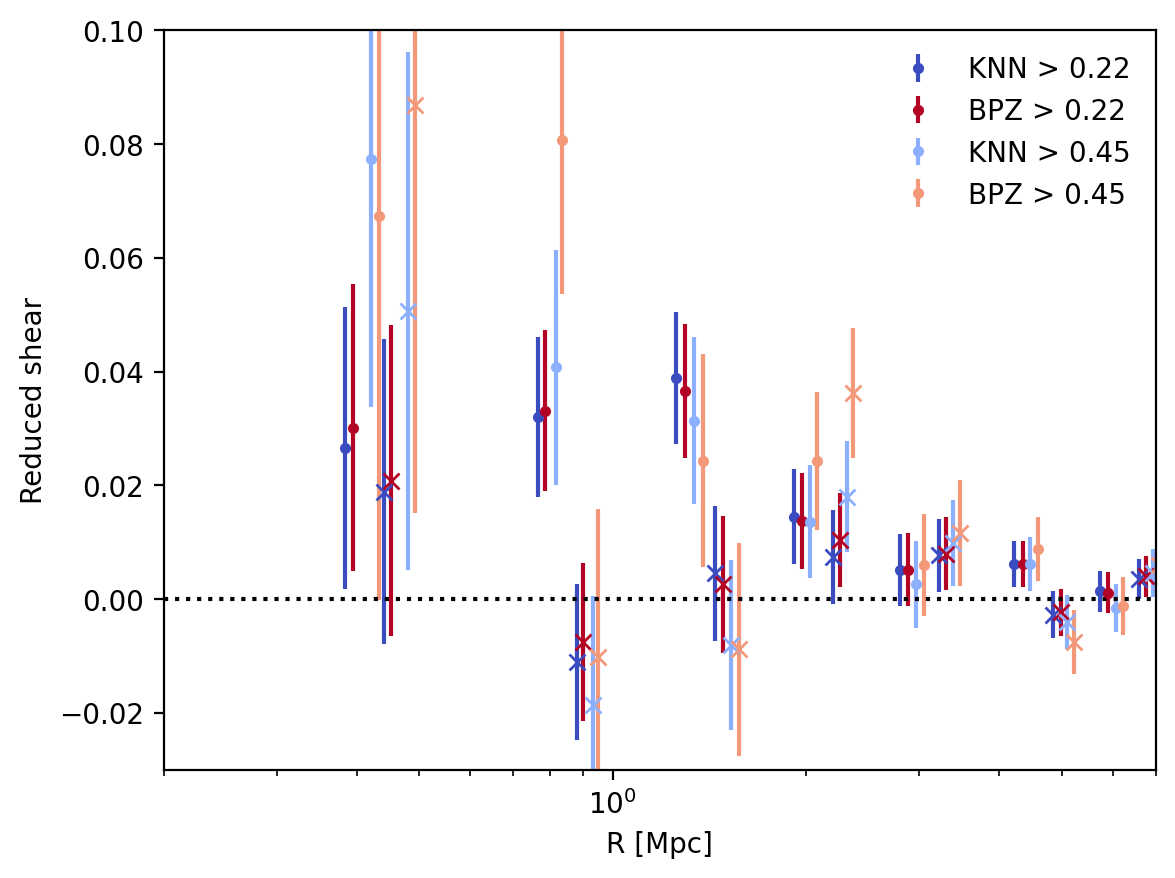

In [816]:

cmap = cm.coolwarm
labels = ['KNN > 0.22', 'BPZ > 0.22', 'KNN > 0.45',  'BPZ > 0.45']
colors = [cmap(0), cmap(1.),cmap(.25), cmap(0.75)]


for i,profile in enumerate(pz_profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.15+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i])

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with PZ Cuts - DP1")

In [817]:
pz_types = ['fzb0.22', 'tpz0.22', 'fzb0.6', 'tpz0.6']
pz_profiles = []

for cc in pz_types:
    with open(f'./cluster_data/technote/profile_{cc}', 'rb') as f:
        profile = pickle.load(f)
        pz_profiles.append(profile.profile)

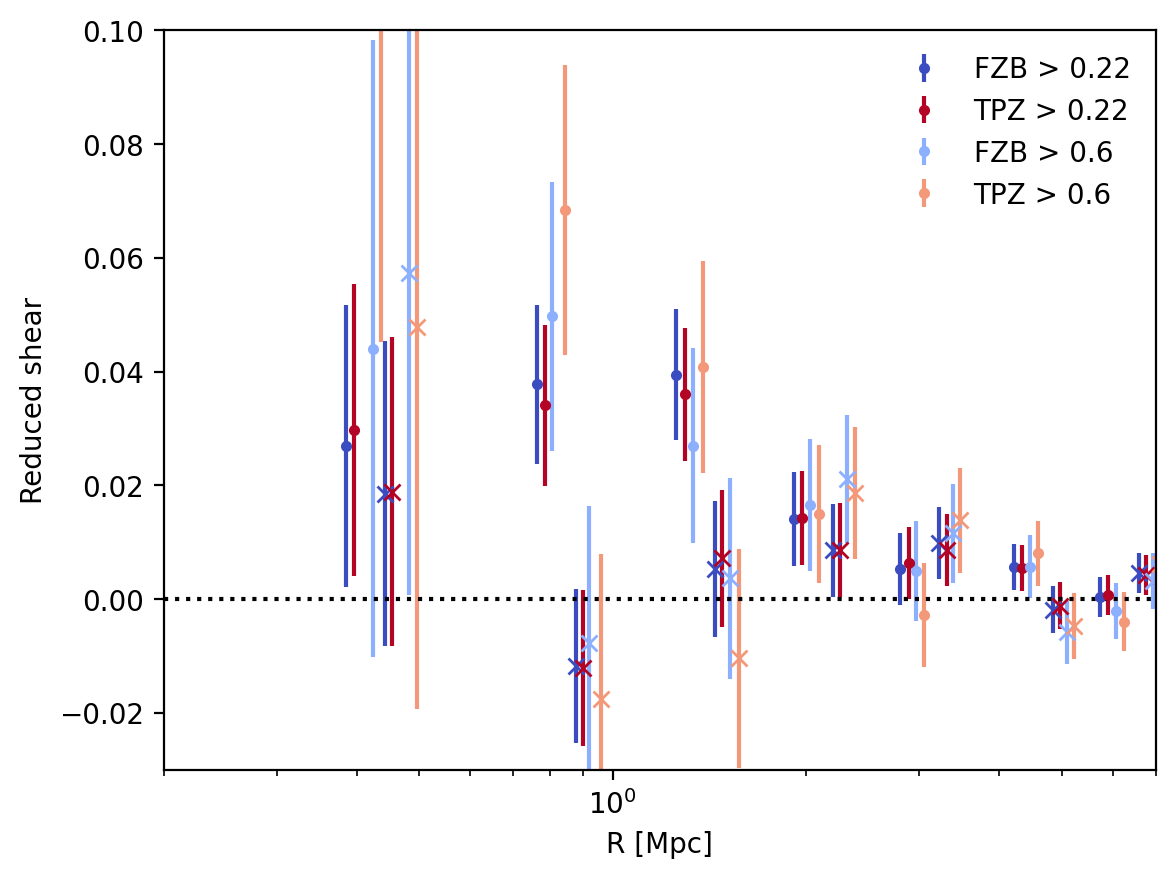

In [818]:

cmap = cm.coolwarm
labels = ['FZB > 0.22', 'TPZ > 0.22', 'FZB > 0.6',  'TPZ > 0.6']
colors = [cmap(0), cmap(1.),cmap(.25), cmap(0.75)]

for i,profile in enumerate(pz_profiles):

    plt.errorbar(profile['radius']*(1+.03*i), profile['gt'], profile['gt_err'], 
                 ls='', marker='.', label=f'{labels[i]}', color=colors[i])
    plt.errorbar(profile['radius']*(1.15+.03*i), profile['gx'], profile['gx_err'], 
                 ls='', marker='x', color=colors[i])

plt.xscale('log')
# plt.yscale('log')
plt.axhline(0.0, color='k', ls=':')
plt.ylim([-0.03,0.1])
plt.xlim([0.2,7])
#plt.yscale('log')
plt.xlabel('R [Mpc]')
plt.ylabel('Reduced shear')
plt.legend(loc=1, frameon=False)
# plt.title("HSM Profile with PZ Cuts - DP1")

### Shear Ratio Test

In [206]:
import clmm
from clmm import GalaxyCluster, ClusterEnsemble, GCData, Cosmology
from clmm import Cosmology, utils

cosmo = clmm.Cosmology(H0=70.0, Omega_dm0=0.3 - 0.045, Omega_b0=0.045, Omega_k0=0.0)

In [199]:
# From Shenming's CLMM demo on using HSC data
def apply_shear_calibration(e1_0, e2_0, e_rms, m, c1, c2, weight):
    R = 1.0 - np.sum(weight * e_rms**2.0) / np.sum(weight)
    m_mean = np.sum(weight * m) / np.sum(weight)
    c1_mean = np.sum(weight * c1) / np.sum(weight)
    c2_mean = np.sum(weight * c2) / np.sum(weight)
    print("R, m_mean, c1_mean, c2_mean: ", R, m_mean, c1_mean, c2_mean)

    g1 = (e1_0 / (2.0 * R) - c1) / (1.0 + m_mean)
    g2 = (e2_0 / (2.0 * R) - c2) / (1.0 + m_mean)

    return g1, g2


In [207]:
algos = ['knn', 'fzboost', 'bpz', 'tpz']
bin_names = ['bin1', 'bin2']

In [262]:
algo_profiles = {}

for calib_type in algos:
    for bn in bin_names:
        print(f"Working on {calib_type} {bn}")
    
        postcuts_filename = f'technote/shear-ratio_{calib_type}{bn}_DP1.fits'
        calib_filename = f'technote/shear_ratio_calib_{calib_type}_{bn}.fits'
    
        with fits.open(f'cluster_data/{calib_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            table = Table(data)
    
        with fits.open(f'cluster_data/{postcuts_filename}') as hdul:
            # Assuming data is in the first HDU (if not, change the index as needed)
            data = hdul[1].data
    
            # Convert the FITS data to an Astropy Table
            wl_table = Table(data)
    
        e_rms = table["ishape_hsm_regauss_derived_rms_e"]
        m = table["ishape_hsm_regauss_derived_shear_bias_m"]
        c1 = table["ishape_hsm_regauss_derived_shear_bias_c1"]
        c2 = table["ishape_hsm_regauss_derived_shear_bias_c2"]
        weight = table["ishape_hsm_regauss_derived_shape_weight"]
        # weight = np.ones(len(c1))
    
        g1, g2 = apply_shear_calibration(wl_table['i_hsmShapeRegauss_e1'], wl_table['i_hsmShapeRegauss_e2'], e_rms, m, c1, c2, weight)
    
        galcat = GCData()
        galcat['ra'] = wl_table['coord_ra']
        galcat['dec'] = wl_table['coord_dec']
        galcat['e1'] = g1
        galcat['e2'] = g2
        galcat['e_err'] = wl_table['i_hsmShapeRegauss_sigma']/2
        galcat['hsm_weight'] = weight
        galcat['id'] = np.arange(len(wl_table))
        galcat['z'] = np.zeros(len(wl_table))
        # galcat['z'] = wl_table['fzb_z_median']
    
        ra_bcg = 37.865017
        dec_bcg = 6.982205
        
        cluster_id = "Abell 360"
        gc_object1 = clmm.GalaxyCluster(cluster_id, ra_bcg, dec_bcg, 0.22, galcat, coordinate_system='euclidean')
    
        gc_object1.compute_tangential_and_cross_components(add=True);
        bins_mpc = np.array([.25, .5, 1, 1.5, 2.27, 3.3, 5, 7]) 
     
        gc_object1.make_radial_profile(bins=bins_mpc, bin_units='Mpc', add=True, cosmo=cosmo, 
                                   overwrite=True, use_weights=False, gal_ids_in_bins=False);
        algo_profiles[(calib_type, bn)] = gc_object1.profile

Working on knn bin1
R, m_mean, c1_mean, c2_mean:  0.8507852581234192 -0.0757610319317728 -1.80525784488124e-05 9.67227069517149e-06
Working on knn bin2
R, m_mean, c1_mean, c2_mean:  0.8428679777941148 -0.11161964415980455 -0.0003827883791800409 -2.2700211857176177e-05
Working on fzboost bin1
R, m_mean, c1_mean, c2_mean:  0.853753794785097 -0.056246820243661136 0.00013707294533029467 1.316323729456556e-05
Working on fzboost bin2
R, m_mean, c1_mean, c2_mean:  0.8436046997897865 -0.08931549574129578 -0.0003299916848557445 -3.483495925856697e-05
Working on bpz bin1
R, m_mean, c1_mean, c2_mean:  0.8496120311850853 -0.08070947082450636 -8.652164986558431e-05 -4.20825844448325e-06
Working on bpz bin2
R, m_mean, c1_mean, c2_mean:  0.8451347391477535 -0.08090421650003288 -0.0002830273579807718 -5.971653608379527e-06
Working on tpz bin1
R, m_mean, c1_mean, c2_mean:  0.8523100644928511 -0.05986017122355586 2.983781004426725e-05 1.1427323101747962e-06
Working on tpz bin2
R, m_mean, c1_mean, c2_mea

In [267]:
gc_object1.profile

GCData(cosmo='CCLCosmology(H0=70.0, Omega_dm0=0.255, Omega_b0=0.045, Omega_k0=0.0)', bin_units='Mpc', columns: radius_min, radius, radius_max, gt, gt_err, gx, gx_err, z, z_err, n_src, W_l)

In [268]:
plot_means_t = np.zeros((len(algos), 2))
plot_errs_t = np.zeros((len(algos), 2))

plot_means_x = np.zeros((len(algos), 2))
plot_errs_x = np.zeros((len(algos), 2))

for i,alg in enumerate(algos):
    for j, bn in enumerate(bin_names):
        profile = algo_profiles[(alg, bn)]
        plot_means_t[i,j] = profile['gt'][1]
        plot_errs_t[i,j] = profile['gt_err'][1]
        plot_means_x[i,j] = profile['gx'][1]
        plot_errs_x[i,j] = profile['gx_err'][1]

Text(0.02, 0.5, 'Reduced shear')

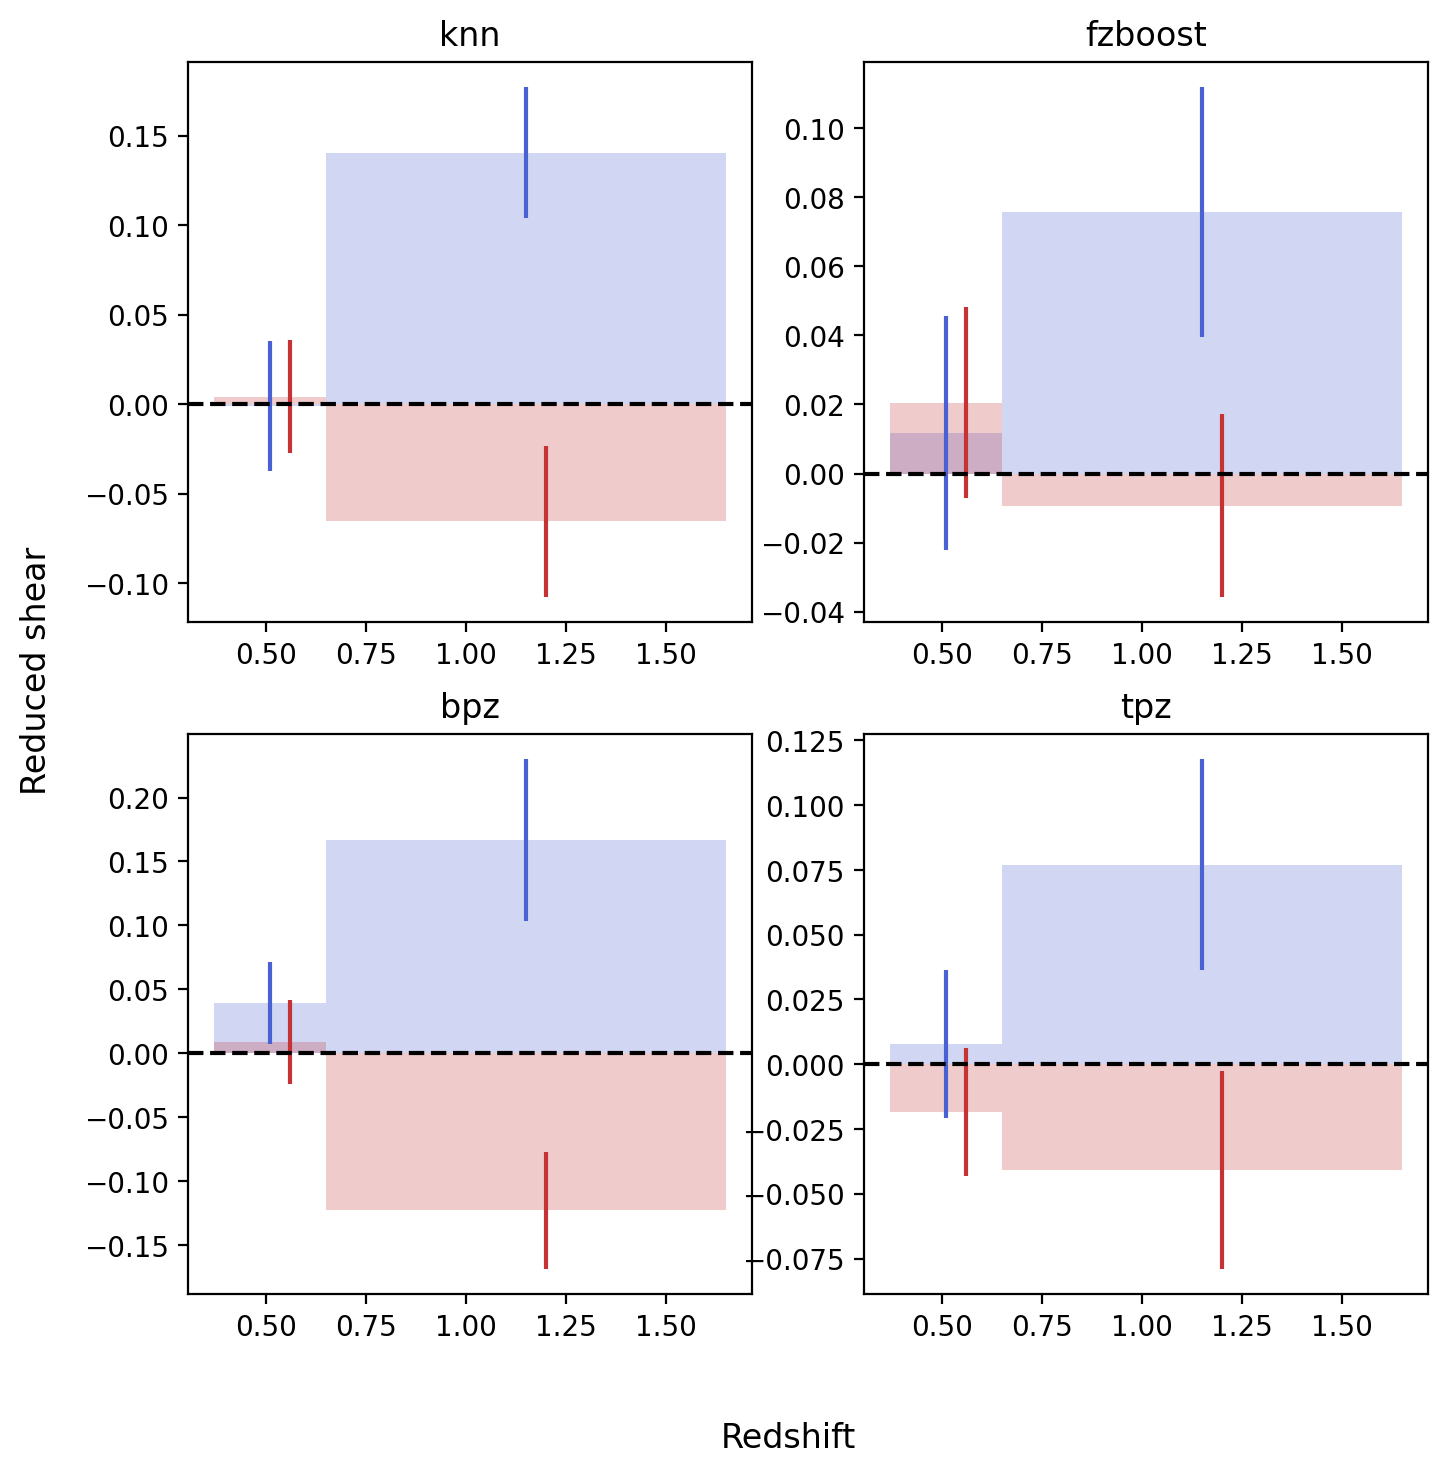

In [274]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51, 1.15], y=plot_means_t[i], yerr=plot_errs_t[i], color=cmap(0.05), ls='')
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].errorbar(x=[0.51+0.05, 1.15+0.05], y=plot_means_x[i], yerr=plot_errs_x[i], color=cmap(0.95), ls='')
    axes[ix, iy].set_title(algos[i])
    # axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')
fig.supxlabel("Redshift")
fig.supylabel("Reduced shear")

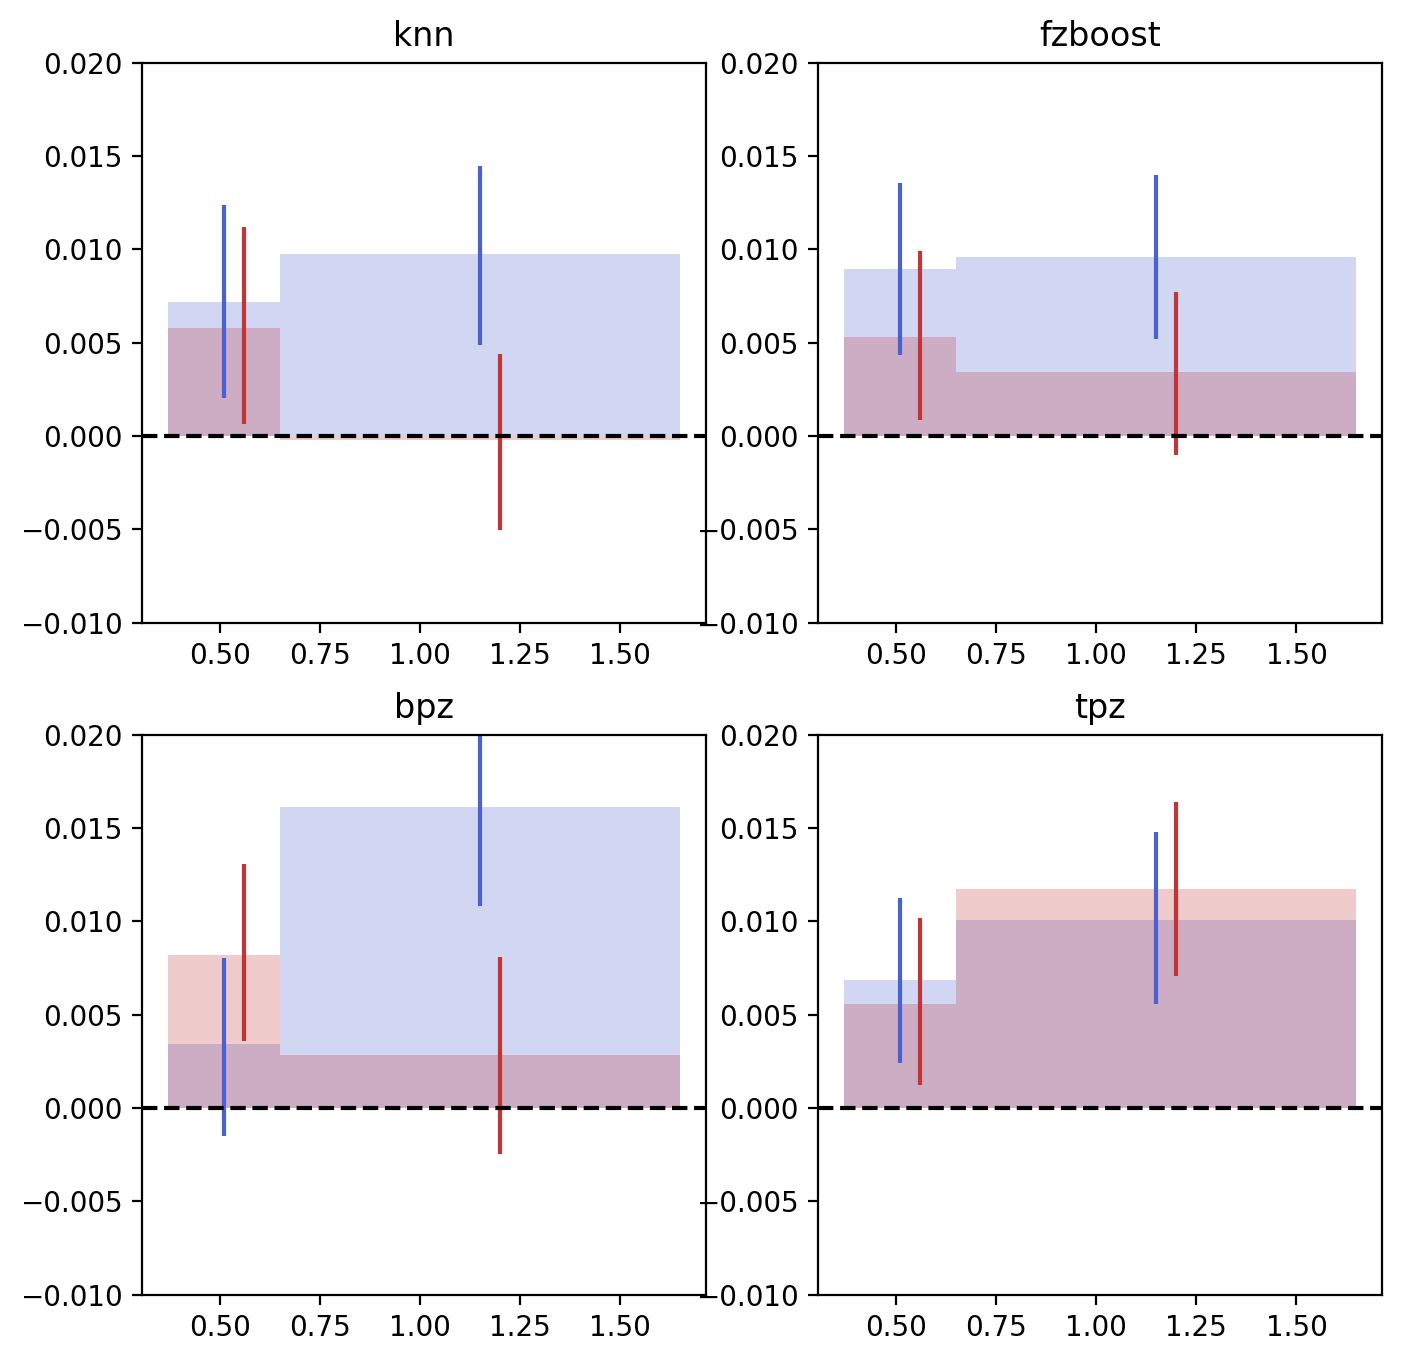

In [261]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))

cmap = cm.coolwarm

for i in range(4):
    ix = i//2
    iy = i%2

    axes[ix, iy].bar([0.51, 1.15], height=plot_means_t[i], width=[0.28, 1], color=cmap(0.05), alpha=0.25)
    axes[ix, iy].vlines([0.51, 1.15], ymin=plot_errs_t[i,:,0], ymax=plot_errs_t[i,:,1], color=cmap(0.05))
    axes[ix, iy].bar([0.51, 1.15], height=plot_means_x[i], width=[0.28, 1], color=cmap(0.95), alpha=0.25)
    axes[ix, iy].vlines([0.51+.05, 1.15+.05], ymin=plot_errs_x[i,:,0], ymax=plot_errs_x[i,:,1], color=cmap(0.95))
    axes[ix, iy].set_title(algos[i])
    axes[ix, iy].set_ylim(-.01, .02)
    axes[ix, iy].axhline(0, ls='--', color='k')

In [235]:
plot_means_t

array([[0.00719034, 0.00975415],
       [0.00893563, 0.00960428],
       [0.00343664, 0.01610923],
       [0.00682575, 0.01008181]])

In [108]:
carrot = Table.read('cluster_data/technote/a360_calib_all_new.fits')

In [111]:
carrot.columns

<TableColumns names=('i_hsmshaperegauss_derived_sigma_e','i_hsmshaperegauss_derived_rms_e','i_hsmshaperegauss_derived_weight','i_hsmshaperegauss_derived_shear_bias_m','i_hsmshaperegauss_derived_shear_bias_c1','i_hsmshaperegauss_derived_shear_bias_c2')>

In [110]:
carrot['ishape_hsm_regauss_derived_rms_e']

KeyError: 'ishape_hsm_regauss_derived_rms_e'